# Initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

similar_majors_dict = {
    # CCJEF
    "Criminology": ["BS Criminology"], # Combine Criminology and BS Criminology

    
    # SAS
    "ABComm": ["BA Comm"],
    "CommArts": ["BA Comm"],
    "AdvPublicRel": ["BA Comm"], # Area of Specialization
    # "CommArts": "BA Comm",     # Lack of Data | Drop


    # SBA
    "Accounting": ["Accountancy"],
    "Accounting Tech": ["BSAcctgInfoSys"],
    "BSBA-BM-Marketi": ["BusMgt", "BSBA-MktgMgmt"],
    "BussMgmt-HRM": ["BusMgt", "BSBA-HRMgmt"],


    # SEA
    "ECE": ["ELECENG"],
    # "BSCE-CEM": ["CE", "BSCE-CEM"],
    # "BSCE-SE": ["CE", "BSCE-SE"],
    # "BSCE-TE": ["CE", "BSCE-TE"],




    # SED
    "BEED-MajSPED": ["BSNEd"],           # Name change?
    "BEED-SpecialEdu": ["BSNEd"],        # Name change?
    "BPE-SPE": ["BPEd"],                   # Name change?
    "BSED-ValEd": ["BSED-RelValEd"],
    "BSMath": ["Math"],
    

    # SHTM
    "BS EventMgmt": ["BSTM-Events"],


    # SOC
    "BSCSSysDev": ["BSCompsci"],              # New Curriculum
    "BSITAnimation": ["BSEMC-DA"],            # New Curriculum
    "BSITAreaAnimati": ["BSEMC-DA"],          # New Curriculum
    "BSCyberplusPSM": ["BSCybersecurity"],    # Same Major but with Professional Science Master's Degree
    # "BSInfoTech": "BSIT",                 # General IT Major | Lack of Data | Drop
    # "BSITMultiTec": "BSIT",               # Discontinued | Lack of Data | Drop
    "BSITAreaNetAdmi": ["BSITNetAdmin"], 
    "BSITAreaWebDev": ["BSITWebdev"],

    }

# Dictionary for major with incorrect department
incorrect_department_dict = {
    "BSBA-HRM": "SBA",
    # "MAPEH-BSED": "SED",
}

department_dict = {
    "CHTM" : "SHTM",
    "CICT" : "SOC",
}

# List of majors to drop
drop_majors = [
    # MA
    # "MAPEH-BSED",     # Lack of data | Discontinued | SED Department?
    "MBM",              # Lack of data | only 1 student
    "MSEngMgmt",        # Lack of data | only 1 student
    

    # SAS
    # "CommArts",         # Lack of data | only 1 student
    "LanguageLit",      # Lack of data | only 1 student

    # SED
    
    # SHTM
    "BSBATourism",
    "BSTM-Tourism",     # Lack of data | BSTourism? | only 2 students


    # SOC
    "AssCompSci",       # Lack of data | only 1 student
    "BSITMultiTec",     # Lack of data | Discontinued
    "BSInfoTech",       # Lack of data | only 1 student

    # SEA
    "ECETech.",        # Lack of data | Discontinued


    # Extras | Aggregate Counts
    "TOTAL",
    "GRAND TOTAL",
]


# Threshold for the total number of students in a major in its lifetime
threshold = 10



def create_lag_features(data, lag_steps=1, group=["Major"], target="1st_Year"):
    if group:
        for i in range(1, lag_steps + 1):
            data[f'{target}_lag_{i}'] = data.groupby(group)[target].shift(i)
    else:
        for i in range(1, lag_steps + 1):
            data[f'{target}_lag_{i}'] = data[target].shift(i)
    return data

def create_rolling_mean(data, group=["Major"], window_size=3, target="1st_Year", min_periods=1, lag_steps=0):
    lag_string = f'_lag_{lag_steps}' if lag_steps else ""
    if group:
        data[f'{target}_rolling_mean{lag_string}'] = data.groupby(group)[target].shift(lag_steps).rolling(window=window_size, min_periods=min_periods).mean().values
    else:
        data[f'{target}_rolling_mean{lag_string}'] = data[target].shift(lag_steps).rolling(window=window_size, min_periods=min_periods).mean()
    return data

def create_rolling_std(data, group=["Major"], window_size=3, target="1st_Year", min_periods=1, lag_steps=0):
    lag_string = f'_lag_{lag_steps}' if lag_steps else ""
    if group:
        data[f'{target}_rolling_std{lag_string}'] = data.groupby(group)[target].shift(lag_steps).rolling(window=window_size, min_periods=min_periods).std().values
    else:
        data[f'{target}_rolling_std{lag_string}'] = data[target].shift(lag_steps).rolling(window=window_size, min_periods=min_periods).std()
    return data




# SMAPE
def smape(y_true, y_pred):
    return np.mean(2 * np.abs((y_true - y_pred) /  (np.abs(y_true) + np.abs(y_pred)))) * 100

# MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) /  y_true)) * 100


def modelresults(y_true, predictions, silent=False):
    mae = mean_absolute_error(y_true, predictions)
    rmse = np.sqrt(mean_squared_error(y_true, predictions))
    r2 = r2_score(y_true, predictions)
    smape_score = smape(y_true, predictions)
    mape_score = mape(y_true, predictions)

    if not silent:
        print(f"Symmetric Mean Absolute Percentage Error: {smape_score:.2f}%")
        print(f'Mean Absolute Percentage Error: {mape_score:.2f}%')
        print(f'Mean Absolute Error: {mae:.4f}')
        print(f'Root Mean Squared Error: {rmse:.4f}')
        print(f'R2 Score: {r2*100:.4f}')

    return {
        "smape": smape_score,
        "mape": mape_score,
        "mae": mae,
        "rmse": rmse,
        "r2": r2
    }


# Determine the start of enrollment period
def determine_start_month(semester):
    if semester == 1:
       return 5  # June
    else:
        
        return 10  # November

In [2]:
def create_features_by_year_level(df, year_level):
    match year_level:
        case "1st_Year":
            df = create_lag_features(df, target="1st_Year", lag_steps=1)
            df = df.rename(columns={"1st_Year_lag_1": "Previous_Semester"})
            df = create_rolling_std(df, target="1st_Year", lag_steps=1, window_size=3)
        
        case "2nd_Year":
            df = create_lag_features(df, target="1st_Year", lag_steps=1)
            # df = df.drop(columns=["1st_Year_lag_1"])
            df = create_lag_features(df, target="2nd_Year", lag_steps=1)
            # Create a new column based on semester and lagged values
            df['Previous_Semester'] = df.apply(lambda row: 
                                           row['1st_Year_lag_1'] if row['Semester'] == 1 
                                           else row['2nd_Year_lag_1'] if row['Semester'] == 2
                                           else None, axis=1)
            df = df.drop(columns=["1st_Year_lag_1"])
            print(df.columns)
            df = create_rolling_std(df, target="2nd_Year", lag_steps=1, window_size=3)
        
        case "3rd_Year":
            df = create_lag_features(df, target="2nd_Year", lag_steps=1)
            # df = df.drop(columns=["1st_Year_lag_1"])
            df = create_lag_features(df, target="3rd_Year", lag_steps=1)
            # Create a new column based on semester and lagged values
            df['Previous_Semester'] = df.apply(lambda row: 
                                           row['2nd_Year_lag_1'] if row['Semester'] == 1 
                                           else row['3rd_Year_lag_1'] if row['Semester'] == 2
                                           else None, axis=1)
            df = df.drop(columns=["2nd_Year_lag_1"])
            print(df.columns)
            df = create_rolling_std(df, target="3rd_Year", lag_steps=1, window_size=3)
        
        case "4th_Year":
            df = create_lag_features(df, target="3rd_Year", lag_steps=1)
            # df = df.drop(columns=["1st_Year_lag_1"])
            df = create_lag_features(df, target="4th_Year", lag_steps=1)
            # Create a new column based on semester and lagged values
            df['Previous_Semester'] = df.apply(lambda row: 
                                           row['3rd_Year_lag_1'] if row['Semester'] == 1 
                                           else row['4th_Year_lag_1'] if row['Semester'] == 2
                                           else None, axis=1)
            df = df.drop(columns=["3rd_Year_lag_1"])
            print(df.columns)
            df = create_rolling_std(df, target="4th_Year", lag_steps=1, window_size=3)
        
        case _:
            raise ValueError(f"Unsupported year level: {year_level}")
    
    return df





In [3]:
year_levels = ["1st_Year", "2nd_Year", "3rd_Year", "4th_Year"]

ith_year = 0
year_level = year_levels[ith_year]

In [7]:
import joblib
from sklearn.preprocessing import OneHotEncoder


df = pd.read_csv("data/Enrollment_Data.csv")
cpi_df = pd.read_csv("data/CPI_Education.csv")
inflation_df = pd.read_csv("data/Inflation_Rate.csv")
admission_df = pd.read_csv("data/Admission_Data.csv")
hfce_df = pd.read_csv("data/HFCE.csv")
# df = process_enrollment_data(df)
df = df.drop(columns=["End_Year"])
# Calculate attrition rate and lag it, considering semesters passed


# Apply the function to calculate attrition rate and lag it

admission_df = admission_df.drop(columns=["Number_of_Processed_Applicants", "Number_of_Enrolled_Applicants"])
admission_df["Department"] = admission_df["Department"].replace("CICT", "SOC")


admission_df = create_lag_features(admission_df, group=["Department"], target="Number_of_Applicants", lag_steps=1)
# admission_df = create_rolling_mean(admission_df, group=["Department"], target="Number_of_Applicants", window_size=2, min_periods=1, lag_steps=1)
admission_df = create_rolling_std(admission_df, group=["Department"], target="Number_of_Applicants", window_size=3, min_periods=1, lag_steps=0)
# admission_df = create_lag_features(admission_df, group=["Department"], target="Number_of_Applicants", window_size=3, min_periods=1, lag_steps=1)
admission_df = admission_df.fillna(0)

# Process CPI data
cpi_df_copy = cpi_df.copy()
cpi_df_copy = cpi_df_copy[cpi_df_copy["Month"] != "Ave"]  # Exclude "Ave" rows

cpi_df_copy = cpi_df_copy.dropna()
cpi_df_copy[["Year"]] = cpi_df_copy[["Year"]].astype(int)
cpi_df_copy = cpi_df_copy.groupby("Year")["CPI_Region3"].mean().reset_index()
cpi_df_copy = create_rolling_std(cpi_df_copy, group=None, target="CPI_Region3", window_size=6, lag_steps=0)

# Assuming df is your DataFrame

# Step 1: Replace similar majors
for old_majors, new_major  in similar_majors_dict.items():
    df['Major'] = df['Major'].replace(old_majors, new_major[0])

# Step 2: Correct departments

for major, department in incorrect_department_dict.items():
    df.loc[df["Major"]== major, 'Department'] = department
    
# Step 3: Rename departments
df['Department'] = df['Department'].replace(department_dict)

# Step 4: Drop unwanted majors
df = df[~df['Major'].isin(drop_majors)]

# # Step 5: Filter by threshold
# major_counts = df['Major'].value_counts()
# valid_majors = major_counts[major_counts >= threshold].index
# df = df[finalDf['Major'].isin(valid_majors)]

# Step 6: Combine majors with the same name within the same semester
df = df.groupby(['Start_Year', 'Semester', 'Major', 'Department'], as_index=False).sum(["1st_Year", "2nd_Year", "3rd_Year", "4th_Year", "5th_Year", "Grade_12", "TOTAL"])


shs_df = df[df["Department"] == "SHS"].pivot_table(index=["Start_Year", "Semester"], columns="Major", values="Grade_12").reset_index().fillna(0)
shs_df["Start_Year"] += 1
shs_df = shs_df.rename(columns={col: f"{col}_lag_1" for col in shs_df.columns.drop(["Start_Year", "Semester"])})



df = df[~df['Department'].isin(['GS', 'JHS', 'SHS', 'HAUSPELL', 'HAU', 'MA'])]
df = df[~df['Major'].isin(['TOTAL', 'GRAND TOTAL'])]
df = df.drop(df.loc[:, "Grade_1":"Grade_11"].columns, axis=1)
df = df.reset_index(drop=True)




inflation_df_copy = inflation_df[["Start_Year", "Inflation_Rate"]].copy()
inflation_df_copy = inflation_df_copy.dropna()
inflation_2024 = inflation_df_copy[inflation_df_copy["Start_Year"] == 2023].copy()
inflation_2024["Start_Year"] = 2024
inflation_2024["Inflation_Rate"] = float('nan')
inflation_df_copy = pd.concat([inflation_df_copy, inflation_2024], ignore_index=True)
inflation_df_copy = inflation_df_copy.sort_values(by=['Start_Year']).reset_index(drop=True)
inflation_df_copy = inflation_df_copy[inflation_df_copy["Start_Year"] <= 2024]
inflation_df_copy = create_rolling_std(inflation_df_copy, group=None, target="Inflation_Rate", window_size=5, lag_steps=1)
inflation_df_copy = inflation_df_copy.drop(columns=["Inflation_Rate"])


# Process HFCE data
hfce_df = hfce_df.groupby('Start_Year').mean().reset_index()
hfce_df = create_lag_features(hfce_df, group=None, target="HFCE_Education", lag_steps=1)
hfce_df = create_rolling_std(hfce_df, group=None, target="HFCE_Education", window_size=6)

hfce_df = create_lag_features(hfce_df, group=None, target="HFCE", lag_steps=1)
hfce_df = create_rolling_std(hfce_df, group=None, target="HFCE", window_size=6)

hfce_df = hfce_df.dropna()
hfce_df = hfce_df.drop(columns=["Quarter", "HFCE_Education", "HFCE"])



# Apply the function and create Semester_Start column
df['Start_Month'] = df['Semester'].apply(determine_start_month)

# Get End Month after 18 weeks
# df['End_Month'] = df['Start_Month'] + 4
df = df.fillna(0)



# # Add 'Modified' column where 1st_Year is 0
# df['Modified'] = df['1st_Year'].apply(lambda x: True if x == 0 else False)

numerical_features =  df.drop(columns=["Major", "Department"]).columns
df[numerical_features] = df[numerical_features].astype(int)


# Add CPI_Region3 to the dataframe
df_encoded = df.copy()
df_encoded["Start_Year"].unique()


# df_encoded = df.copy()
# df_encoded.drop(drop_majors, axis=1, inplace=True)


df_encoded = df_encoded.merge(cpi_df_copy, left_on=["Start_Year"], right_on=["Year"], how="left")
# df_encoded = df_encoded.merge(cpi_df_copy, left_on=["Start_Year", "Start_Month"], right_on=["Year", "Month"], how="left")

df_encoded = df_encoded.merge(inflation_df_copy, on=["Start_Year"], how="left")

if year_level == "1st_Year":
    df_encoded = df_encoded.merge(admission_df, on=["Department",  "Start_Year"], how="left")
    df_encoded = df_encoded.drop(columns=["Number_of_Applicants"])

df_encoded = df_encoded.merge(hfce_df, on=["Start_Year"], how="left")
# df_encoded = df_encoded.merge(hfce_df_copy, on=["Start_Year", "Semester"], how="left")

df_encoded = df_encoded.drop(columns=["Year"])


# Lagged Features
# Calculate Exponential Moving Average (EMA)
ema_df = pd.DataFrame()
# ema_df['Inflation_Rate_EMA'] = df_encoded.groupby(['Start_Year', 'Major'])['Inflation_Rate'].transform(lambda x: x.ewm(span=2, adjust=False).mean())

# Ensure DataFrame is sorted by 'Start_Year' and index
df_encoded.sort_values(by=['Start_Year', 'Semester'], inplace=True)
df_encoded = create_features_by_year_level(df_encoded, year_level)


# df_encoded = create_lag_features(df_encoded, lag_steps=2, target="Grade_12")
# df_encoded = create_rolling_std(df_encoded, lag_steps=2, window_size=3, target="Grade_12")

df_encoded = create_lag_features(df_encoded, lag_steps=1, target="TOTAL")

# df_encoded = create_rolling_std(df_encoded, window_size=3, target="2nd_Year")
# df_encoded = create_rolling_std(df_encoded, window_size=3, target="3rd_Year")
# df_encoded = create_rolling_std(df_encoded, window_size=3, target="4th_Year")
# df_encoded = calculate_attrition_rate(df_encoded)



# df_encoded = df_encoded.drop(columns=["Number_of_Applicants", "CPI_Region3"])



# ema_df['1st_Year_EMA'] = df_encoded.groupby('Major')['1st_Year'].transform(lambda x: x.ewm(span=2, adjust=False).mean())
# ema_df['2nd_Year_EMA'] = df_encoded.groupby('Major')['2nd_Year'].transform(lambda x: x.ewm(span=2, adjust=False).mean())
# ema_df['3rd_Year_EMA'] = df_encoded.groupby('Major')['3rd_Year'].transform(lambda x: x.ewm(span=2, adjust=False).mean())
# ema_df['4th_Year_EMA'] = df_encoded.groupby('Major')['4th_Year'].transform(lambda x: x.ewm(span=2, adjust=False).mean())

#df_encoded = df_encoded.dropna()


# Assume df_train is your training dataframe
# One-hot encode departments and majors
dept_encoder = OneHotEncoder(sparse_output=False)
major_encoder = OneHotEncoder(sparse_output=False)

dept_encoded = dept_encoder.fit_transform(df_encoded[['Department']])
major_encoded = major_encoder.fit_transform(df_encoded[['Major']])

# Perform PCA
dept_pca = PCA(n_components=2, random_state=24)
major_pca = PCA(n_components=2, random_state=24)

department_principalComponents = dept_pca.fit_transform(dept_encoded)
department_principalDf = pd.DataFrame(data = department_principalComponents, columns = [f"Department_PC{i+1}" for i in range(2)])

major_principalComponents = major_pca.fit_transform(major_encoded)
major_principalDf = pd.DataFrame(data = major_principalComponents, columns = [f"Major_PC{i+1}" for i in range(2)])


# Save the encoders and PCA objects
joblib.dump(dept_encoder, 'angeliteforecast/data/dept_encoder.pkl')
joblib.dump(major_encoder, 'angeliteforecast/data/major_encoder.pkl')
joblib.dump(dept_pca, 'angeliteforecast/data/dept_pca.pkl')
joblib.dump(major_pca, 'angeliteforecast/data/major_pca.pkl')


# department_df = pd.get_dummies(df_encoded[["Department"]])
# major_df = pd.get_dummies(df_encoded[["Major"]])
# # df_encoded = pd.concat([df_encoded, major_df], axis=1)


# # Dimensionality Reduction for Major
# pca = PCA(n_components=2, random_state=24)
# department_principalComponents = pca.fit_transform(department_df)
# department_principalDf = pd.DataFrame(data = department_principalComponents, columns = [f"Department_PC{i+1}" for i in range(2)])

# major_principalComponents = pca.fit_transform(major_df)
# major_principalDf = pd.DataFrame(data = major_principalComponents, columns = [f"Major_PC{i+1}" for i in range(2)])


finalDf = pd.concat([df_encoded, department_principalDf, major_principalDf], axis = 1)

# finalDf = finalDf.dropna()

# Drop major with less than 10 students overall
major_counts = finalDf.groupby('Major')[year_level].sum()
valid_majors = major_counts[major_counts >= 10].index
finalDf = finalDf[finalDf['Major'].isin(valid_majors)]

finalDf = finalDf.merge(shs_df, on=["Start_Year", "Semester"], how="left")
finalDf = finalDf.drop(columns=["CPI_Region3"])


# Step 1: Group by year and major to get the sum of students in each major for each year
grouped = finalDf.groupby(['Start_Year', 'Semester', 'Major'])["Previous_Semester"].sum().reset_index()

# Step 2: Calculate the total number of students for each year
total_students_per_year = grouped.groupby(['Start_Year', 'Semester'])[f'Previous_Semester'].sum().reset_index()
total_students_per_year.rename(columns={f'Previous_Semester': f'Total_Previous_Semester_Students_lag_1'}, inplace=True)

# Step 3: Merge the total students per year with the grouped data
distribution_df = pd.merge(grouped, total_students_per_year, on=['Start_Year', 'Semester'])

# Step 4: Calculate the percentage distribution of each major
distribution_df['Percentage_Distribution_lag_1'] = (distribution_df[f'Previous_Semester'] / distribution_df[f'Total_Previous_Semester_Students_lag_1']) * 100


finalDf = finalDf.merge(distribution_df.drop(columns=[f"Previous_Semester"]), on=['Start_Year', 'Semester', 'Major'])
# finalDf = finalDf.drop(columns=[f"{year_level}_lag_1"])

# # Create multiple columns filled with 0s
# for i in range(3, 5):
#     finalDf[f"Grade_12_lag_{i}"] = 1
    
finalDf = finalDf.sort_values(by=['Start_Year', 'Start_Month'])

# Train-Test Split


In [30]:
finalDf_copy = finalDf.fillna(0).drop_duplicates()[finalDf[year_level] > 0]

# Drop items with less than 3 observations
finalDf_copy = finalDf_copy.groupby('Major').filter(lambda x: len(x) > 3)
finalDf_copy = finalDf_copy.reset_index(drop=True)
finalDf_copy = finalDf_copy.sort_values(by=['Start_Year', 'Start_Month'])



X = finalDf_copy.drop(columns=["Grade_12", '1st_Year',  '2nd_Year', '3rd_Year', '4th_Year', '5th_Year', 'TOTAL', "Department",
                               
                               # "Major_PC1", "Major_PC2", "Department_PC1", "Department_PC2",
                               # "Total_Students_lag_1", "Percentage_Distribution_lag_1",
                               # "Number_of_Applicants_lag_1", "CPI_Region3_lag_1", "1st_Year_lag_1",
                               # "Number_of_Applicants_rolling_mean", "CPI_Region3_rolling_mean", "1st_Year_rolling_mean",
                               # "Number_of_Applicants_rolling_std", "CPI_Region3_rolling_std", "1st_Year_rolling_std",
   ])
X['Major'] = X['Major'].astype('category')

y = finalDf_copy[year_level]

# X_train_k12 = X.query("2017 < Start_Year < 2024")
# y_train_k12 = y[X.query("2017 < Start_Year < 2024").index]

# X_train = X.query("Start_Year == 2016 and Semester == 2")
# y_train = y[X.query("Start_Year == 2016 and Semester == 2").index]

X_train = X.query(f"{2018+ith_year} < Start_Year < 2024")
y_train = y[X.query(f"{2018+ith_year} < Start_Year < 2024").index]

# beginning_data = X_train.query("Start_Year == 2017 and Semester == 1").index

# X_train = X_train.drop(beginning_data)
# y_train = y_train.drop(beginning_data)

X_test = X.query("Start_Year == 2024")
y_test = y[X.query("Start_Year == 2024").index]

X_train_plot = X_train.copy()
X_test_plot = X_test.copy()
# X_train["Start_Year"] -= X_train["Start_Year"].min()
# X_test["Start_Year"] -= X_train["Start_Year"].min()
# X_train["Semester"] -= X_train["Semester"].min()
# X_test["Semester"] -= X_train["Semester"].min()



In [79]:
import joblib
# Save columns for deployment
columns = X.drop(columns=["Start_Month"]).columns
majors = X["Major"].unique()
departments = finalDf_copy["Department"].unique()

enrollment_properties = {
    "columns": columns,
    "majors": majors,
    "departments": departments,
}
import json

# joblib.dump(columns, "angeliteforecast/data/columns.pkl")

print(columns)
# Save departments into json
with open("data/departments.json", "w") as f:
    json.dump(departments.tolist(), f)

Index(['Start_Year', 'Semester', 'Major', 'CPI_Region3_rolling_std',
       'Inflation_Rate_rolling_std_lag_1', 'HFCE_Education_lag_1',
       'HFCE_Education_rolling_std', 'HFCE_lag_1', 'HFCE_rolling_std',
       '2nd_Year_lag_1', 'Previous_Semester', '2nd_Year_rolling_std_lag_1',
       'TOTAL_lag_1', 'Department_PC1', 'Department_PC2', 'Major_PC1',
       'Major_PC2', 'SHS-ABM_lag_1', 'SHS-GenAcad_lag_1', 'SHS-HUMSS_lag_1',
       'SHS-STEM_lag_1', 'SHS-TVL-HE_lag_1', 'SHS-TVL-ICT_lag_1',
       'Total_Previous_Semester_Students_lag_1',
       'Percentage_Distribution_lag_1'],
      dtype='object')


# Models

## DART (XGBoost)
DART: Dropouts meet Multiple Additive Regression Trees

In [13]:
best_xgb_params = {'lambda': 0.0010452215345317598,
                   'alpha': 5.560209738135623e-05,
                   'subsample': 1.0,
                   'colsample_bytree': 1.0,
                   'colsample_bylevel': 0.6,
                   'colsample_bynode': 0.9,
                   'min_child_weight': 5,
                   'max_depth': 6,
                   'eta': 0.3566635372570972,
                   'gamma': 0.000812024800686354,
                   'grow_policy': 'depthwise',
                   'booster': 'dart',
                   'sample_type': 'uniform',
                   'normalize_type': 'forest',
                   'rate_drop': 0.507289758093991911,
                   'skip_drop': 0.05622856903026999,
                   'eval_metric': 'rmse'
                   }
best_rf_params = {'n_estimators': 149, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'criterion': 'friedman_mse'}


best_knn_params = {'metric': 'manhattan',
                   'n_neighbors': 4,
                   'weights': 'distance'}

# save to json
import json

# Combine all parameters into one dictionary
all_params = {
    "xgb": best_xgb_params,
    "rf": best_rf_params,
    "knn": best_knn_params,
}

# Save all parameters to a single json file
with open("AngeliteForecast/data/tuned_params.json", "w") as f:
    json.dump(all_params, f)






In [63]:
import xgboost as xgb
from sklearn.feature_selection import SelectKBest, f_regression
import numpy as np

# Select the most relevant features for XGBoost, but keep SHS columns
shs_columns = [col for col in X_train.columns if 'SHS' in col]
non_shs_columns = [col for col in X_train.columns if col not in shs_columns and col not in ["Major", 'Start_Month']]

# Perform feature selection
feature_selector = SelectKBest(score_func=f_regression, k=20)  # You can adjust k as needed
X_selected = feature_selector.fit_transform(X_train[non_shs_columns], y_train)

# Get the names of the selected features
selected_feature_indices = feature_selector.get_support(indices=True)
xgb_selected_feature_names = list(X_train[non_shs_columns].columns[selected_feature_indices])

# Add SHS columns to the selected features
xgb_selected_feature_names.extend(shs_columns)

# Create new dataframes with selected features and SHS columns
X_xgb_train = X_train[xgb_selected_feature_names]
X_xgb_test = X_test[xgb_selected_feature_names]

# Convert to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_xgb_train, label=y_train)
dtest = xgb.DMatrix(X_xgb_test, label=y_test)


# Train the XGBoost DART model
xgb_model = xgb.train(best_xgb_params, dtrain)

# Make predictions
train_predictions = xgb_model.predict(dtrain)
test_predictions = xgb_model.predict(dtest)

print("Trained XGBoost DART Model")

# Print selected features
print("Selected features for XGBoost DART:")
print(xgb_selected_feature_names)

# Calculate feature importance
importance_scores = xgb_model.get_score(importance_type='gain')
sorted_importance = sorted(importance_scores.items(), key=lambda x: x[1], reverse=True)

print("\nTop 10 most important features:")
for feature, score in sorted_importance[:10]:
    print(f"{feature}: {score}")

# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score

rmse_train = np.sqrt(mean_squared_error(y_train, train_predictions))
r2_train = r2_score(y_train, train_predictions)
rmse_test = np.sqrt(mean_squared_error(y_test, test_predictions))
r2_test = r2_score(y_test, test_predictions)

print("\nModel Performance:")
print(f"Train RMSE: {rmse_train:.4f}")
print(f"Train R2: {r2_train:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")
print(f"Test R2: {r2_test:.4f}")

Trained XGBoost DART Model
Selected features for XGBoost DART:
['Start_Year', 'Semester', 'CPI_Region3_rolling_std', 'Inflation_Rate_rolling_std_lag_1', 'HFCE_Education_lag_1', 'HFCE_Education_rolling_std', 'HFCE_lag_1', 'HFCE_rolling_std', '3rd_Year_lag_1', 'Previous_Semester', '3rd_Year_rolling_std_lag_1', 'TOTAL_lag_1', 'Department_PC1', 'Department_PC2', 'Major_PC1', 'Major_PC2', 'Total_Previous_Semester_Students_lag_1', 'Percentage_Distribution_lag_1', 'SHS-ABM_lag_1', 'SHS-GenAcad_lag_1', 'SHS-HUMSS_lag_1', 'SHS-STEM_lag_1', 'SHS-TVL-HE_lag_1', 'SHS-TVL-ICT_lag_1']

Top 10 most important features:
Percentage_Distribution_lag_1: 90615.0703125
3rd_Year_lag_1: 59363.40234375
TOTAL_lag_1: 47350.890625
Previous_Semester: 44407.44921875
CPI_Region3_rolling_std: 4637.1279296875
SHS-ABM_lag_1: 4477.22216796875
Department_PC2: 3551.031982421875
Major_PC2: 3020.051513671875
SHS-TVL-HE_lag_1: 2208.93701171875
3rd_Year_rolling_std_lag_1: 2137.161865234375

Model Performance:
Train RMSE: 14.7

d:\Kent\Programs\miniconda3\envs\enrollment\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=20 is greater than n_features=18. All the features will be returned.
  warnings.warn(


### 1st Year

In [108]:
# With boosting rounds

import xgboost as xgb

X_xgb_train = X_train.drop(columns=['Start_Month'])
X_xgb_test = X_test.drop(columns=['Start_Month'])

# Create DMatrix objects
dtrain = xgb.DMatrix(X_xgb_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_xgb_test, label=y_test, enable_categorical=True)

# Define evaluation set for early stopping
eval_set = [(dtrain, 'train'), (dtest, 'test')]

# Set default parameters
default_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
}

# Combine default_params with best_xgb_params
params = {**default_params, **best_xgb_params}

# Train the model with early stopping
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,  # Set a high number, early stopping will prevent overfitting
    evals=eval_set,
    early_stopping_rounds=200,
    verbose_eval=True
)

# Make predictions
train_predictions = xgb_model.predict(dtrain)
test_predictions = xgb_model.predict(dtest)

print("Trained XGBoost DART Model")
print(f"Best iteration: {xgb_model.best_iteration}")
print(f"Best score: {xgb_model.best_score}")

[0]	train-rmse:65.45896	test-rmse:52.70307


[1]	train-rmse:43.76383	test-rmse:40.83390
[2]	train-rmse:33.97573	test-rmse:35.50481
[3]	train-rmse:27.96132	test-rmse:33.41786
[4]	train-rmse:22.87932	test-rmse:31.78684
[5]	train-rmse:19.77757	test-rmse:29.24489
[6]	train-rmse:15.78872	test-rmse:27.30648
[7]	train-rmse:15.04841	test-rmse:26.99353
[8]	train-rmse:13.93818	test-rmse:26.45942
[9]	train-rmse:13.04394	test-rmse:25.08790
[10]	train-rmse:12.63637	test-rmse:24.41526
[11]	train-rmse:11.65619	test-rmse:23.88812
[12]	train-rmse:11.95048	test-rmse:24.22265
[13]	train-rmse:11.80791	test-rmse:24.55913
[14]	train-rmse:11.65485	test-rmse:23.90697
[15]	train-rmse:11.41451	test-rmse:23.61927
[16]	train-rmse:12.19108	test-rmse:23.13841
[17]	train-rmse:11.75398	test-rmse:24.23324
[18]	train-rmse:11.84370	test-rmse:24.94286
[19]	train-rmse:11.56241	test-rmse:24.88968
[20]	train-rmse:11.23432	test-rmse:24.83124
[21]	train-rmse:10.56965	test-rmse:25.23308
[22]	train-rmse:10.48184	test-rmse:25.24399
[23]	train-rmse:11.08347	test-rmse:25.949

In [31]:
# Without Inflation Rate | TOTAL lag steps = 1

import xgboost as xgb

X_xgb_train = X_train.drop(columns=['Start_Month'])
X_xgb_test = X_test.drop(columns=['Start_Month'])

# Create DMatrix objects
dtrain = xgb.DMatrix(X_xgb_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_xgb_test, label=y_test, enable_categorical=True)

# Define evaluation set for early stopping
eval_set = [(dtrain, 'train'), (dtest, 'test')]

# Set default parameters
default_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
}

# Combine default_params with best_xgb_params
params = {**default_params, **best_xgb_params}

# Train the model with early stopping
xgb_model = xgb.train(
    params,
    dtrain,
)

# Make predictions
train_predictions = xgb_model.predict(dtrain)
test_predictions = xgb_model.predict(dtest)

print(year_level)
print("-"*50)  
print("XGBoost DART")
print("-"*50)

print("TEST")
modelresults(y_test, test_predictions)
print("-"*50)

print("TRAIN")
modelresults(y_train, train_predictions)
print("-"*50)


1st_Year
--------------------------------------------------
XGBoost DART
--------------------------------------------------
TEST
Symmetric Mean Absolute Percentage Error: 38.71%
Mean Absolute Percentage Error: 76.69%
Mean Absolute Error: 16.6070
Root Mean Squared Error: 25.0879
R2 Score: 89.5871
--------------------------------------------------
TRAIN
Symmetric Mean Absolute Percentage Error: 28.58%
Mean Absolute Percentage Error: 60.16%
Mean Absolute Error: 7.3415
Root Mean Squared Error: 13.0439
R2 Score: 98.2567
--------------------------------------------------


### Metrics

In [134]:
train_true_values = y_train
train_pred_values = train_predictions
test_true_values = y_test
test_pred_values = test_predictions

In [21]:
print("-"*50)  
print("XGBoost DART")
print("-"*50)

print("TEST")
modelresults(y_test, test_predictions)
print("-"*50)

print("TRAIN")
modelresults(y_train, train_predictions)
print("-"*50)


--------------------------------------------------
XGBoost DART
--------------------------------------------------
TEST
Symmetric Mean Absolute Percentage Error: 41.07%
Mean Absolute Percentage Error: 79.39%
Mean Absolute Error: 17.1995
Root Mean Squared Error: 25.9245
R2 Score: 88.8811
--------------------------------------------------
TRAIN
Symmetric Mean Absolute Percentage Error: 23.00%
Mean Absolute Percentage Error: 36.20%
Mean Absolute Error: 6.3181
Root Mean Squared Error: 10.8495
R2 Score: 98.7939
--------------------------------------------------


### Cross Validation

In [127]:
def xgb_time_series_cv(xgb_model, X, y, split_by='semester', start_year=2019, silent=True):
    cv_results = []
    
    # Filter data for years >= start_year
    mask = X['Start_Year'] >= start_year
    X = X[mask].reset_index(drop=True)
    y = y[mask].reset_index(drop=True)
    
    splits = custom_time_series_split(X, y, split_by)
    
    for split_index, (train_index, test_index) in enumerate(splits):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Get the time range for this split
        train_start = X_train['Start_Year'].min()
        train_end = X_train['Start_Year'].max()
        test_year = X_test['Start_Year'].iloc[0]
        if split_by == 'semester':
            train_start_sem = X_train.loc[X_train['Start_Year'] == train_start, 'Semester'].min()
            train_end_sem = X_train.loc[X_train['Start_Year'] == train_end, 'Semester'].max()
            test_sem = X_test['Semester'].iloc[0]
            time_range = f"{train_start}-{train_start_sem} to {train_end}-{train_end_sem}, Test: {test_year}-{test_sem}"
        else:
            time_range = f"{train_start} to {train_end}, Test: {test_year}"
        
        # Prepare data for XGBoost
        X_xgb_train = X_train.drop(columns=['Start_Month'])
        X_xgb_test = X_test.drop(columns=['Start_Month'])
        
        # Convert to DMatrix format
        dtrain = xgb.DMatrix(X_xgb_train, label=y_train, enable_categorical=True)
        dtest = xgb.DMatrix(X_xgb_test, label=y_test, enable_categorical=True)
        
        # Train the model
        xgb_model = xgb.train(best_xgb_params, dtrain)
        
        # Make predictions
        y_pred = xgb_model.predict(dtest)
        
        # Calculate metrics for this split using modelresults function
        metrics = modelresults(y_test, y_pred, silent=True)
        
        cv_results.append({
            'split': split_index,
            'time_range': time_range,
            **metrics,
            'y_true': y_test,
            'y_pred': y_pred
        })
        
        if not silent:
            print(f"Split: {time_range}")
            print(f"SMAPE: {metrics['smape']:.2f}%")
            print(f"MAPE: {metrics['mape']:.2f}%")
            print(f"MAE: {metrics['mae']:.4f}")
            print(f"RMSE: {metrics['rmse']:.4f}")
            print(f"R^2: {metrics['r2']*100:.4f}%")
            print("-" * 40)
    
    return cv_results

# Modify the custom_time_series_split function to ensure minimum training size
def custom_time_series_split(X, y, split_by='semester'):
    if split_by.lower() == 'semester':
        unique_times = X[['Start_Year', 'Semester']].drop_duplicates().sort_values(['Start_Year', 'Semester']).values
    elif split_by.lower() == 'year':
        unique_times = sorted(X['Start_Year'].unique())
    else:
        raise ValueError("split_by must be either 'semester' or 'year'")

    splits = []
    min_train_size = 2  # Minimum number of time periods for training

    for i in range(min_train_size, len(unique_times)):
        if split_by == 'semester':
            train_mask = (X['Start_Year'] < unique_times[i][0]) | ((X['Start_Year'] == unique_times[i][0]) & (X['Semester'] < unique_times[i][1]))
            test_mask = (X['Start_Year'] == unique_times[i][0]) & (X['Semester'] == unique_times[i][1])
        else:  # year
            train_mask = X['Start_Year'] < unique_times[i]
            test_mask = X['Start_Year'] == unique_times[i]
        
        train_indices = X[train_mask].index
        test_indices = X[test_mask].index
        splits.append((train_indices, test_indices))
    
    return splits

# Usage
xgb_model = xgb.XGBRegressor(**best_xgb_params, random_state=42)
cv_results = xgb_time_series_cv(xgb_model, X, y, split_by='year', start_year=2019, silent=False)

# Calculate average metrics across all splits
avg_smape = np.mean([result['smape'] for result in cv_results])
avg_mape = np.mean([result['mape'] for result in cv_results])
avg_mae = np.mean([result['mae'] for result in cv_results])
avg_rmse = np.mean([result['rmse'] for result in cv_results])
avg_r2 = np.mean([result['r2'] for result in cv_results])

print("\nAverage metrics across all splits:")
print(f"Average SMAPE: {avg_smape:.2f}%")
print(f"Average MAPE: {avg_mape:.2f}%")
print(f"Average MAE: {avg_mae:.4f}")
print(f"Average RMSE: {avg_rmse:.4f}")
print(f"Average R^2: {avg_r2*100:.4f}%")

Split: 2019 to 2020, Test: 2021
SMAPE: 58.68%
MAPE: 268.78%
MAE: 18.9363
RMSE: 26.3939
R^2: 92.1039%
----------------------------------------
Split: 2019 to 2021, Test: 2022
SMAPE: 30.36%
MAPE: 73.50%
MAE: 11.9667
RMSE: 19.1027
R^2: 95.1024%
----------------------------------------
Split: 2019 to 2022, Test: 2023
SMAPE: 41.91%
MAPE: 75.62%
MAE: 15.1618
RMSE: 23.2808
R^2: 89.1434%
----------------------------------------
Split: 2019 to 2023, Test: 2024
SMAPE: 38.71%
MAPE: 76.69%
MAE: 16.6070
RMSE: 25.0879
R^2: 89.5871%
----------------------------------------

Average metrics across all splits:
Average SMAPE: 42.41%
Average MAPE: 123.65%
Average MAE: 15.6680
Average RMSE: 23.4663
Average R^2: 91.4842%


### SHAP / Feature Importance

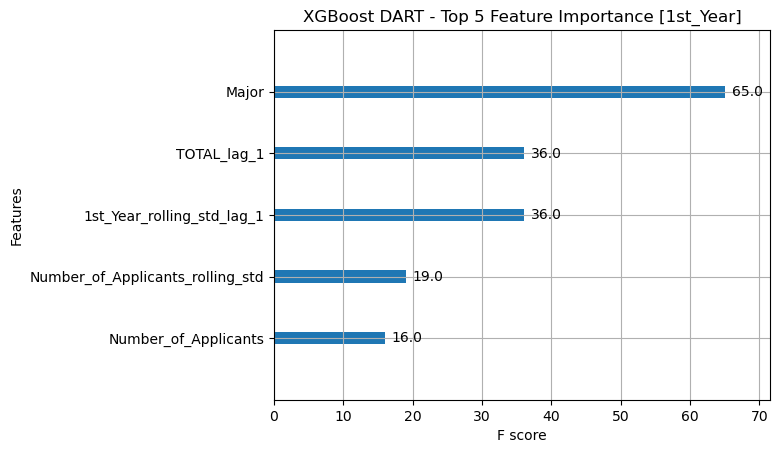

In [70]:
# plot importance for top 8 features
xgb.plot_importance(xgb_model, max_num_features=5)
plt.title(f'XGBoost DART - Top 5 Feature Importance [{year_level}]')
plt.show()

In [21]:
import shap

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_xgb_train)

shap.summary_plot(shap_values, X_xgb_train, plot_type="bar")


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:Major: category

### Save Model

In [621]:
# xgb_model_5 = xgb_model

In [625]:
# xgb_models = {
#     "1st_Year": xgb_model_1,
#     "2nd_Year": xgb_model_2,
#     "3rd_Year": xgb_model_3,
#     "4th_Year": xgb_model_4,
# }

In [636]:
# Save model
joblib.dump(xgb_model, "angeliteforecast/models/xgb_model.pkl")


['angeliteforecast/models/xgb_models.pkl']

## Random Forest (scikit-learn)

In [54]:
# best_rf_params = {'n_estimators': 331,
# 'max_depth': 10,
# 'min_samples_split': 2,
# 'min_samples_leaf': 1,
# 'max_features': 'sqrt',
# 'criterion': 'friedman_mse',
# }


In [55]:
# best_rf_params = {'n_estimators': 149, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'criterion': 'friedman_mse'}


In [19]:
# INFLATION RATE INCLUDED | ROLLING LAG STEPS = 1
from sklearn.ensemble import RandomForestRegressor


X_rf_train = X_train.drop(columns=["Major", 'Start_Month']) 
X_rf_test = X_test.drop(columns=["Major", 'Start_Month'])



# print(trial.params)
# trial = study.best_trial
rf_model = RandomForestRegressor(**best_rf_params, random_state=42, oob_score=True)
rf_model.fit(X_rf_train, y_train)

print(year_level)
print("Trained Random Forest Model")
print("OOB Score:", rf_model.oob_score_)

print("-"*50)  
print("Random Forest")
print("-"*50)

print("TEST")
test_predictions = rf_model.predict(X_rf_test)
modelresults(y_test, test_predictions)
print("-"*50)

print("TRAIN")
train_predictions = rf_model.predict(X_rf_train)
modelresults(y_train, train_predictions)
print("-"*50)


1st_Year
Trained Random Forest Model
OOB Score: 0.8033467873381936
--------------------------------------------------
Random Forest
--------------------------------------------------
TEST
Symmetric Mean Absolute Percentage Error: 50.34%
Mean Absolute Percentage Error: 151.13%
Mean Absolute Error: 20.6174
Root Mean Squared Error: 25.9841
R2 Score: 88.9921
--------------------------------------------------
TRAIN
Symmetric Mean Absolute Percentage Error: 46.83%
Mean Absolute Percentage Error: 155.83%
Mean Absolute Error: 19.0896
Root Mean Squared Error: 35.6520
R2 Score: 87.7503
--------------------------------------------------


In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
import numpy as np
import pandas as pd

# Select the most relevant features for Random Forest, but keep SHS columns
shs_columns = [col for col in X_train.columns if 'SHS' in col]
non_shs_columns = [col for col in X_train.columns if col not in shs_columns and col not in ["Major", 'Start_Month']]

# Perform feature selection
feature_selector = SelectKBest(score_func=f_regression, k=5)  # You can adjust k as needed
X_selected = feature_selector.fit_transform(X_train[non_shs_columns], y_train)

# Get the names of the selected features
selected_feature_indices = feature_selector.get_support(indices=True)
rf_selected_feature_names = list(X_train[non_shs_columns].columns[selected_feature_indices])

# Add SHS columns to the selected features
rf_selected_feature_names.extend(shs_columns)

# Create new dataframes with selected features and SHS columns
X_rf_train = X_train[rf_selected_feature_names]
X_rf_test = X_test[rf_selected_feature_names]

# Train the Random Forest model
rf_model = RandomForestRegressor(**best_rf_params, random_state=42)
rf_model.fit(X_rf_train, y_train)

print("Trained Random Forest Model")

# Print selected features
print("\nSelected features for Random Forest:")
print(rf_selected_feature_names)

# Calculate feature importance
importance_scores = rf_model.feature_importances_
feature_importance = pd.DataFrame({'feature': rf_selected_feature_names, 'importance': importance_scores})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nTop 10 most important features:")
print(feature_importance.head(10))

# Make predictions
train_predictions = rf_model.predict(X_rf_train)
test_predictions = rf_model.predict(X_rf_test)

# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score

rmse_train = np.sqrt(mean_squared_error(y_train, train_predictions))
r2_train = r2_score(y_train, train_predictions)
rmse_test = np.sqrt(mean_squared_error(y_test, test_predictions))
r2_test = r2_score(y_test, test_predictions)

print("\nModel Performance:")
print(f"Train RMSE: {rmse_train:.4f}")
print(f"Train R2: {r2_train:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")
print(f"Test R2: {r2_test:.4f}")

# Define additional evaluation metrics
def smape(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true) / ((np.abs(y_true) + np.abs(y_pred)) / 2)) * 100

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate additional metrics
smape_train = smape(y_train, train_predictions)
mape_train = mape(y_train, train_predictions)
smape_test = smape(y_test, test_predictions)
mape_test = mape(y_test, test_predictions)

print("\nAdditional Metrics:")
print(f"Train SMAPE: {smape_train:.4f}%")
print(f"Train MAPE: {mape_train:.4f}%")
print(f"Test SMAPE: {smape_test:.4f}%")
print(f"Test MAPE: {mape_test:.4f}%")

Trained Random Forest Model

Selected features for Random Forest:
['Number_of_Applicants_lag_1', 'Previous_Semester', '1st_Year_rolling_std_lag_1', 'TOTAL_lag_1', 'Percentage_Distribution_lag_1', 'SHS-ABM_lag_1', 'SHS-GenAcad_lag_1', 'SHS-HUMSS_lag_1', 'SHS-STEM_lag_1', 'SHS-TVL-HE_lag_1', 'SHS-TVL-ICT_lag_1']

Top 10 most important features:
                         feature  importance
4  Percentage_Distribution_lag_1    0.348800
1              Previous_Semester    0.282484
3                    TOTAL_lag_1    0.213784
2     1st_Year_rolling_std_lag_1    0.110314
0     Number_of_Applicants_lag_1    0.026318
6              SHS-GenAcad_lag_1    0.005333
9               SHS-TVL-HE_lag_1    0.003528
5                  SHS-ABM_lag_1    0.003097
7                SHS-HUMSS_lag_1    0.003092
8                 SHS-STEM_lag_1    0.002070

Model Performance:
Train RMSE: 22.3445
Train R2: 0.9488
Test RMSE: 25.1596
Test R2: 0.8953

Additional Metrics:
Train SMAPE: 33.7742%
Train MAPE: 81.1007%
Test

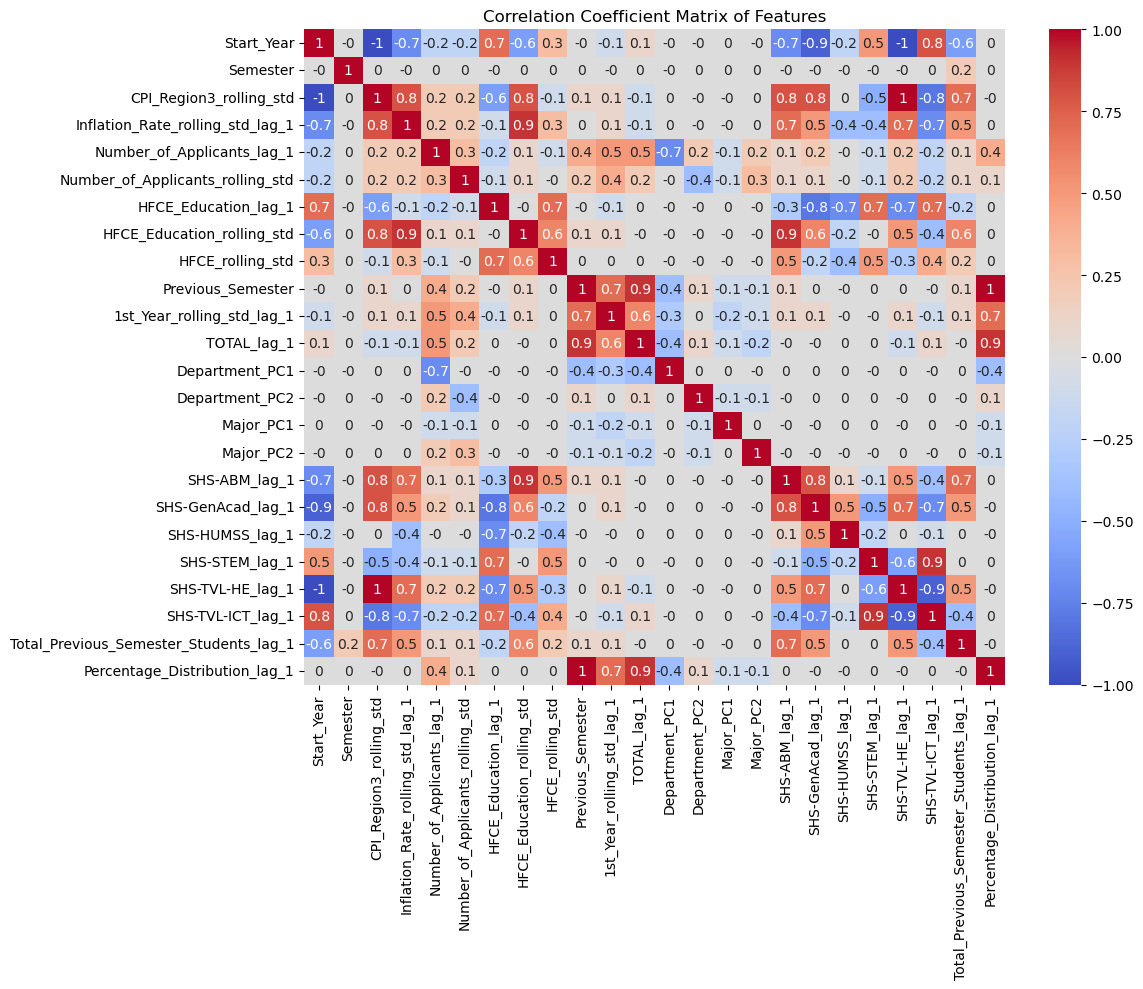

Correlation Coefficient Matrix:
                                        Start_Year  Semester  \
Start_Year                                     1.0      -0.0   
Semester                                      -0.0       1.0   
CPI_Region3_rolling_std                       -1.0       0.0   
Inflation_Rate_rolling_std_lag_1              -0.7      -0.0   
Number_of_Applicants_lag_1                    -0.2       0.0   
Number_of_Applicants_rolling_std              -0.2       0.0   
HFCE_Education_lag_1                           0.7      -0.0   
HFCE_Education_rolling_std                    -0.6       0.0   
HFCE_rolling_std                               0.3       0.0   
Previous_Semester                             -0.0       0.0   
1st_Year_rolling_std_lag_1                    -0.1      -0.0   
TOTAL_lag_1                                    0.1       0.0   
Department_PC1                                -0.0      -0.0   
Department_PC2                                -0.0       0.0   
Major_PC

In [43]:
# Calculate correlation coefficient matrix for X_rf_train
correlation_matrix = X_train.drop(columns=["Major", "Start_Month"]).corr().round(1)

# Plot heatmap of correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Coefficient Matrix of Features')
plt.tight_layout()
plt.show()

# Print the correlation matrix
print("Correlation Coefficient Matrix:")
print(correlation_matrix)

# Identify highly correlated features
high_correlation_threshold = 0.8
high_corr_features = np.where(np.abs(correlation_matrix) > high_correlation_threshold)
high_corr_features = [(correlation_matrix.index[x], correlation_matrix.columns[y]) for x, y in zip(*high_corr_features) if x != y and x < y]

print("\nHighly correlated feature pairs (correlation > 0.8):")
for feat1, feat2 in high_corr_features:
    corr_value = correlation_matrix.loc[feat1, feat2]
    print(f"{feat1} - {feat2}: {corr_value:.2f}")


In [425]:
X_train.columns

Index(['Start_Year', 'Semester', 'Major', 'Start_Month',
       'CPI_Region3_rolling_std', 'Inflation_Rate_rolling_std_lag_1',
       'Number_of_Applicants_lag_1', 'Number_of_Applicants_rolling_std',
       'HFCE_Education_lag_1', 'HFCE_Education_rolling_std',
       'Previous_Semester', '1st_Year_rolling_std_lag_1', 'Department_PC1',
       'Department_PC2', 'Major_PC1', 'Major_PC2', 'SHS-ABM_lag_1',
       'SHS-GenAcad_lag_1', 'SHS-HUMSS_lag_1', 'SHS-STEM_lag_1',
       'SHS-TVL-HE_lag_1', 'SHS-TVL-ICT_lag_1',
       'Total_Previous_Semester_Students_lag_1',
       'Percentage_Distribution_lag_1'],
      dtype='object')

### Metrics

In [23]:
print("-"*50)  
print("Random Forest")
print("-"*50)

print("TEST")
test_predictions = rf_model.predict(X_rf_test)
modelresults(y_test, test_predictions)
print("-"*50)

print("TRAIN")
train_predictions = rf_model.predict(X_rf_train)
modelresults(y_train, train_predictions)
print("-"*50)

--------------------------------------------------
Random Forest
--------------------------------------------------
TEST


NameError: name 'rf_model' is not defined

### Cross Validation

In [136]:
def rf_time_series_cv(rf_model, X, y, split_by='semester', start_year=2019, silent=True):
    cv_results = []
    
    # Filter data for years >= start_year
    mask = X['Start_Year'] >= start_year
    X = X[mask].reset_index(drop=True)
    y = y[mask].reset_index(drop=True)
    
    splits = custom_time_series_split(X, y, split_by)
    
    for split_index, (train_index, test_index) in enumerate(splits):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Get the time range for this split
        train_start = X_train['Start_Year'].min()
        train_end = X_train['Start_Year'].max()
        test_year = X_test['Start_Year'].iloc[0]
        if split_by == 'semester':
            train_start_sem = X_train.loc[X_train['Start_Year'] == train_start, 'Semester'].min()
            train_end_sem = X_train.loc[X_train['Start_Year'] == train_end, 'Semester'].max()
            test_sem = X_test['Semester'].iloc[0]
            time_range = f"{train_start}-{train_start_sem} to {train_end}-{train_end_sem}, Test: {test_year}-{test_sem}"
        else:
            time_range = f"{train_start} to {train_end}, Test: {test_year}"
        
        # Prepare data for Random Forest
        X_rf_train = X_train.drop(columns=["Major", 'Start_Month'])
        X_rf_test = X_test.drop(columns=["Major", 'Start_Month'])
        
        # Train the model
        rf_model.fit(X_rf_train, y_train)
        
        # Make predictions
        y_pred = rf_model.predict(X_rf_test)
        
        # Calculate metrics for this split using modelresults function
        metrics = modelresults(y_test, y_pred, silent=True)
        
        cv_results.append({
            'split': split_index,
            'time_range': time_range,
            'oob_score': rf_model.oob_score_,
            **metrics,
            'y_true': y_test,
            'y_pred': y_pred
        })
        
        if not silent:
            print(f"Split: {time_range}")
            print(f"OOB Score: {rf_model.oob_score_:.4f}")
            print(f"SMAPE: {metrics['smape']:.2f}%")
            print(f"MAPE: {metrics['mape']:.2f}%")
            print(f"MAE: {metrics['mae']:.4f}")
            print(f"RMSE: {metrics['rmse']:.4f}")
            print(f"R^2: {metrics['r2']*100:.4f}%")
            print("-" * 40)
    
    return cv_results

# Modify the custom_time_series_split function to ensure minimum training size
def custom_time_series_split(X, y, split_by='semester'):
    if split_by.lower() == 'semester':
        unique_times = X[['Start_Year', 'Semester']].drop_duplicates().sort_values(['Start_Year', 'Semester']).values
    elif split_by.lower() == 'year':
        unique_times = sorted(X['Start_Year'].unique())
    else:
        raise ValueError("split_by must be either 'semester' or 'year'")

    splits = []
    min_train_size = 2  # Minimum number of time periods for training

    for i in range(min_train_size, len(unique_times)):
        if split_by == 'semester':
            train_mask = (X['Start_Year'] < unique_times[i][0]) | ((X['Start_Year'] == unique_times[i][0]) & (X['Semester'] < unique_times[i][1]))
            test_mask = (X['Start_Year'] == unique_times[i][0]) & (X['Semester'] == unique_times[i][1])
        else:  # year
            train_mask = X['Start_Year'] < unique_times[i]
            test_mask = X['Start_Year'] == unique_times[i]
        
        train_indices = X[train_mask].index
        test_indices = X[test_mask].index
        splits.append((train_indices, test_indices))
    
    return splits

# Usage
rf_model = RandomForestRegressor(**best_rf_params, random_state=42, oob_score=True)
cv_results = rf_time_series_cv(rf_model, X, y, split_by='year', start_year=2019, silent=False)

# Calculate average metrics across all splits
avg_oob = np.mean([result['oob_score'] for result in cv_results])
avg_smape = np.mean([result['smape'] for result in cv_results])
avg_mape = np.mean([result['mape'] for result in cv_results])
avg_mae = np.mean([result['mae'] for result in cv_results])
avg_rmse = np.mean([result['rmse'] for result in cv_results])
avg_r2 = np.mean([result['r2'] for result in cv_results])

print("\nAverage metrics across all splits:")
print(f"Average OOB Score: {avg_oob:.4f}")
print(f"Average SMAPE: {avg_smape:.2f}%")
print(f"Average MAPE: {avg_mape:.2f}%")
print(f"Average MAE: {avg_mae:.4f}")
print(f"Average RMSE: {avg_rmse:.4f}")
print(f"Average R^2: {avg_r2*100:.4f}%")

Split: 2019 to 2020, Test: 2021
OOB Score: 0.8440
SMAPE: 56.42%
MAPE: 230.97%
MAE: 17.1874
RMSE: 23.1911
R^2: 93.9040%
----------------------------------------


Split: 2019 to 2021, Test: 2022
OOB Score: 0.8912
SMAPE: 35.20%
MAPE: 65.93%
MAE: 11.0215
RMSE: 16.9998
R^2: 96.1214%
----------------------------------------
Split: 2019 to 2022, Test: 2023
OOB Score: 0.9126
SMAPE: 43.28%
MAPE: 122.60%
MAE: 16.0888
RMSE: 24.5012
R^2: 87.9753%
----------------------------------------
Split: 2019 to 2023, Test: 2024
OOB Score: 0.9172
SMAPE: 39.02%
MAPE: 94.40%
MAE: 16.0038
RMSE: 23.5753
R^2: 90.8049%
----------------------------------------

Average metrics across all splits:
Average OOB Score: 0.8912
Average SMAPE: 43.48%
Average MAPE: 128.48%
Average MAE: 15.0754
Average RMSE: 22.0668
Average R^2: 92.2014%


### SHAP / Feature Importance

[0.00156159 0.0004145  0.00138236 0.00075609 0.03598042 0.01300634
 0.00054013 0.0007575  0.00135311 0.00061965 0.2808713  0.07442087
 0.21091412 0.01507443 0.01357424 0.03949152 0.01950511 0.00108887
 0.00216159 0.00128818 0.0008684  0.00140592 0.00051017 0.00204701
 0.28040659]
Top 5 Most Important Features:
1. Previous_Semester: 0.2809
2. Percentage_Distribution_lag_1: 0.2804
3. TOTAL_lag_1: 0.2109
4. 1st_Year_rolling_std_lag_1: 0.0744
5. Major_PC1: 0.0395

Random Forest with Top 5 Features - Test Set Metrics:
Symmetric Mean Absolute Percentage Error: 42.16%
Mean Absolute Percentage Error: 92.65%
Mean Absolute Error: 17.1561
Root Mean Squared Error: 25.2073
R2 Score: 0.8949


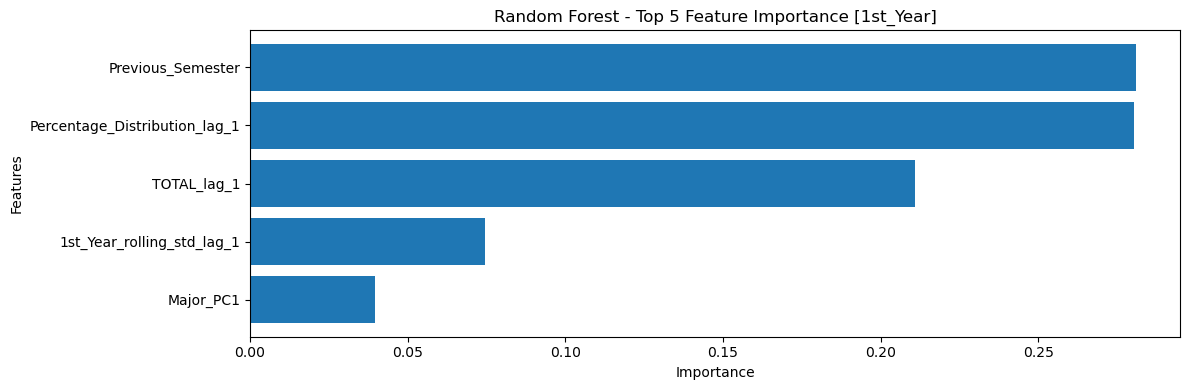

In [134]:
# Get feature importances
importances = rf_model.feature_importances_
print(importances)
# Sort features by importance
feature_importance = pd.DataFrame({'feature': X_rf_train.columns, 'importance': importances})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Get top 5 features
top_5_features = feature_importance.head(5)

print("Top 5 Most Important Features:")
for i, (feature, importance) in enumerate(zip(top_5_features['feature'], top_5_features['importance']), 1):
    print(f"{i}. {feature}: {importance:.4f}")

# Select top 5 features
top_5_feature_names = top_5_features['feature'].tolist()

# Refit Random Forest with top 5 features
X_rf_train_top5 = X_rf_train[top_5_feature_names]
X_rf_test_top5 = X_rf_test[top_5_feature_names]

rf_model_top5 = RandomForestRegressor(**best_rf_params)
rf_model_top5.fit(X_rf_train_top5, y_train)

# Make predictions
y_rf_pred_top5 = rf_model_top5.predict(X_rf_test_top5)

# Calculate metrics
mape_top5 = mape(y_test, y_rf_pred_top5)
smape_top5 = smape(y_test, y_rf_pred_top5)
mae_top5 = mean_absolute_error(y_test, y_rf_pred_top5)
rmse_top5 = np.sqrt(mean_squared_error(y_test, y_rf_pred_top5))
r2_top5 = r2_score(y_test, y_rf_pred_top5)

print("\nRandom Forest with Top 5 Features - Test Set Metrics:")
print(f"Symmetric Mean Absolute Percentage Error: {smape_top5:.2f}%")
print(f"Mean Absolute Percentage Error: {mape_top5:.2f}%")
print(f"Mean Absolute Error: {mae_top5:.4f}")
print(f"Root Mean Squared Error: {rmse_top5:.4f}")
print(f"R2 Score: {r2_top5:.4f}")

# Visualize top 5 features
plt.figure(figsize=(12, 4))
plt.barh(top_5_features['feature'][::-1], top_5_features['importance'][::-1])
plt.title(f'Random Forest - Top 5 Feature Importance [{year_level}]')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


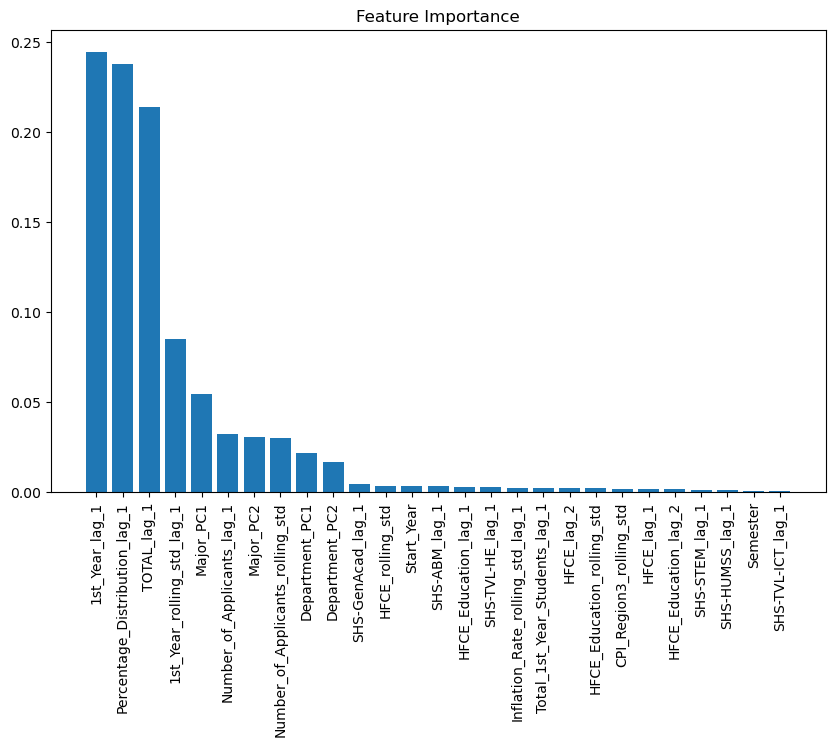

In [12]:
# Plot rf featuer importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X_rf_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_rf_train.shape[1]), X_rf_train.columns[indices], rotation=90)
plt.title('Feature Importance')
plt.show()



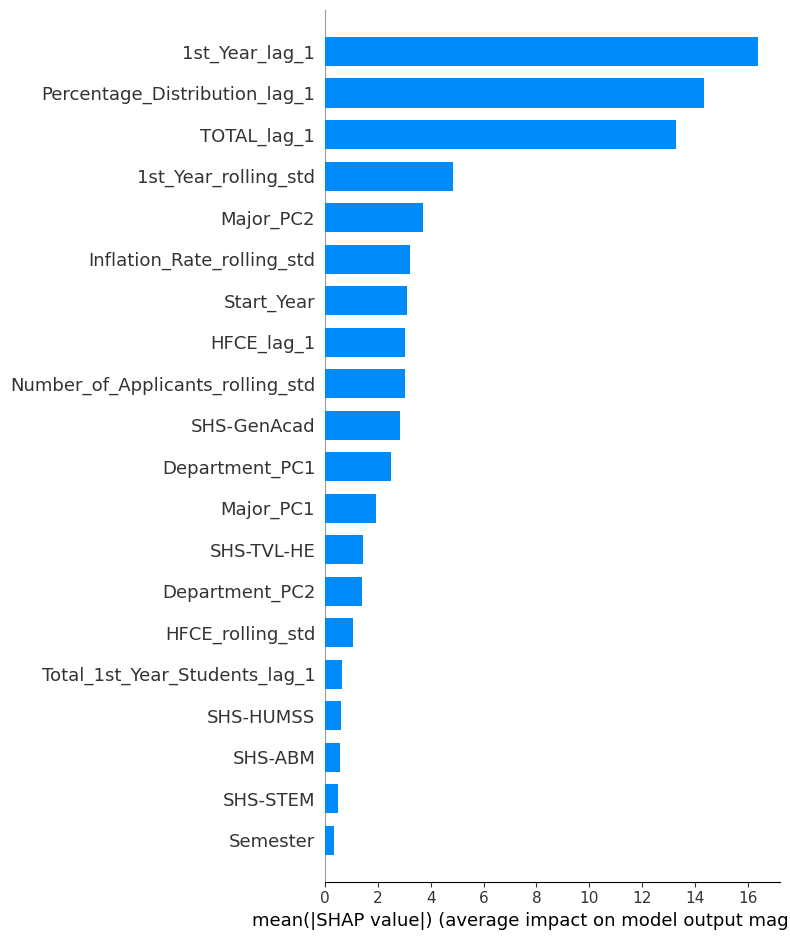

In [ ]:
import shap

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_rf_train)

shap.summary_plot(shap_values, X_rf_train, plot_type="bar")


### Save Model

In [637]:
import joblib

# Save the model as a pickle in a file
joblib.dump(rf_model, "angeliteforecast/models/rf_model.pkl")

['angeliteforecast/models/rf_models.pkl']

In [624]:
rf_model_5 = rf_model

In [626]:
# rf_models = {
#     "1st_Year": rf_model_1,
#     "2nd_Year": rf_model_2,
#     "3rd_Year": rf_model_3,
#     "4th_Year": rf_model_4,
# }

## Exponential Smoothing

### Simple

In [20]:
from statsmodels.tsa.api import SimpleExpSmoothing 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Create dictionaries to store the models, predictions, and errors for each major
models = {}
test_preds = {}
train_preds = {}
test_rmse = {}
train_rmse = {}
test_mae = {}
train_mae = {}
test_r2 = {}
train_r2 = {}

train_true_values = []
train_pred_values = []
test_true_values = []
test_pred_values = []

steps = 1

# Iterate over each unique major
for major in finalDf_copy['Major'].unique():
    # Filter the data for the current major
    major_data = finalDf_copy[finalDf_copy['Major'] == major]
    
    # Get the training and test sets for the current major
    X_major_train = X_train[X_train['Major'] == major].reset_index(drop=True)
    y_major_train = y_train[X_train['Major'] == major].reset_index(drop=True)
    
    X_major_test = X_test[X_test['Major'] == major].reset_index(drop=True)
    y_major_test = y_test[X_test['Major'] == major].reset_index(drop=True)
    
    try:
        # Ensure the training data has enough points
        if len(y_major_train) < 2 or y_major_train.sum() < 10:
            print(f"Skipping major {major} due to insufficient data points.")
            continue
        
        # Fit the Simple Exponential Smoothing model
        model = SimpleExpSmoothing(y_major_train, initialization_method="estimated").fit(smoothing_level=0.6, optimized=True, use_brute=True)
        models[major] = model
    except ValueError as e:
        print(f'Major: {major} - {e}')
        continue
    
    # Make predictions on the training data
    y_major_train_pred = model.fittedvalues
    train_preds[major] = y_major_train_pred
    
    # Ensure the test data follows the training data chronologically
    if len(y_major_train) < 2 or y_major_train.sum() < 10:
        print(f"Skipping major {major} due to insufficient data points.")
        continue
    else:
        test_start_idx = len(y_major_train)  # Start index should be right after the training data
        test_end_idx = test_start_idx + len(y_major_test) - 1  # End index for the test data


        train_rmse[major] = np.sqrt(mean_squared_error(y_major_train, y_major_train_pred))
        train_mae[major] = mean_absolute_error(y_major_train, y_major_train_pred)
        train_r2[major] = r2_score(y_major_train, y_major_train_pred)
        
        # Evaluate the model
        print(f'Major: {major}')
        print(f'Training MSE: {train_rmse[major]:.4f}')
        print(f'Training MAE: {train_mae[major]:.4f}')
        print(f'Training R^2: {train_r2[major]:.4f}')
        print(y_major_test)
        if len(y_major_test) > 0:
            
            steps = len(y_major_test)
            # Make predictions on the test data
            y_major_test_pred = model.forecast(steps=steps)
            test_preds[major] = y_major_test_pred
            
            if len(y_major_test) != len(y_major_test_pred):
                print(f"Major: {major} - Test data and predictions have different lengths.")
                print(test_true_values, test_pred_values)
                continue
            else:
                        
                train_true_values.extend(y_major_train)
                train_pred_values.extend(y_major_train_pred)
                test_true_values.extend(y_major_test)
                test_pred_values.extend(y_major_test_pred)

            if len(y_major_test) > 1:
                test_rmse[major] = np.sqrt(mean_squared_error(y_major_test, y_major_test_pred))
                test_mae[major] = mean_absolute_error(y_major_test, y_major_test_pred)
                test_r2[major] = r2_score(y_major_test, y_major_test_pred)
                print(f'Test MSE: {test_rmse[major]:.4f}')
                print(f'Test MAE: {test_mae[major]:.4f}')
                print(f'Test R^2: {test_r2[major]:.4f}')
            else:
                # Print residual
                print(f'Test Residual: {y_major_test - y_major_test_pred}')

            print('-----------------------------------------')
            
display("Trained Simple Exponential Smoothing Model")

Major: Accountancy
Training MSE: 103.4553
Training MAE: 101.5828
Training R^2: 0.1561
0    353
Name: 1st_Year, dtype: int32
Test Residual: 0   NaN
5   NaN
dtype: float64
-----------------------------------------
Major: Architecture
Training MSE: 47.9971
Training MAE: 42.6885
Training R^2: -0.7410
0    153
Name: 1st_Year, dtype: int32
Test Residual: 0   NaN
5   NaN
dtype: float64
-----------------------------------------
Major: BA Comm
Training MSE: 31.1419
Training MAE: 29.1800
Training R^2: -0.2534
0    53
Name: 1st_Year, dtype: int32
Test Residual: 0   NaN
5   NaN
dtype: float64
-----------------------------------------
Major: BEEd
Training MSE: 5.0833
Training MAE: 4.2024
Training R^2: -0.6313
0    9
Name: 1st_Year, dtype: int32
Test Residual: 0   NaN
5   NaN
dtype: float64
-----------------------------------------
Major: BS Criminology
Training MSE: 16.7519
Training MAE: 15.2731
Training R^2: -0.6562
0    46
Name: 1st_Year, dtype: int32
Test Residual: 0   NaN
5   NaN
dtype: float64

'Trained Simple Exponential Smoothing Model'

### Metrics

In [21]:
train_true_values = np.array(train_true_values)
train_pred_values = np.array(train_pred_values)
test_true_values = np.array(test_true_values)
test_pred_values = np.array(test_pred_values)

print(year_level)
print('-'*50)
print('Simple Exponential Smoothing')
print('-'*50)


print("TEST")
modelresults(test_true_values, test_pred_values)
print('-'*50)


print("TRAIN")
modelresults(train_true_values, train_pred_values)
print('-'*50)



1st_Year
--------------------------------------------------
Simple Exponential Smoothing
--------------------------------------------------
TEST
Symmetric Mean Absolute Percentage Error: 38.44%
Mean Absolute Percentage Error: 58.84%
Mean Absolute Error: 15.4504
Root Mean Squared Error: 21.7869
R2 Score: 92.2611
--------------------------------------------------
TRAIN
Symmetric Mean Absolute Percentage Error: 33.95%
Mean Absolute Percentage Error: 49.52%
Mean Absolute Error: 19.0407
Root Mean Squared Error: 31.3149
R2 Score: 91.0531
--------------------------------------------------


### Cross Validation

In [137]:
from statsmodels.tsa.api import SimpleExpSmoothing
import numpy as np
import pandas as pd

def ses_time_series_cv(X, y, split_by='semester', start_year=2019, silent=True):
    cv_results = []
    
    # Filter data for years >= start_year
    mask = X['Start_Year'] >= start_year
    X = X[mask].reset_index(drop=True)
    y = y[mask].reset_index(drop=True)
    
    splits = custom_time_series_split(X, y, split_by)
    
    for split_index, (train_index, test_index) in enumerate(splits):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Get the time range for this split
        train_start = X_train['Start_Year'].min()
        train_end = X_train['Start_Year'].max()
        test_year = X_test['Start_Year'].iloc[0]
        if split_by == 'semester':
            train_start_sem = X_train.loc[X_train['Start_Year'] == train_start, 'Semester'].min()
            train_end_sem = X_train.loc[X_train['Start_Year'] == train_end, 'Semester'].max()
            test_sem = X_test['Semester'].iloc[0]
            time_range = f"{train_start}-{train_start_sem} to {train_end}-{train_end_sem}, Test: {test_year}-{test_sem}"
        else:
            time_range = f"{train_start} to {train_end}, Test: {test_year}"
        
        y_true_all = []
        y_pred_all = []
        
        for major in X_train['Major'].unique():
            X_major_train = X_train[X_train['Major'] == major].reset_index(drop=True)
            y_major_train = y_train[X_train['Major'] == major].reset_index(drop=True)
            
            X_major_test = X_test[X_test['Major'] == major].reset_index(drop=True)
            y_major_test = y_test[X_test['Major'] == major].reset_index(drop=True)
            
            if len(y_major_train) < 2 or y_major_train.sum() < 10 or len(X_major_test) == 0:
                continue
            
            # Fit the Simple Exponential Smoothing model
            model = SimpleExpSmoothing(y_major_train, initialization_method="estimated").fit(smoothing_level=0.6, optimized=True, use_brute=True)
            
            # Make predictions
            y_major_test_pred = model.forecast(steps=len(y_major_test))
            
            y_true_all.extend(y_major_test)
            y_pred_all.extend(y_major_test_pred)
        
        # Calculate metrics for this split using modelresults function
        metrics = modelresults(np.array(y_true_all), np.array(y_pred_all), silent=True)
        
        cv_results.append({
            'split': split_index,
            'time_range': time_range,
            **metrics,
            'y_true': y_true_all,
            'y_pred': y_pred_all
        })
        
        if not silent:
            print(f"Split: {time_range}")
            print(f"SMAPE: {metrics['smape']:.2f}%")
            print(f"MAPE: {metrics['mape']:.2f}%")
            print(f"MAE: {metrics['mae']:.4f}")
            print(f"RMSE: {metrics['rmse']:.4f}")
            print(f"R^2: {metrics['r2']*100:.4f}%")
            print("-" * 40)
    
    return cv_results

# Modify the custom_time_series_split function to ensure minimum training size
def custom_time_series_split(X, y, split_by='semester'):
    if split_by.lower() == 'semester':
        unique_times = X[['Start_Year', 'Semester']].drop_duplicates().sort_values(['Start_Year', 'Semester']).values
    elif split_by.lower() == 'year':
        unique_times = sorted(X['Start_Year'].unique())
    else:
        raise ValueError("split_by must be either 'semester' or 'year'")

    splits = []
    min_train_size = 2  # Minimum number of time periods for training

    for i in range(min_train_size, len(unique_times)):
        if split_by == 'semester':
            train_mask = (X['Start_Year'] < unique_times[i][0]) | ((X['Start_Year'] == unique_times[i][0]) & (X['Semester'] < unique_times[i][1]))
            test_mask = (X['Start_Year'] == unique_times[i][0]) & (X['Semester'] == unique_times[i][1])
        else:  # year
            train_mask = X['Start_Year'] < unique_times[i]
            test_mask = X['Start_Year'] == unique_times[i]
        
        train_indices = X[train_mask].index
        test_indices = X[test_mask].index
        splits.append((train_indices, test_indices))
    
    return splits

# Usage
cv_results = ses_time_series_cv(X, y, split_by='year', start_year=2019, silent=False)

# Calculate average metrics across all splits
avg_smape = np.mean([result['smape'] for result in cv_results])
avg_mape = np.mean([result['mape'] for result in cv_results])
avg_mae = np.mean([result['mae'] for result in cv_results])
avg_rmse = np.mean([result['rmse'] for result in cv_results])
avg_r2 = np.mean([result['r2'] for result in cv_results])

print("\nAverage metrics across all splits:")
print(f"Average SMAPE: {avg_smape:.2f}%")
print(f"Average MAPE: {avg_mape:.2f}%")
print(f"Average MAE: {avg_mae:.4f}")
print(f"Average RMSE: {avg_rmse:.4f}")
print(f"Average R^2: {avg_r2*100:.4f}%")

Split: 2019 to 2020, Test: 2021
SMAPE: 38.90%
MAPE: 57.28%
MAE: 18.1371
RMSE: 28.8028
R^2: 91.1787%
----------------------------------------


d:\Kent\Programs\miniconda3\envs\enrollment\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1412: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
d:\Kent\Programs\miniconda3\envs\enrollment\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1418: RuntimeWarning: invalid value encountered in scalar add
  aicc = aic + aicc_penalty
d:\Kent\Programs\miniconda3\envs\enrollment\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1419: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)
d:\Kent\Programs\miniconda3\envs\enrollment\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1412: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
d:\Kent\Programs\miniconda3\envs\enrollment\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1418: RuntimeWarning: invalid value encountered in scalar add
  aicc = aic 

Split: 2019 to 2021, Test: 2022
SMAPE: 35.13%
MAPE: 33.67%
MAE: 13.0057
RMSE: 18.8092
R^2: 95.3133%
----------------------------------------
Split: 2019 to 2022, Test: 2023
SMAPE: 39.09%
MAPE: 55.02%
MAE: 22.0564
RMSE: 34.6006
R^2: 76.3818%
----------------------------------------
Split: 2019 to 2023, Test: 2024
SMAPE: 39.89%
MAPE: 61.70%
MAE: 14.8668
RMSE: 22.3832
R^2: 91.7113%
----------------------------------------

Average metrics across all splits:
Average SMAPE: 38.25%
Average MAPE: 51.92%
Average MAE: 17.0165
Average RMSE: 26.1489
Average R^2: 88.6463%


### Save Model

In [136]:
import joblib

# Save models
joblib.dump(models, "models/final/ses_models.pkl")

['models/final/ses_models.pkl']

## Moving Average

In [133]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Create dictionaries to store the predictions and errors for each major
train_preds = {}
test_preds = {}
train_rmse = {}
test_rmse = {}
train_mae = {}
test_mae = {}
train_r2 = {}
test_r2 = {}

train_true_values = []
train_pred_values = []
test_true_values = []
test_pred_values = []

# Set the window size for the moving average
window_size = 4  # You can adjust this value

# Iterate over each unique major
for major in finalDf_copy['Major'].unique():
    # Filter the data for the current major
    major_data = finalDf_copy[finalDf_copy['Major'] == major]
    
    # Get the training and test sets for the current major
    y_major_train = y_train[X_train['Major'] == major].reset_index(drop=True)
    y_major_test = y_test[X_test['Major'] == major].reset_index(drop=True)
    
    try:
        # Ensure we have enough data points for the moving average
        if len(y_major_train) < window_size:
            print(f"Warning: Not enough data points for moving average for {major}. Using all available data.")
            window_size = len(y_major_train)
            
        if len(y_major_train) < 2 or y_major_train.sum() < 10:
            print(f"Skipping major {major} due to insufficient data points.")
            continue
        # Calculate moving average for training data
        y_major_train_pred = pd.Series(y_major_train).rolling(window=window_size, min_periods=1).mean().values
        train_preds[major] = y_major_train_pred
        
        train_true_values.extend(y_major_train)
        train_pred_values.extend(y_major_train_pred)

        train_rmse[major] = np.sqrt(mean_squared_error(y_major_train, y_major_train_pred))
        train_mae[major] = mean_absolute_error(y_major_train, y_major_train_pred)
        train_r2[major] = r2_score(y_major_train, y_major_train_pred)
        
        # Evaluate the model
        print(f'Major: {major}')
        print(f'Training RMSE: {train_rmse[major]:.4f}')
        print(f'Training MAE: {train_mae[major]:.4f}')
        print(f'Training R^2: {train_r2[major]:.4f}')

        if len(y_major_test) > 0:
            # Calculate moving average for test data (forecasting)
            last_window = y_major_train[-window_size:]
            y_major_test_pred = np.full(len(y_major_test), last_window.mean())
            test_preds[major] = y_major_test_pred
            
            test_true_values.extend(y_major_test)
            test_pred_values.extend(y_major_test_pred)

            if len(y_major_test) > 1:
                test_rmse[major] = np.sqrt(mean_squared_error(y_major_test, y_major_test_pred))
                test_mae[major] = mean_absolute_error(y_major_test, y_major_test_pred)
                test_r2[major] = r2_score(y_major_test, y_major_test_pred)
                print(f'Test RMSE: {test_rmse[major]:.4f}')
                print(f'Test MAE: {test_mae[major]:.4f}')
                print(f'Test R^2: {test_r2[major]:.4f}')
            else:
                # Print residual
                print(f'Test Residual: {y_major_test.values[0] - y_major_test_pred[0]}')

    except ValueError as e:
        print(f'Major: {major} - {e}')
        continue

    print('-----------------------------------------')
            
print("Trained Moving Average Model")

Major: Accountancy
Training RMSE: 55.8942
Training MAE: 47.8750
Training R^2: 0.7518
Test Residual: -17.75
-----------------------------------------
Major: Architecture
Training RMSE: 34.2070
Training MAE: 28.1750
Training R^2: 0.2573
Test Residual: -15.5
-----------------------------------------
Major: BA Comm
Training RMSE: 17.1368
Training MAE: 13.5250
Training R^2: 0.5172
Test Residual: -6.75
-----------------------------------------
Major: BEEd
Training RMSE: 5.2740
Training MAE: 4.2833
Training R^2: 0.1386
Test Residual: -4.25
-----------------------------------------
Major: BS Criminology
Training RMSE: 12.9099
Training MAE: 10.1833
Training R^2: 0.2016
Test Residual: -14.25
-----------------------------------------
Skipping major BSAcctgInfoSys due to insufficient data points.
Major: BSAeronautical
Training RMSE: 34.4232
Training MAE: 26.7333
Training R^2: 0.8418
Test Residual: 35.333333333333314
-----------------------------------------
Skipping major BSBA HRDM due to insuffic

### Metrics

In [134]:
train_true_values = np.array(train_true_values)
train_pred_values = np.array(train_pred_values)
test_true_values = np.array(test_true_values)
test_pred_values = np.array(test_pred_values)


print(year_level)
print('-'*50)
print('Moving Average (2-Years / 4-Semesters)')
print('-'*50)


print("TEST")
modelresults(test_true_values, test_pred_values)
print('-'*50)


print("TRAIN")
modelresults(train_true_values, train_pred_values)
print('-'*50)



1st_Year
--------------------------------------------------
Moving Average (2-Years / 4-Semesters)
--------------------------------------------------
TEST
Symmetric Mean Absolute Percentage Error: 43.61%
Mean Absolute Percentage Error: 64.45%
Mean Absolute Error: 16.6865
Root Mean Squared Error: 24.1865
R2 Score: 90.3219
--------------------------------------------------
TRAIN
Symmetric Mean Absolute Percentage Error: 2.20%
Mean Absolute Percentage Error: 2.41%
Mean Absolute Error: 2.9926
Root Mean Squared Error: 11.6856
R2 Score: 98.6077
--------------------------------------------------


## Linear

In [121]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
X_lr_train = X_train.drop(columns=["Major", 'Start_Month'])
X_lr_test = X_test.drop(columns=["Major", 'Start_Month'])
# Train the linear regression model
lr_model.fit(X_lr_train, y_train)

# Make predictions on training data
y_train_pred = lr_model.predict(X_lr_train)
y_test_pred = lr_model.predict(X_lr_test)

print(year_level)
print('-'*50)

print("Linear Regression")
print('-'*50)
print("TEST")
modelresults(y_test, y_test_pred)
print('-'*50)


print("TRAIN")
modelresults(y_train, y_train_pred)
print('-'*50)



1st_Year
--------------------------------------------------
Linear Regression
--------------------------------------------------
TEST
Symmetric Mean Absolute Percentage Error: 132.85%
Mean Absolute Percentage Error: 1846.22%
Mean Absolute Error: 176.9753
Root Mean Squared Error: 179.0640
R2 Score: -430.4680
--------------------------------------------------
TRAIN
Symmetric Mean Absolute Percentage Error: 46.02%
Mean Absolute Percentage Error: 86.08%
Mean Absolute Error: 11.0574
Root Mean Squared Error: 19.8366
R2 Score: 95.9683
--------------------------------------------------


In [22]:
train_preds = X_train[["Major"]].copy()
test_preds = X_test[["Major"]].copy()

train_preds["pred"] = y_train_pred
test_preds["pred"] = y_test_pred

train_preds = {major: train_preds[train_preds["Major"] == major]["pred"].to_list() for major in X_train["Major"].unique()}
test_preds = {major: test_preds[test_preds["Major"] == major]["pred"].to_list() for major in X_test["Major"].unique()}


In [122]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Create dictionaries to store the models, predictions, and errors for each major
lr_models = {}
test_preds = {}
train_preds = {}
test_rmse = {}
train_rmse = {}
test_mae = {}
train_mae = {}
test_r2 = {}
train_r2 = {}

train_true_values = []
train_pred_values = []
test_true_values = []
test_pred_values = []

X_train_linear = X_train # .drop(columns=[col for col in X_train.columns if 'std' in col])
X_test_linear = X_test # .drop(columns=[col for col in X_train.columns if 'std' in col])

# Iterate over each unique major
for major in finalDf_copy['Major'].unique():
    # Filter the data for the current major
    major_data = finalDf_copy[finalDf_copy['Major'] == major]
    
    # Get the training and test sets for the current major
    X_major_train = X_train_linear[X_train_linear['Major'] == major].drop(columns=['Major', 'Start_Month']).reset_index(drop=True)
    y_major_train = y_train[X_train_linear['Major'] == major].reset_index(drop=True)
    
    X_major_test = X_test_linear[X_test_linear['Major'] == major].drop(columns=['Major', 'Start_Month']).reset_index(drop=True)
    y_major_test = y_test[X_test_linear['Major'] == major].reset_index(drop=True)
    
    try:
        # Ensure the training data has enough points
        if len(y_major_train) < 2 or y_major_train.sum() < 10:
            print(f"Skipping major {major} due to insufficient data points.")
            continue
        
        # Fit the Linear Regression model
        model = LinearRegression()
        model.fit(X_major_train, y_major_train)
        lr_models[major] = model
    except ValueError as e:
        print(f'Major: {major} - {e}')
        continue
    
    # Make predictions on the training data
    y_major_train_pred = model.predict(X_major_train)
    train_preds[major] = y_major_train_pred
    
    train_true_values.extend(y_major_train)
    train_pred_values.extend(y_major_train_pred)

    train_rmse[major] = np.sqrt(mean_squared_error(y_major_train, y_major_train_pred))
    train_mae[major] = mean_absolute_error(y_major_train, y_major_train_pred)
    train_r2[major] = r2_score(y_major_train, y_major_train_pred)
    
    # Evaluate the model
    print(f'Major: {major}')
    print(f'Training RMSE: {train_rmse[major]:.4f}')
    print(f'Training MAE: {train_mae[major]:.4f}')
    print(f'Training R^2: {train_r2[major]:.4f}')

    if len(y_major_test) > 0:
        # Make predictions on the test data
        y_major_test_pred = model.predict(X_major_test)
        test_preds[major] = y_major_test_pred
        
        test_true_values.extend(y_major_test)
        test_pred_values.extend(y_major_test_pred)

        if len(y_major_test) > 1:
            test_rmse[major] = np.sqrt(mean_squared_error(y_major_test, y_major_test_pred))
            test_mae[major] = mean_absolute_error(y_major_test, y_major_test_pred)
            test_r2[major] = r2_score(y_major_test, y_major_test_pred)
            print(f'Test RMSE: {test_rmse[major]:.4f}')
            print(f'Test MAE: {test_mae[major]:.4f}')
            print(f'Test R^2: {test_r2[major]:.4f}')
        else:
            # Print residual
            print(f'Test Residual: {y_major_test.values[0] - y_major_test_pred[0]}')

    print('-----------------------------------------')
            
display("Trained Linear Regression Model")


Major: Accountancy
Training RMSE: 0.0000
Training MAE: 0.0000
Training R^2: 1.0000
Test Residual: 88.81696861181865
-----------------------------------------
Major: Architecture
Training RMSE: 0.0000
Training MAE: 0.0000
Training R^2: 1.0000
Test Residual: -14.23154146954434
-----------------------------------------
Major: BA Comm
Training RMSE: 0.0000
Training MAE: 0.0000
Training R^2: 1.0000
Test Residual: -314.27501350734167
-----------------------------------------
Major: BEEd
Training RMSE: 0.0000
Training MAE: 0.0000
Training R^2: 1.0000
Test Residual: -4.373379735347584
-----------------------------------------
Major: BS Criminology
Training RMSE: 0.0000
Training MAE: 0.0000
Training R^2: 1.0000
Test Residual: -175.42101515082072
-----------------------------------------
Skipping major BSAcctgInfoSys due to insufficient data points.
Major: BSAeronautical
Training RMSE: 0.0000
Training MAE: 0.0000
Training R^2: 1.0000
Test Residual: -336.2911596154595
----------------------------

'Trained Linear Regression Model'

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

def lr_time_series_cv(X, y, split_by='semester', start_year=2019, silent=True):
    cv_results = []
    
    # Filter data for years >= start_year
    mask = X['Start_Year'] >= start_year
    X = X[mask].reset_index(drop=True)
    y = y[mask].reset_index(drop=True)
    
    splits = custom_time_series_split(X, y, split_by)
    
    for split_index, (train_index, test_index) in enumerate(splits):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Get the time range for this split
        train_start = X_train['Start_Year'].min()
        train_end = X_train['Start_Year'].max()
        test_year = X_test['Start_Year'].iloc[0]
        if split_by == 'semester':
            train_start_sem = X_train.loc[X_train['Start_Year'] == train_start, 'Semester'].min()
            train_end_sem = X_train.loc[X_train['Start_Year'] == train_end, 'Semester'].max()
            test_sem = X_test['Semester'].iloc[0]
            time_range = f"{train_start}-{train_start_sem} to {train_end}-{train_end_sem}, Test: {test_year}-{test_sem}"
        else:
            time_range = f"{train_start} to {train_end}, Test: {test_year}"
        
        y_true_all = []
        y_pred_all = []
        
        for major in X_train['Major'].unique():
            X_major_train = X_train[X_train['Major'] == major].drop(columns=['Major', 'Start_Month']).reset_index(drop=True)
            y_major_train = y_train[X_train['Major'] == major].reset_index(drop=True)
            
            X_major_test = X_test[X_test['Major'] == major].drop(columns=['Major', 'Start_Month']).reset_index(drop=True)
            y_major_test = y_test[X_test['Major'] == major].reset_index(drop=True)
            
            if len(y_major_train) < 2 or y_major_train.sum() < 10 or len(X_major_test) == 0:
                continue
            
            # Fit the Linear Regression model
            model = LinearRegression()
            model.fit(X_major_train, y_major_train)
            
            # Make predictions
            y_major_test_pred = model.predict(X_major_test)
            
            y_true_all.extend(y_major_test)
            y_pred_all.extend(y_major_test_pred)
        
        # Calculate metrics for this split using modelresults function
        metrics = modelresults(np.array(y_true_all), np.array(y_pred_all), silent=True)
        
        cv_results.append({
            'split': split_index,
            'time_range': time_range,
            **metrics,
            'y_true': y_true_all,
            'y_pred': y_pred_all
        })
        
        if not silent:
            print(f"Split: {time_range}")
            print(f"SMAPE: {metrics['smape']:.2f}%")
            print(f"MAPE: {metrics['mape']:.2f}%")
            print(f"MAE: {metrics['mae']:.4f}")
            print(f"RMSE: {metrics['rmse']:.4f}")
            print(f"R^2: {metrics['r2']*100:.4f}%")
            print("-" * 40)
    
    return cv_results

# Usage
cv_results = lr_time_series_cv(X, y, split_by='year', start_year=2019, silent=False)

# Calculate average metrics across all splits
avg_smape = np.mean([result['smape'] for result in cv_results])
avg_mape = np.mean([result['mape'] for result in cv_results])
avg_mae = np.mean([result['mae'] for result in cv_results])
avg_rmse = np.mean([result['rmse'] for result in cv_results])
avg_r2 = np.mean([result['r2'] for result in cv_results])

print("\nAverage metrics across all splits:")
print(f"Average SMAPE: {avg_smape:.2f}%")
print(f"Average MAPE: {avg_mape:.2f}%")
print(f"Average MAE: {avg_mae:.4f}")
print(f"Average RMSE: {avg_rmse:.4f}")
print(f"Average R^2: {avg_r2*100:.4f}%")

NameError: name 'X' is not defined

### Metrics

In [123]:
train_true_values = np.array(train_true_values)
train_pred_values = np.array(train_pred_values)
test_true_values = np.array(test_true_values)
test_pred_values = np.array(test_pred_values)


print(year_level)
print('-'*50)
print('Linear Regression')
print('-'*50)


print("TEST")
modelresults(test_true_values, test_pred_values)
print('-'*50)


print("TRAIN")
modelresults(train_true_values, train_pred_values)
print('-'*50)



1st_Year
--------------------------------------------------
Linear Regression
--------------------------------------------------
TEST
Symmetric Mean Absolute Percentage Error: 90.97%
Mean Absolute Percentage Error: 424.15%
Mean Absolute Error: 69.8297
Root Mean Squared Error: 108.1412
R2 Score: -93.4750
--------------------------------------------------
TRAIN
Symmetric Mean Absolute Percentage Error: 0.00%
Mean Absolute Percentage Error: 0.00%
Mean Absolute Error: 0.0000
Root Mean Squared Error: 0.0000
R2 Score: 100.0000
--------------------------------------------------


### Cross Validation

### Feature Importance
Permutation

### Save Model

In [159]:
print(lr_models)

{'Accountancy': LinearRegression(), 'Architecture': LinearRegression(), 'BA Comm': LinearRegression(), 'BEEd': LinearRegression(), 'BS Criminology': LinearRegression(), 'BSAeronautical': LinearRegression(), 'BSBA-MktgMgmt': LinearRegression(), 'BSBALegal': LinearRegression(), 'BSCompsci': LinearRegression(), 'BSCulinary': LinearRegression(), 'BSED-RelValEd': LinearRegression(), 'BSEMC-DA': LinearRegression(), 'BSHRM': LinearRegression(), 'BSITNetAdmin': LinearRegression(), 'BSITWebdev': LinearRegression(), 'BSNEd': LinearRegression(), 'BSNursing': LinearRegression(), 'BSPsychology': LinearRegression(), 'BSRadTech': LinearRegression(), 'BSTM-Events': LinearRegression(), 'BSTourism': LinearRegression(), 'BusMgt': LinearRegression(), 'CE': LinearRegression(), "Comp. Eng'g.": LinearRegression(), 'ELECENG': LinearRegression(), 'English-BSED': LinearRegression(), 'IE': LinearRegression(), 'ME': LinearRegression(), 'Math': LinearRegression(), 'SocialStud-BSED': LinearRegression(), 'BSTM-Trave

In [629]:
lr_models_5 = lr_models

In [630]:
# lr_models_dict = {
#     "1st_Year": lr_models_1,
#     "2nd_Year": lr_models_2,
#     "3rd_Year": lr_models_3,
#     "4th_Year": lr_models_4,
# }

In [638]:
joblib.dump(lr_models, "angeliteforecast/models/lr_models.pkl")

['angeliteforecast/models/lr_models.pkl']

In [183]:
finalDf[finalDf["Major"] == "BEED-MajSPED"]


Empty DataFrame
Columns: [Start_Year, Semester, Major, Department, 1st_Year, 2nd_Year, 3rd_Year, 4th_Year, 5th_Year, Grade_12, TOTAL, Start_Month, CPI_Region3_rolling_std, Inflation_Rate_rolling_std_lag_1, Number_of_Applicants_lag_1, Number_of_Applicants_rolling_std, HFCE_Education_lag_1, HFCE_Education_lag_2, HFCE_Education_rolling_std, HFCE_lag_1, HFCE_lag_2, HFCE_rolling_std, 1st_Year_lag_1, 1st_Year_rolling_std_lag_1, TOTAL_lag_1, Department_PC1, Department_PC2, Major_PC1, Major_PC2, SHS-ABM_lag_1, SHS-GenAcad_lag_1, SHS-HUMSS_lag_1, SHS-STEM_lag_1, SHS-TVL-HE_lag_1, SHS-TVL-ICT_lag_1, Total_1st_Year_Students_lag_1, Percentage_Distribution_lag_1]
Index: []

[0 rows x 37 columns]

## KNN

In [55]:
# Import necessary libraries
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# # Select the most relevant features for KNN, but keep SHS columns
# shs_columns = [col for col in X_train.columns if 'SHS' in col]
# non_shs_columns = [col for col in X_train.columns if col not in shs_columns and col not in ["Major", 'Start_Month']]

# feature_selector = SelectKBest(score_func=f_regression, k=10)
# X_selected = feature_selector.fit_transform(X_train[non_shs_columns], y_train)

# # Get the names of the selected features
# selected_feature_indices = feature_selector.get_support(indices=True)
# selected_feature_names = list(X_train[non_shs_columns].columns[selected_feature_indices])

# # Add SHS columns to the selected features
# selected_feature_names.extend(shs_columns)

# Create new dataframes with selected features and SHS columns
X_knn_train = X_train.drop(columns=["Major", 'Start_Month'])
X_knn_test = X_test.drop(columns=["Major", 'Start_Month'])


# Initialize time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Define parameter grid for GridSearchCV
param_grid = {
    'n_neighbors': range(1,10),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Initialize KNN regressor
knn = KNeighborsRegressor()

# Perform GridSearchCV with time series cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_knn_train, y_train)

# Get the best model
best_knn_model = grid_search.best_estimator_

# Print best parameters
print("Best parameters:", grid_search.best_params_)

# Evaluate the model
print("-"*50)
print("KNN")
print("-"*50)

print("TEST")
test_predictions = best_knn_model.predict(X_knn_test)
# test_predictions = scaler.inverse_transform(test_predictions)
modelresults(y_test, test_predictions)
print("-"*50)

print("TRAIN")
train_predictions = best_knn_model.predict(X_knn_train)
# train_predictions = scaler.inverse_transform(train_predictions)
modelresults(y_train, train_predictions)
print("-"*50)

# print("Selected features for KNN:", selected_feature_names)



Best parameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
--------------------------------------------------
KNN
--------------------------------------------------
TEST
Symmetric Mean Absolute Percentage Error: 50.89%
Mean Absolute Percentage Error: 121.43%
Mean Absolute Error: 26.1137
Root Mean Squared Error: 52.1269
R2 Score: 56.0471
--------------------------------------------------
TRAIN
Symmetric Mean Absolute Percentage Error: 0.00%
Mean Absolute Percentage Error: 0.00%
Mean Absolute Error: 0.0000
Root Mean Squared Error: 0.0000
R2 Score: 100.0000
--------------------------------------------------


In [124]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
knn_params = {'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}

# Create new dataframes with selected features and SHS columns
X_knn_train = X_train.drop(columns=["Major", 'Start_Month'])
X_knn_test = X_test.drop(columns=["Major", 'Start_Month'])

# X_knn_train = X_train.drop(columns=["Major", 'Start_Month', 'TOTAL_lag_2'])
# X_knn_test = X_test.drop(columns=["Major", 'Start_Month', 'TOTAL_lag_2'])
# Initialize time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)
# Initialize KNN regressor
knn_model = KNeighborsRegressor(**knn_params)


# # Perform time series cross-validation
# for train_index, val_index in tscv.split(X_knn_train):
#     X_train_cv, X_val_cv = X_knn_train.iloc[train_index], X_knn_train.iloc[val_index]
#     y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
#     knn_model.fit(X_train_cv, y_train_cv)
#     # Evaluate the model
#     print("-"*50)
#     print("KNN")
#     print("-"*50)

#     print("TEST")
#     test_predictions = knn_model.predict(X_knn_test)
#     modelresults(y_test, test_predictions)
#     print("-"*50)

#     print("TRAIN")
#     train_predictions = knn_model.predict(X_knn_train)
#     modelresults(y_train, train_predictions)
#     print("-"*50)

# Final fit on the entire training set
knn_model.fit(X_knn_train, y_train)

print(year_level)

# Evaluate the model
print("-"*50)
print("KNN")
print("-"*50)

print("TEST")
test_predictions = knn_model.predict(X_knn_test)
modelresults(y_test, test_predictions)
print("-"*50)

print("TRAIN")
train_predictions = knn_model.predict(X_knn_train)
modelresults(y_train, train_predictions)
print("-"*50)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

# Calculate metrics for test and train sets
test_rmse, test_mae, test_r2 = calculate_metrics(y_test, test_predictions)
train_rmse, train_mae, train_r2 = calculate_metrics(y_train, train_predictions)



1st_Year
--------------------------------------------------
KNN
--------------------------------------------------
TEST
Symmetric Mean Absolute Percentage Error: 41.89%
Mean Absolute Percentage Error: 60.56%
Mean Absolute Error: 18.6585
Root Mean Squared Error: 31.9820
R2 Score: 83.0779
--------------------------------------------------
TRAIN
Symmetric Mean Absolute Percentage Error: 0.00%
Mean Absolute Percentage Error: 0.00%
Mean Absolute Error: 0.0000
Root Mean Squared Error: 0.0000
R2 Score: 100.0000
--------------------------------------------------


### Cross Validation

In [93]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

def knn_time_series_cv(X, y, knn_params, split_by='semester', start_year=2019, silent=True):
    cv_results = []
    
    # Filter data for years >= start_year
    mask = X['Start_Year'] >= start_year
    X = X[mask].reset_index(drop=True)
    y = y[mask].reset_index(drop=True)
    
    splits = custom_time_series_split(X, y, split_by)
    
    for split_index, (train_index, test_index) in enumerate(splits):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Get the time range for this split
        train_start = X_train['Start_Year'].min()
        train_end = X_train['Start_Year'].max()
        test_year = X_test['Start_Year'].iloc[0]
        if split_by == 'semester':
            train_start_sem = X_train.loc[X_train['Start_Year'] == train_start, 'Semester'].min()
            train_end_sem = X_train.loc[X_train['Start_Year'] == train_end, 'Semester'].max()
            test_sem = X_test['Semester'].iloc[0]
            time_range = f"{train_start}-{train_start_sem} to {train_end}-{train_end_sem}, Test: {test_year}-{test_sem}"
        else:
            time_range = f"{train_start} to {train_end}, Test: {test_year}"
        
        # Prepare data for KNN
        X_knn_train = X_train.drop(columns=["Major", 'Start_Month'])
        X_knn_test = X_test.drop(columns=["Major", 'Start_Month'])
        
        # Scale the features
        scaler = StandardScaler()
        X_knn_train_scaled = scaler.fit_transform(X_knn_train)
        X_knn_test_scaled = scaler.transform(X_knn_test)
        
        # Train the model
        knn_model = KNeighborsRegressor(**knn_params)
        knn_model.fit(X_knn_train_scaled, y_train)
        
        # Make predictions
        y_pred = knn_model.predict(X_knn_test_scaled)
        
        # Calculate metrics for this split using modelresults function
        metrics = modelresults(y_test, y_pred, silent=True)
        
        cv_results.append({
            'split': split_index,
            'time_range': time_range,
            **metrics,
            'y_true': y_test,
            'y_pred': y_pred
        })
        
        if not silent:
            print(f"Split: {time_range}")
            print(f"SMAPE: {metrics['smape']:.2f}%")
            print(f"MAPE: {metrics['mape']:.2f}%")
            print(f"MAE: {metrics['mae']:.4f}")
            print(f"RMSE: {metrics['rmse']:.4f}")
            print(f"R^2: {metrics['r2']*100:.4f}%")
            print("-" * 40)
    
    return cv_results

# Usage
knn_params = {'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}
cv_results = knn_time_series_cv(X, y, knn_params, split_by='year', start_year=2019, silent=False)

# Calculate average metrics across all splits
avg_smape = np.mean([result['smape'] for result in cv_results])
avg_mape = np.mean([result['mape'] for result in cv_results])
avg_mae = np.mean([result['mae'] for result in cv_results])
avg_rmse = np.mean([result['rmse'] for result in cv_results])
avg_r2 = np.mean([result['r2'] for result in cv_results])

print("\nAverage metrics across all splits:")
print(f"Average SMAPE: {avg_smape:.2f}%")
print(f"Average MAPE: {avg_mape:.2f}%")
print(f"Average MAE: {avg_mae:.4f}")
print(f"Average RMSE: {avg_rmse:.4f}")
print(f"Average R^2: {avg_r2*100:.4f}%")

Split: 2019 to 2020, Test: 2021
SMAPE: 48.76%
MAPE: 79.95%
MAE: 20.4733
RMSE: 33.7983
R^2: 87.0522%
----------------------------------------
Split: 2019 to 2021, Test: 2022
SMAPE: 40.51%
MAPE: 62.97%
MAE: 14.8956
RMSE: 21.6548
R^2: 93.7064%
----------------------------------------
Split: 2019 to 2022, Test: 2023
SMAPE: 45.69%
MAPE: 104.11%
MAE: 16.5923
RMSE: 23.6975
R^2: 88.7513%
----------------------------------------
Split: 2019 to 2023, Test: 2024
SMAPE: 51.26%
MAPE: 109.91%
MAE: 21.7342
RMSE: 30.2364
R^2: 84.8747%
----------------------------------------

Average metrics across all splits:
Average SMAPE: 46.56%
Average MAPE: 89.24%
Average MAE: 18.4238
Average RMSE: 27.3468
Average R^2: 88.5961%


### Save Model

In [632]:
knn_model_5 = knn_model

In [633]:
# knn_models = {
#     "1st_Year": knn_model_1,
#     "2nd_Year": knn_model_2,
#     "3rd_Year": knn_model_3,
#     "4th_Year": knn_model_4,
# }

In [639]:
joblib.dump(best_knn_model, "angeliteforecast/models/knn_model.pkl")

['angeliteforecast/models/knn_models.pkl']

## Ensemble (DART + RF + SES)

In [2]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import joblib  # Assuming you saved the models using joblib


best_svr_params = {'C': 99.88053508969807, 'epsilon': 0.01, 'gamma': 0.001008583301608898, 'max_iter': 840}
svr_model = SVR(**best_svr_params)

def ensemble_models(rf_model, xgb_model, svr_model, X_train, 
                    X_test, y_train, y_test, weight_ses=0.2, weight_rf=0.3, weight_xgb=0.5, weight_svr=0., silent=True):
    scaler = StandardScaler()

    # Ensure the weights sum to 1
    total_weight = weight_ses + weight_rf + weight_xgb + weight_svr
    weight_ses /= total_weight
    weight_rf /= total_weight
    weight_xgb /= total_weight
    weight_svr /= total_weight
    
    # Create dictionaries to store the models, predictions, and errors for each major
    models = {}
    test_preds = {}
    train_preds = {}
    test_rmse = {}
    train_rmse = {}
    test_mae = {}
    train_mae = {}
    test_r2 = {}
    train_r2 = {}

    train_true_values = []
    train_pred_values = []
    test_true_values = []
    test_pred_values = []
    retained_majors = []

    # Iterate over each unique major
    for major in X_train['Major'].unique():
        # Filter the data for the current major
        major_data = finalDf_copy[finalDf_copy['Major'] == major]
        
        # Get the training and test sets for the current major
        X_major_train = X_train[X_train['Major'] == major].reset_index(drop=True)
        y_major_train = y_train[X_train['Major'] == major].reset_index(drop=True)
        
        X_major_test = X_test[X_test['Major'] == major].reset_index(drop=True)
        y_major_test = y_test[X_test['Major'] == major].reset_index(drop=True)
        
        try:
            # Ensure the training data has enough points
            if len(y_major_train) < 2 or y_major_train.sum() < 10:
                print(f"Skipping major {major} due to insufficient data points.") if not silent else None
                continue
            
        except ValueError as e:
            print(f'Major: {major} - {e}') if not silent else None
            continue
        
        if len(X_major_train) == 0 or len(X_major_test) == 0:
            print(f"Skipping major {major} due to empty training or test set.") if not silent else None
            continue

        # Scale the features
        X_major_train_scaled = scaler.fit_transform(X_major_train.drop(columns=["Major", 'Start_Month']))
        X_major_test_scaled = scaler.transform(X_major_test.drop(columns=["Major", 'Start_Month']))
        
        if not silent:
            # Evaluate the model
            print(f'Major: {major}')
            print(f'Training MSE: {train_rmse[major]:.4f}')
            print(f'Training MAE: {train_mae[major]:.4f}')
            print(f'Training R^2: {train_r2[major]:.4f}')

        if len(y_major_test) >= 1:
            # Fit the Simple Exponential Smoothing model
            ses_model = SimpleExpSmoothing(y_major_train, initialization_method="estimated").fit(smoothing_level=0.6, optimized=True, use_brute=True)
                        
            # Train SVR model outside the function
            # svr_model = SVR(kernel='rbf', C=100000, epsilon=.01, max_iter=300).fit(X_major_train_scaled, y_major_train)
            models[major] = {'ses': ses_model,
                             'svr': svr_model}

            dtrain = xgb.DMatrix(X_major_train.drop(columns=['Start_Month']), label=y_major_train, enable_categorical=True)
            dtest = xgb.DMatrix(X_major_test.drop(columns=['Start_Month']), enable_categorical=True)
            
            # Make predictions on the training data
            y_major_train_pred_ses = ses_model.fittedvalues
            y_major_train_pred_rf = rf_model.predict(X_major_train.drop(columns=["Major", 'Start_Month']))
            y_major_train_pred_xgb = xgb_model.predict(dtrain)
            # y_major_train_pred_svr = svr_model.predict(X_major_train_scaled)
            
            # Combine predictions using weights
            y_major_train_pred = (weight_ses * y_major_train_pred_ses + 
                                weight_rf * y_major_train_pred_rf + 
                                weight_xgb * y_major_train_pred_xgb 
                                # weight_svr * y_major_train_pred_svr
                                )
            train_preds[major] = y_major_train_pred
            
            train_rmse[major] = np.sqrt(mean_squared_error(y_major_train, y_major_train_pred))
            train_mae[major] = mean_absolute_error(y_major_train, y_major_train_pred)
            train_r2[major] = r2_score(y_major_train, y_major_train_pred)
                    
            # Make predictions on the test data
            steps = len(y_major_test)
            y_major_test_pred_ses = ses_model.forecast(steps=steps)
            y_major_test_pred_rf = rf_model.predict(X_major_test.drop(columns=["Major", 'Start_Month']))
            y_major_test_pred_xgb = xgb_model.predict(dtest)
            # y_major_test_pred_svr = svr_model.predict(X_major_test_scaled)
            
            # Combine predictions using weights
            y_major_test_pred = (weight_ses * y_major_test_pred_ses + 
                                 weight_rf * y_major_test_pred_rf + 
                                 weight_xgb * y_major_test_pred_xgb 
                                #  weight_svr * y_major_test_pred_svr
                                 )
            test_preds[major] = y_major_test_pred
            
            if len(y_major_test) != len(y_major_test_pred):
                if not silent:
                    print(f"Major: {major} - Test data and predictions have different lengths.")
                    print(test_true_values, test_pred_values)
                continue
            else:
                train_true_values.extend(y_major_train)
                train_pred_values.extend(y_major_train_pred)
                test_true_values.extend(y_major_test)
                test_pred_values.extend(y_major_test_pred)

            if len(y_major_test) > 1:
                test_rmse[major] = np.sqrt(mean_squared_error(y_major_test, y_major_test_pred))
                test_mae[major] = mean_absolute_error(y_major_test, y_major_test_pred)
                test_r2[major] = r2_score(y_major_test, y_major_test_pred)
                if not silent:
                    print(f'Test MSE: {test_rmse[major]:.4f}')
                    print(f'Test MAE: {test_mae[major]:.4f}')
                    print(f'Test R^2: {test_r2[major]:.4f}')
            else:
                # Print residual
                print(f'Test Residual: {y_major_test - y_major_test_pred}') if not silent else None

            print('-----------------------------------------') if not silent else None
        retained_majors.append(major)
    # print((weight_ses * y_major_test_pred_ses + 
    #                              weight_rf * y_major_test_pred_rf + 
    #                              weight_xgb * y_major_test_pred_xgb +
    #                              weight_svr * y_major_test_pred_svr))
    return models, train_true_values, train_pred_values, train_preds, test_true_values, test_pred_values, test_preds, retained_majors

models, train_true_values, train_pred_values, train_preds, test_true_values, test_pred_values, test_preds, retained_majors = ensemble_models(rf_model, xgb_model, svr_model, X_train, X_test, y_train, y_test)
display("Trained Ensemble Model")

NameError: name 'rf_model' is not defined

In [92]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
import joblib  # Assuming you saved the models using joblib

def ensemble_models(weight_ses=0.3, weight_rf=0.4, weight_xgb=0.3, silent=True):
    # Ensure the weights sum to 1
    total_weight = weight_ses + weight_rf + weight_xgb
    weight_ses /= total_weight
    weight_rf /= total_weight
    weight_xgb /= total_weight
    
    # Create dictionaries to store the models, predictions, and errors for each major
    models = {}
    test_preds = {}
    train_preds = {}
    test_rmse = {}
    train_rmse = {}
    test_mae = {}
    train_mae = {}
    test_r2 = {}
    train_r2 = {}

    train_true_values = []
    train_pred_values = []
    test_true_values = []
    test_pred_values = []

    steps = 1

    # Iterate over each unique major
    for major in finalDf_copy['Major'].unique():
        # Filter the data for the current major
        major_data = finalDf_copy[finalDf_copy['Major'] == major]
        
        # Get the training and test sets for the current major
        X_major_train = X_train[X_train['Major'] == major].reset_index(drop=True)
        y_major_train = y_train[X_train['Major'] == major].reset_index(drop=True)
        
        X_major_test = X_test[X_test['Major'] == major].reset_index(drop=True)
        y_major_test = y_test[X_test['Major'] == major].reset_index(drop=True)
        
        try:
            # Ensure the training data has enough points
            if len(y_major_train) < 2 or y_major_train.sum() < 10:
                print(f"Skipping major {major} due to insufficient data points.") if not silent else None
                continue
            
            # Fit the Simple Exponential Smoothing model
            ses_model = SimpleExpSmoothing(y_major_train).fit(smoothing_level=0.8, optimized=False)
            models[major] = {'ses': ses_model}
        except ValueError as e:
            print(f'Major: {major} - {e}') if not silent else None
            continue

        # Train the RandomForest model
        rf_model = RandomForestRegressor()
        rf_model.fit(X_major_train.drop(columns=["Major", 'Start_Month', 'TOTAL_lag_2']), y_major_train)
        models[major]['rf'] = rf_model

        # Train the XGBoost model
        xgb_model = XGBRegressor()
        xgb_model.fit(X_major_train.drop(columns=["Major", 'Start_Month', 'TOTAL_lag_2']), y_major_train)
        models[major]['xgb'] = xgb_model

        # Make predictions on the training data
        y_major_train_pred_ses = ses_model.fittedvalues
        y_major_train_pred_rf = rf_model.predict(X_major_train.drop(columns=["Major", 'Start_Month', 'TOTAL_lag_2']))
        y_major_train_pred_xgb = xgb_model.predict(X_major_train.drop(columns=["Major", 'Start_Month', 'TOTAL_lag_2']))
        
        # Combine predictions using weights
        y_major_train_pred = (weight_ses * y_major_train_pred_ses + 
                            weight_rf * y_major_train_pred_rf + 
                            weight_xgb * y_major_train_pred_xgb)
        train_preds[major] = y_major_train_pred
        
        # Ensure the test data follows the training data chronologically
        if len(y_major_train) < 2 or y_major_train.sum() < 10:
            print(f"Skipping major {major} due to insufficient data points.") if not silent else None
            continue
        else:
            test_start_idx = len(y_major_train)  # Start index should be right after the training data
            test_end_idx = test_start_idx + len(y_major_test) - 1  # End index for the test data

            train_true_values.extend(y_major_train)
            train_pred_values.extend(y_major_train_pred)

            train_rmse[major] = np.sqrt(mean_squared_error(y_major_train, y_major_train_pred))
            train_mae[major] = mean_absolute_error(y_major_train, y_major_train_pred)
            train_r2[major] = r2_score(y_major_train, y_major_train_pred)
            
            if not silent:
                # Evaluate the model
                print(f'Major: {major}')
                print(f'Training RMSE: {train_rmse[major]:.4f}')
                print(f'Training MAE: {train_mae[major]:.4f}')
                print(f'Training R^2: {train_r2[major]:.4f}')

            if len(y_major_test) > 0:
                # Make predictions on the test data
                y_major_test_pred_ses = ses_model.forecast(steps=steps)
                y_major_test_pred_rf = rf_model.predict(X_major_test.drop(columns=["Major", 'Start_Month', 'TOTAL_lag_2']))
                y_major_test_pred_xgb = xgb_model.predict(X_major_test.drop(columns=["Major", 'Start_Month', 'TOTAL_lag_2', ]))
                
                # Combine predictions using weights
                y_major_test_pred = (weight_ses * y_major_test_pred_ses + 
                                    weight_rf * y_major_test_pred_rf + 
                                    weight_xgb * y_major_test_pred_xgb)
                test_preds[major] = y_major_test_pred
                
                if len(y_major_test) != len(y_major_test_pred):
                    if not silent:
                        print(f"Major: {major} - Test data and predictions have different lengths.")
                        print(test_true_values, test_pred_values)
                    continue
                else:
                    test_true_values.extend(y_major_test)
                    test_pred_values.extend(y_major_test_pred)

                if len(y_major_test) > 1:
                    test_rmse[major] = np.sqrt(mean_squared_error(y_major_test, y_major_test_pred))
                    test_mae[major] = mean_absolute_error(y_major_test, y_major_test_pred)
                    test_r2[major] = r2_score(y_major_test, y_major_test_pred)
                    if not silent:
                        print(f'Test RMSE: {test_rmse[major]:.4f}')
                        print(f'Test MAE: {test_mae[major]:.4f}')
                        print(f'Test R^2: {test_r2[major]:.4f}')
                else:
                    # Print residual
                    print(f'Test Residual: {y_major_test - y_major_test_pred}') if not silent else None

                print('-----------------------------------------') if not silent else None

    return models, train_true_values, train_pred_values, train_preds, test_true_values, test_pred_values, test_preds

# Assuming X_train, y_train, X_test, y_test, and finalDf_copy are already defined
models, train_true_values, train_pred_values, train_preds, test_true_values, test_pred_values, test_preds = ensemble_models()
display("Trained Ensemble Model")

'Trained Ensemble Model'

### Metrics

In [23]:
def ensemble_metrics(train_true_values, train_pred_values, test_true_values, test_pred_values):
    train_true_values = np.array(train_true_values)
    train_pred_values = np.array(train_pred_values)
    test_true_values = np.array(test_true_values)
    test_pred_values = np.array(test_pred_values)
    print('-'*75)
    print('Ensemble (Simple Exponential Smoothing + Random Forest + XGBoost DART)')
    print('-'*75)


    print("TEST")
    modelresults(test_true_values, test_pred_values)
    print('-'*75)


    print("TRAIN")
    modelresults(train_true_values, train_pred_values)
    print('-'*75)

print(year_level)
ensemble_metrics(train_true_values, train_pred_values, test_true_values, test_pred_values)

1st_Year
---------------------------------------------------------------------------
Ensemble (Simple Exponential Smoothing + Random Forest + XGBoost DART)
---------------------------------------------------------------------------
TEST
Symmetric Mean Absolute Percentage Error: 42.80%
Mean Absolute Percentage Error: 109.38%
Mean Absolute Error: 17.5725
Root Mean Squared Error: 23.5639
R2 Score: 90.9472
---------------------------------------------------------------------------
TRAIN
Symmetric Mean Absolute Percentage Error: 29.17%
Mean Absolute Percentage Error: 54.14%
Mean Absolute Error: 12.6199
Root Mean Squared Error: 23.0810
R2 Score: 95.1395
---------------------------------------------------------------------------


### Cross Validation

In [101]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

def ensemble_time_series_cv(rf_model, xgb_model, X, y, split_by='semester', start_year=2019, 
                            weight_ses=0.2, weight_rf=0.5, weight_xgb=0.3, silent=True):
    cv_results = []
    scaler = StandardScaler()
    
    # Filter data for years >= start_year
    mask = X['Start_Year'] >= start_year
    X = X[mask].reset_index(drop=True)
    y = y[mask].reset_index(drop=True)
    
    splits = custom_time_series_split(X, y, split_by)
    
    for split_index, (train_index, test_index) in enumerate(splits):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Get the time range for this split
        train_start = X_train['Start_Year'].min()
        train_end = X_train['Start_Year'].max()
        test_year = X_test['Start_Year'].iloc[0]
        if split_by == 'semester':
            train_start_sem = X_train.loc[X_train['Start_Year'] == train_start, 'Semester'].min()
            train_end_sem = X_train.loc[X_train['Start_Year'] == train_end, 'Semester'].max()
            test_sem = X_test['Semester'].iloc[0]
            time_range = f"{train_start}-{train_start_sem} to {train_end}-{train_end_sem}, Test: {test_year}-{test_sem}"
        else:
            time_range = f"{train_start} to {train_end}, Test: {test_year}"
        
        y_true_all = []
        y_pred_all = []
        
        for major in X_train['Major'].unique():
            X_major_train = X_train[X_train['Major'] == major].reset_index(drop=True)
            y_major_train = y_train[X_train['Major'] == major].reset_index(drop=True)
            
            X_major_test = X_test[X_test['Major'] == major].reset_index(drop=True)
            y_major_test = y_test[X_test['Major'] == major].reset_index(drop=True)
            
            if len(y_major_train) < 2 or y_major_train.sum() < 10 or len(X_major_test) == 0:
                continue
            
            # Scale the features
            X_major_train_scaled = scaler.fit_transform(X_major_train.drop(columns=["Major", 'Start_Month']))
            X_major_test_scaled = scaler.transform(X_major_test.drop(columns=["Major", 'Start_Month']))
            
            # Fit the Simple Exponential Smoothing model
            ses_model = SimpleExpSmoothing(y_major_train, initialization_method="estimated").fit(smoothing_level=0.6, optimized=True, use_brute=True)
            
            dtrain = xgb.DMatrix(X_major_train.drop(columns=['Start_Month']), label=y_major_train, enable_categorical=True)
            dtest = xgb.DMatrix(X_major_test.drop(columns=['Start_Month']), enable_categorical=True)
            
            # Make predictions
            y_major_test_pred_ses = ses_model.forecast(steps=len(y_major_test))
            y_major_test_pred_rf = rf_model.predict(X_major_test.drop(columns=["Major", 'Start_Month']))
            y_major_test_pred_xgb = xgb_model.predict(dtest)
            
            # Combine predictions using weights
            y_major_test_pred = (weight_ses * y_major_test_pred_ses + 
                                 weight_rf * y_major_test_pred_rf + 
                                 weight_xgb * y_major_test_pred_xgb)
            
            y_true_all.extend(y_major_test)
            y_pred_all.extend(y_major_test_pred)
        
        # Calculate metrics for this split using modelresults function
        metrics = modelresults(np.array(y_true_all), np.array(y_pred_all), silent=True)
        
        cv_results.append({
            'split': split_index,
            'time_range': time_range,
            **metrics,
            'y_true': y_true_all,
            'y_pred': y_pred_all
        })
        
        if not silent:
            print(f"Split: {time_range}")
            print(f"SMAPE: {metrics['smape']:.2f}%")
            print(f"MAPE: {metrics['mape']:.2f}%")
            print(f"MAE: {metrics['mae']:.4f}")
            print(f"RMSE: {metrics['rmse']:.4f}")
            print(f"R^2: {metrics['r2']*100:.4f}%")
            print("-" * 40)
    
    return cv_results

# Usage
cv_results = ensemble_time_series_cv(rf_model, xgb_model, X, y, 
                                     split_by='year', start_year=2019, 
                                     weight_ses=0.2, weight_rf=0.3, weight_xgb=0.5, 
                                     silent=False)

# Calculate average metrics across all splits
avg_smape = np.mean([result['smape'] for result in cv_results])
avg_mape = np.mean([result['mape'] for result in cv_results])
avg_mae = np.mean([result['mae'] for result in cv_results])
avg_rmse = np.mean([result['rmse'] for result in cv_results])
avg_r2 = np.mean([result['r2'] for result in cv_results])

print("\nAverage metrics across all splits:")
print(f"Average SMAPE: {avg_smape:.2f}%")
print(f"Average MAPE: {avg_mape:.2f}%")
print(f"Average MAE: {avg_mae:.4f}")
print(f"Average RMSE: {avg_rmse:.4f}")
print(f"Average R^2: {avg_r2*100:.4f}%")

Split: 2019 to 2020, Test: 2021
SMAPE: 28.08%
MAPE: 52.57%
MAE: 8.9925
RMSE: 14.1816
R^2: 97.8615%
----------------------------------------


d:\Kent\Programs\miniconda3\envs\enrollment\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1412: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
d:\Kent\Programs\miniconda3\envs\enrollment\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1418: RuntimeWarning: invalid value encountered in scalar add
  aicc = aic + aicc_penalty
d:\Kent\Programs\miniconda3\envs\enrollment\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1419: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)
d:\Kent\Programs\miniconda3\envs\enrollment\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1412: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
d:\Kent\Programs\miniconda3\envs\enrollment\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1418: RuntimeWarning: invalid value encountered in scalar add
  aicc = aic 

Split: 2019 to 2021, Test: 2022
SMAPE: 18.43%
MAPE: 21.31%
MAE: 6.5443
RMSE: 9.9909
R^2: 98.6777%
----------------------------------------
Split: 2019 to 2022, Test: 2023
SMAPE: 33.48%
MAPE: 63.67%
MAE: 10.5736
RMSE: 15.4264
R^2: 95.3053%
----------------------------------------
Split: 2019 to 2023, Test: 2024
SMAPE: 37.59%
MAPE: 77.29%
MAE: 15.4263
RMSE: 23.5313
R^2: 90.8392%
----------------------------------------

Average metrics across all splits:
Average SMAPE: 29.40%
Average MAPE: 53.71%
Average MAE: 10.3842
Average RMSE: 15.7826
Average R^2: 95.6709%


### Save Model

In [48]:
import joblib

# Save models
joblib.dump(models, "models/final/ensembled_models.pkl")

['angeliteforecast/models/ensembled_models.pkl']

# Cross Validation

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=10)

In [36]:
def custom_time_series_split(X, y, split_by='semester', start_year=2019):
    """
    Custom time series split function.
    
    :param X: Features DataFrame
    :param y: Target Series
    :param split_by: 'semester' or 'year'
    :param start_year: The year to start the splits from
    :return: List of train and test indices for each split
    """
    # Filter data for years >= start_year
    mask = X['Start_Year'] >= start_year
    X_filtered = X[mask].reset_index(drop=True)
    y_filtered = y[mask].reset_index(drop=True)

    if split_by.lower() == 'semester':
        unique_times = X_filtered[['Start_Year', 'Semester']].drop_duplicates().sort_values(['Start_Year', 'Semester']).values
    elif split_by.lower() == 'year':
        unique_times = X_filtered['Start_Year'].unique().sort()
    else:
        raise ValueError("split_by must be either 'semester' or 'year'")

    splits = []
    min_train_size = 2  # Minimum number of time periods for training

    for i in range(min_train_size, len(unique_times)):
        if split_by == 'semester':
            train_mask = (X_filtered['Start_Year'] < unique_times[i][0]) | ((X_filtered['Start_Year'] == unique_times[i][0]) & (X_filtered['Semester'] < unique_times[i][1]))
            test_mask = (X_filtered['Start_Year'] == unique_times[i][0]) & (X_filtered['Semester'] == unique_times[i][1])
        else:  # year
            train_mask = X_filtered['Start_Year'] < unique_times[i]
            test_mask = X_filtered['Start_Year'] == unique_times[i]
        
        train_indices = X_filtered[train_mask].index
        test_indices = X_filtered[test_mask].index
        splits.append((train_indices, test_indices))
    
    return splits

def ensemble_models_cv(rf_model, xgb_model, X, y, split_by='semester', 
                       weight_ses=0.3, weight_rf=0.4, weight_xgb=0.3, start_year=2019):
    scaler = StandardScaler()
    
    # Normalize weights
    total_weight = weight_ses + weight_rf + weight_xgb
    weight_ses /= total_weight
    weight_rf /= total_weight
    weight_xgb /= total_weight
    
    cv_results = []
    
    # Filter data for years >= start_year
    mask = X['Start_Year'] >= start_year
    X_filtered = X[mask].reset_index(drop=True)
    y_filtered = y[mask].reset_index(drop=True)
    
    splits = custom_time_series_split(X_filtered, y_filtered, split_by, start_year)
    
    for split_index, (train_index, test_index) in enumerate(splits):
        X_train, X_test = X_filtered.iloc[train_index], X_filtered.iloc[test_index]
        y_train, y_test = y_filtered.iloc[train_index], y_filtered.iloc[test_index]
        
        # Get the time range for this split
        train_start = X_train['Start_Year'].min()
        train_end = X_train['Start_Year'].max()
        test_year = X_test['Start_Year'].iloc[0]
        if split_by == 'semester':
            train_start_sem = X_train.loc[X_train['Start_Year'] == train_start, 'Semester'].min()
            train_end_sem = X_train.loc[X_train['Start_Year'] == train_end, 'Semester'].max()
            test_sem = X_test['Semester'].iloc[0]
            time_range = f"{train_start}-{train_start_sem} to {train_end}-{train_end_sem}, Test: {test_year}-{test_sem}"
        else:
            time_range = f"{train_start} to {train_end}, Test: {test_year}"
        
        y_true_all = []
        y_pred_all = []
        
        for major in X_train['Major'].unique():
            X_major_train = X_train[X_train['Major'] == major].reset_index(drop=True)
            y_major_train = y_train[X_train['Major'] == major].reset_index(drop=True)
            
            X_major_test = X_test[X_test['Major'] == major].reset_index(drop=True)
            y_major_test = y_test[X_test['Major'] == major].reset_index(drop=True)
            
            if len(y_major_train) < 2 or y_major_train.sum() < 10 or len(X_major_test) == 0:
                continue
            
            X_major_train_scaled = scaler.fit_transform(X_major_train.drop(columns=["Major", 'Start_Month']))
            X_major_test_scaled = scaler.transform(X_major_test.drop(columns=["Major", 'Start_Month']))
            
            # Simple Exponential Smoothing
            ses_model = SimpleExpSmoothing(y_major_train, initialization_method="estimated").fit(smoothing_level=0.6, optimized=True, use_brute=True)
            
            # Prepare data for XGBoost
            dtrain = xgb.DMatrix(X_major_train.drop(columns=["Major", 'Start_Month']), label=y_major_train)
            dtest = xgb.DMatrix(X_major_test.drop(columns=["Major", 'Start_Month']))
            
            # Make predictions
            y_major_test_pred_ses = ses_model.forecast(steps=len(y_major_test))
            y_major_test_pred_rf = rf_model.predict(X_major_test.drop(columns=["Major", 'Start_Month']))
            y_major_test_pred_xgb = xgb_model.predict(dtest)
            
            # Combine predictions
            y_major_test_pred = (weight_ses * y_major_test_pred_ses + 
                                 weight_rf * y_major_test_pred_rf + 
                                 weight_xgb * y_major_test_pred_xgb)
            
            y_true_all.extend(y_major_test)
            y_pred_all.extend(y_major_test_pred)
        
        # Calculate metrics for this split using modelresults function
        metrics = modelresults(np.array(y_true_all), np.array(y_pred_all), silent=True)
        
        cv_results.append({
            'split': split_index,
            'time_range': time_range,
            **metrics,
            'y_true': y_true_all,
            'y_pred': y_pred_all
        })
    
        print(f"Split: {time_range}")
        print(f"SMAPE: {metrics['smape']:.2f}%")
        print(f"MAPE: {metrics['mape']:.2f}%")
        print(f"MAE: {metrics['mae']:.4f}")
        print(f"RMSE: {metrics['rmse']:.4f}")
        print(f"R^2: {metrics['r2']*100:.4f}%")
        print("-" * 40)
    
    return cv_results

# Usage
cv_results = ensemble_models_cv(rf_model, xgb_model, X, y, split_by='semester', start_year=2019)

# Calculate average metrics across all splits
avg_smape = np.mean([result['smape'] for result in cv_results])
avg_mape = np.mean([result['mape'] for result in cv_results])
avg_mae = np.mean([result['mae'] for result in cv_results])
avg_rmse = np.mean([result['rmse'] for result in cv_results])
avg_r2 = np.mean([result['r2'] for result in cv_results])

print("\nAverage metrics across all splits:")
print(f"Average SMAPE: {avg_smape:.2f}%")
print(f"Average MAPE: {avg_mape:.2f}%")
print(f"Average MAE: {avg_mae:.4f}")
print(f"Average RMSE: {avg_rmse:.4f}")
print(f"Average R^2: {avg_r2*100:.4f}%")

d:\Kent\Programs\miniconda3\envs\enrollment\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1412: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
d:\Kent\Programs\miniconda3\envs\enrollment\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1418: RuntimeWarning: invalid value encountered in scalar add
  aicc = aic + aicc_penalty
d:\Kent\Programs\miniconda3\envs\enrollment\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1419: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)
d:\Kent\Programs\miniconda3\envs\enrollment\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1412: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
d:\Kent\Programs\miniconda3\envs\enrollment\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1418: RuntimeWarning: invalid value encountered in scalar add
  aicc = aic 

Split: 2019-1 to 2019-2, Test: 2020-1
SMAPE: 29.26%
MAPE: 52.23%
MAE: 9.6881
RMSE: 15.0607
R^2: 97.9753%
----------------------------------------
Split: 2019-1 to 2020-1, Test: 2020-2
SMAPE: 22.62%
MAPE: 34.38%
MAE: 6.3847
RMSE: 9.1754
R^2: 99.1400%
----------------------------------------
Split: 2019-1 to 2020-2, Test: 2021-1
SMAPE: 28.59%
MAPE: 46.66%
MAE: 10.8097
RMSE: 16.0832
R^2: 97.4145%
----------------------------------------
Split: 2019-1 to 2021-1, Test: 2021-2
SMAPE: 18.65%
MAPE: 28.56%
MAE: 4.2959
RMSE: 5.6188
R^2: 99.6337%
----------------------------------------


d:\Kent\Programs\miniconda3\envs\enrollment\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1412: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
d:\Kent\Programs\miniconda3\envs\enrollment\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1418: RuntimeWarning: invalid value encountered in scalar add
  aicc = aic + aicc_penalty
d:\Kent\Programs\miniconda3\envs\enrollment\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1419: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)
d:\Kent\Programs\miniconda3\envs\enrollment\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1412: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
d:\Kent\Programs\miniconda3\envs\enrollment\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1418: RuntimeWarning: invalid value encountered in scalar add
  aicc = aic 

Split: 2019-1 to 2021-2, Test: 2022-1
SMAPE: 24.02%
MAPE: 27.77%
MAE: 8.3077
RMSE: 11.8502
R^2: 98.2598%
----------------------------------------
Split: 2019-1 to 2022-1, Test: 2022-2
SMAPE: 9.07%
MAPE: 10.22%
MAE: 2.8931
RMSE: 4.3697
R^2: 99.7276%
----------------------------------------
Split: 2019-1 to 2022-2, Test: 2023-1
SMAPE: 33.04%
MAPE: 57.72%
MAE: 11.5640
RMSE: 17.0248
R^2: 94.5715%
----------------------------------------
Split: 2019-1 to 2023-1, Test: 2023-2
SMAPE: 23.44%
MAPE: 39.20%
MAE: 5.9004
RMSE: 8.0179
R^2: 98.6351%
----------------------------------------
Split: 2019-1 to 2023-2, Test: 2024-1
SMAPE: 34.42%
MAPE: 75.29%
MAE: 13.3353
RMSE: 20.0050
R^2: 93.3790%
----------------------------------------

Average metrics across all splits:
Average SMAPE: 24.79%
Average MAPE: 41.34%
Average MAE: 8.1310
Average RMSE: 11.9117
Average R^2: 97.6374%


In [17]:
# Define the cross-validation splits
cv_splits = []
start_year = 2018
start_semester = 2
end_year = 2023
end_semester = 2

current_year = start_year
current_semester = start_semester

while current_year < end_year or (current_year == end_year and current_semester < end_semester):
    train_end = f"{current_year}-{current_semester}"
    
    if current_semester == 2:
        test_start = f"{current_year + 1}-1"
        test_end = f"{current_year + 1}-1"
    else:
        test_start = f"{current_year}-2"

        test_end = f"{current_year}-2"
    
    cv_splits.append((train_end, test_start, test_end))
    
    if current_semester == 2:
        current_year += 1
        current_semester = 1
    else:
        current_semester = 2

# Perform cross-validation
cv_results = []

for train_end, test_start, test_end in cv_splits:
    print(train_end, test_start)
    # Split the data
    train_mask = ((finalDf_copy['Start_Year'] > 2016) & 
                  (finalDf_copy['Start_Year'] < int(train_end.split('-')[0]))) | \
                 ((finalDf_copy['Start_Year'] == int(train_end.split('-')[0])) & 
                  (finalDf_copy['Semester'] <= int(train_end.split('-')[1])))
    
    test_mask = ((finalDf_copy['Start_Year'] == int(test_start.split('-')[0])) & 
                 (finalDf_copy['Semester'] >= int(test_start.split('-')[1]))) | \
                ((finalDf_copy['Start_Year'] == int(test_end.split('-')[0])) & 
                 (finalDf_copy['Semester'] <= int(test_end.split('-')[1])))
    
    # Remove data from 2017 semester 1
    train_mask = train_mask & ~((finalDf_copy['Start_Year'] == 2017) & (finalDf_copy['Semester'] == 1))
    
    X_train = X[train_mask].drop(columns=["Major", 'Start_Month'])
    X_test = X[test_mask].drop(columns=["Major", 'Start_Month'])
    y_train = y[train_mask]
    y_test = y[test_mask]
    
    # Train the model
    rf_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = rf_model.predict(X_train)
    y_pred_test = rf_model.predict(X_test)
    
    # Calculate metrics for train set
    smape_train = smape(y_train, y_pred_train)
    mape_train = mape(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    r2_train = r2_score(y_train, y_pred_train)
    
    # Calculate metrics for test set
    smape_test = smape(y_test, y_pred_test)
    mape_test = mape(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_test = r2_score(y_test, y_pred_test)
    
    cv_results.append({
        'Train End': train_end,
        'Test Start': test_start,
        'Test End': test_end,
        'Train SMAPE': smape_train,
        'Train MAPE': mape_train,
        'Train MAE': mae_train,
        'Train RMSE': rmse_train,
        'Train R2': r2_train,
        'Test SMAPE': smape_test,
        'Test MAPE': mape_test,
        'Test MAE': mae_test,
        'Test RMSE': rmse_test,
        'Test R2': r2_test
    })

# Print results
for result in cv_results:
    print(f"Train End: {result['Train End']}, Test: {result['Test Start']} to {result['Test End']}")
    print("Train Scores:")
    print(f"SMAPE: {result['Train SMAPE']:.2f}%")
    print(f"MAPE: {result['Train MAPE']:.2f}%")
    print(f"MAE: {result['Train MAE']:.2f}")
    print(f"RMSE: {result['Train RMSE']:.2f}")
    print(f"R2: {result['Train R2']:.2f}")
    print("Test Scores:")
    print(f"SMAPE: {result['Test SMAPE']:.2f}%")
    print(f"MAPE: {result['Test MAPE']:.2f}%")
    print(f"MAE: {result['Test MAE']:.2f}")
    print(f"RMSE: {result['Test RMSE']:.2f}")
    print(f"R2: {result['Test R2']:.2f}")
    print("---")

# Calculate average scores
avg_train_smape = np.mean([result['Train SMAPE'] for result in cv_results])
avg_train_mape = np.mean([result['Train MAPE'] for result in cv_results])
avg_train_mae = np.mean([result['Train MAE'] for result in cv_results])
avg_train_rmse = np.mean([result['Train RMSE'] for result in cv_results])
avg_train_r2 = np.mean([result['Train R2'] for result in cv_results])

avg_test_smape = np.mean([result['Test SMAPE'] for result in cv_results])
avg_test_mape = np.mean([result['Test MAPE'] for result in cv_results])
avg_test_mae = np.mean([result['Test MAE'] for result in cv_results])
avg_test_rmse = np.mean([result['Test RMSE'] for result in cv_results])
avg_test_r2 = np.mean([result['Test R2'] for result in cv_results])

print("Average Train Scores:")
print(f"SMAPE: {avg_train_smape:.2f}%")
print(f"MAPE: {avg_train_mape:.2f}%")
print(f"MAE: {avg_train_mae:.2f}")
print(f"RMSE: {avg_train_rmse:.2f}")
print(f"R2: {avg_train_r2:.2f}")

print("\nAverage Test Scores:")
print(f"SMAPE: {avg_test_smape:.2f}%")
print(f"MAPE: {avg_test_mape:.2f}%")
print(f"MAE: {avg_test_mae:.2f}")
print(f"RMSE: {avg_test_rmse:.2f}")
print(f"R2: {avg_test_r2:.2f}")




2018-2 2019-1
2019-1 2019-2
2019-2 2020-1
2020-1 2020-2
2020-2 2021-1
2021-1 2021-2
2021-2 2022-1
2022-1 2022-2
2022-2 2023-1
2023-1 2023-2
Train End: 2018-2, Test: 2019-1 to 2019-1
Train Scores:
SMAPE: 38.53%
MAPE: 147.97%
MAE: 12.60
RMSE: 31.29
R2: 0.94
Test Scores:
SMAPE: 54.18%
MAPE: 168.93%
MAE: 25.83
RMSE: 47.02
R2: 0.87
---
Train End: 2019-1, Test: 2019-2 to 2019-2
Train Scores:
SMAPE: 39.24%
MAPE: 134.41%
MAE: 11.73
RMSE: 25.20
R2: 0.96
Test Scores:
SMAPE: 37.98%
MAPE: 159.50%
MAE: 13.75
RMSE: 23.27
R2: 0.97
---
Train End: 2019-2, Test: 2020-1 to 2020-1
Train Scores:
SMAPE: 35.82%
MAPE: 127.89%
MAE: 9.91
RMSE: 21.60
R2: 0.97
Test Scores:
SMAPE: 58.69%
MAPE: 286.10%
MAE: 18.85
RMSE: 29.23
R2: 0.91
---
Train End: 2020-1, Test: 2020-2 to 2020-2
Train Scores:
SMAPE: 35.00%
MAPE: 116.77%
MAE: 9.09
RMSE: 19.67
R2: 0.98
Test Scores:
SMAPE: 36.63%
MAPE: 94.46%
MAE: 7.00
RMSE: 9.93
R2: 0.99
---
Train End: 2020-2, Test: 2021-1 to 2021-1
Train Scores:
SMAPE: 32.95%
MAPE: 105.90%
MAE: 8.11

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

tscv = TimeSeriesSplit(n_splits=7)
smape_cv = cross_val_score(rf_model, X_rf_train, y_train, cv=tscv, scoring=make_scorer(smape))
mape_cv = cross_val_score(rf_model, X_rf_train, y_train, cv=tscv, scoring=make_scorer(mape))
mae_cv = cross_val_score(rf_model, X_rf_train, y_train, cv=tscv, scoring='neg_mean_absolute_error')
rmse = cross_val_score(rf_model, X_rf_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')

print(smape_cv)
print(f"Cross-Validation SMAPE: {smape_cv.mean()}")

print(mape_cv)
print(f"Cross-Validation MAPE: {mape_cv.mean()}")

print(-mae_cv)
print(f"Cross-Validation MAE: {-mae_cv.mean()}")

print(-rmse)
print(f"Cross-Validation RMSE: {-rmse.mean()}")


NameError: name 'tscv' is not defined

In [ ]:
i = 1


cv_test_true_values = []
cv_test_pred_values = []
cv_train_true_values = []
cv_train_pred_values = []
cv_test_results = []
cv_train_results = []

# Perform cross-validation
for year in range(2019, 2025):
    train_index = finalDf_copy.query(f"2016 < Start_Year < {year} and not (Start_Year == 2017 and Semester == 1)").index
    test_index = finalDf_copy[finalDf_copy['Start_Year'] == year].index

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
    
    
    models, train_true_values, train_pred_values, train_preds, test_true_values, test_pred_values, test_preds, retained_majors = ensemble_models(rf_model, xgb_model, X_train=X_train,
                                                                                                                                                 X_test=X_test, y_train=y_train, y_test=y_test)
    print("-"*50)
    print("Cross-Validation", X_train["Start_Year"].min(), year)
    print("-"*50)
    print("TEST")
    test_results = modelresults(np.array(test_true_values), np.array(test_pred_values))
    print("-"*50)
    print("TRAIN")
    train_results = modelresults(np.array(train_true_values),np.array( train_pred_values))
    print("-"*50)

    cv_test_results.append(test_results)
    cv_train_results.append(train_results)
    cv_test_true_values.extend(test_true_values)
    cv_test_pred_values.extend(test_pred_values)
    cv_train_true_values.extend(train_true_values) 
    cv_train_pred_values.extend(train_pred_values)

    i += 1

print("-"*50)
print("Cross-Validation Average")
print("-"*50)
print("TEST")
modelresults(np.array(cv_test_true_values), np.array(cv_test_pred_values))
print("-"*50)
print("TRAIN")
modelresults(np.array(cv_train_true_values), np.array(cv_train_pred_values))
print("-"*50)


print("-"*50)
print("Cross-Validation TEST")
for key in cv_test_results[0]:
    print(key)
    print(np.mean([result[key] for result in cv_test_results], axis=0))

print("-"*50)
print("Cross-Validation TRAIN")
for key in cv_train_results[0]:
    print(key)
    print(np.mean([result[key] for result in cv_train_results], axis=0))
print("-"*50)


d:\Kent\Programs\miniconda3\envs\enrollment\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1412: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
d:\Kent\Programs\miniconda3\envs\enrollment\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1418: RuntimeWarning: invalid value encountered in scalar add
  aicc = aic + aicc_penalty
d:\Kent\Programs\miniconda3\envs\enrollment\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1419: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)
d:\Kent\Programs\miniconda3\envs\enrollment\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1412: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
d:\Kent\Programs\miniconda3\envs\enrollment\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1418: RuntimeWarning: invalid value encountered in scalar add
  aicc = aic 

--------------------------------------------------
Cross-Validation 2017 2019
--------------------------------------------------
TEST
Symmetric Mean Absolute Percentage Error: 26.70%
Mean Absolute Percentage Error: 84.99%
Mean Absolute Error: 9.5981
Root Mean Squared Error: 16.2806
R2 Score: 98.7096
--------------------------------------------------
TRAIN
Symmetric Mean Absolute Percentage Error: 35.27%
Mean Absolute Percentage Error: 80.17%
Mean Absolute Error: 13.9634
Root Mean Squared Error: 32.7165
R2 Score: 94.0706
--------------------------------------------------
--------------------------------------------------
Cross-Validation 2017 2020
--------------------------------------------------
TEST
Symmetric Mean Absolute Percentage Error: 29.61%
Mean Absolute Percentage Error: 62.16%
Mean Absolute Error: 6.2946
Root Mean Squared Error: 9.2414
R2 Score: 99.1583
--------------------------------------------------
TRAIN
Symmetric Mean Absolute Percentage Error: 33.15%
Mean Absolute Per

d:\Kent\Programs\miniconda3\envs\enrollment\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1412: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
d:\Kent\Programs\miniconda3\envs\enrollment\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1418: RuntimeWarning: invalid value encountered in scalar add
  aicc = aic + aicc_penalty
d:\Kent\Programs\miniconda3\envs\enrollment\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1419: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)
d:\Kent\Programs\miniconda3\envs\enrollment\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1412: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
d:\Kent\Programs\miniconda3\envs\enrollment\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1418: RuntimeWarning: invalid value encountered in scalar add
  aicc = aic 

--------------------------------------------------
Cross-Validation 2017 2022
--------------------------------------------------
TEST
Symmetric Mean Absolute Percentage Error: 17.46%
Mean Absolute Percentage Error: 23.37%
Mean Absolute Error: 5.3620
Root Mean Squared Error: 8.6438
R2 Score: 99.0062
--------------------------------------------------
TRAIN
Symmetric Mean Absolute Percentage Error: 33.40%
Mean Absolute Percentage Error: 92.68%
Mean Absolute Error: 8.8516
Root Mean Squared Error: 19.5831
R2 Score: 97.0995
--------------------------------------------------
--------------------------------------------------
Cross-Validation 2017 2023
--------------------------------------------------
TEST
Symmetric Mean Absolute Percentage Error: 27.62%
Mean Absolute Percentage Error: 51.69%
Mean Absolute Error: 7.8671
Root Mean Squared Error: 11.8277
R2 Score: 97.2402
--------------------------------------------------
TRAIN
Symmetric Mean Absolute Percentage Error: 30.33%
Mean Absolute Perc

In [ ]:
X_train.columns

Index(['Start_Year', 'Semester', 'Major', 'Start_Month',
       'CPI_Region3_rolling_std', 'Inflation_Rate_rolling_std',
       'Number_of_Applicants_rolling_std', 'HFCE_Education_lag_1',
       'HFCE_Education_lag_2', 'HFCE_Education_rolling_std', 'HFCE_lag_1',
       'HFCE_lag_2', 'HFCE_rolling_std', '1st_Year_lag_1',
       '1st_Year_rolling_std', 'TOTAL_lag_1', 'TOTAL_lag_2', 'Department_PC1',
       'Department_PC2', 'Major_PC1', 'Major_PC2', 'SHS-ABM', 'SHS-GenAcad',
       'SHS-HUMSS', 'SHS-STEM', 'SHS-TVL-HE', 'SHS-TVL-ICT',
       'Total_1st_Year_Students_lag_1', 'Percentage_Distribution_lag_1'],
      dtype='object')

# Tuning

In [ ]:
import optuna

## Random Forest

In [315]:
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
import optuna

# Optuna for Hyperparameter Tuning
def objective(trial, n_splits=5):
    X_train_copy = X_rf_train.copy()
    X_test_copy = X_rf_test.copy()

    # Define the model
    model = RandomForestRegressor(
        n_estimators=trial.suggest_int('n_estimators', 100, 800),
        max_depth=trial.suggest_int('max_depth', 3, 10),
        min_samples_split=trial.suggest_int('min_samples_split', 2, 5),
        min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 5),
        max_features=trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        criterion = trial.suggest_categorical('criterion', ["squared_error", "friedman_mse"]),
        random_state=42
    )

    
    model.fit(X_train_copy, y_train)
    
    # Predictions
    test_predictions = model.predict(X_test_copy)
    train_predictions = model.predict(X_train_copy)

    # Calculate metrics
    # mae_test = mean_absolute_error(y_test, test_predictions)
    # mae_train = mean_absolute_error(y_train, train_predictions)
    # rmse_test = np.sqrt(mean_squared_error(y_test, test_predictions))
    # rmse_train = np.sqrt(mean_squared_error(y_train, train_predictions))
    # rmse_gap = np.abs(rmse_test - rmse_train)
    # mape_test = mape(y_test, test_predictions)
    smape_test = smape(y_test, test_predictions)
    # r2_test = r2_score(y_test, test_predictions)

    return smape_test # **2 + mae_train

In [316]:
# Create a study and optimize the objective function
study_rf = optuna.create_study(direction='minimize')

[I 2024-09-17 18:38:32,696] A new study created in memory with name: no-name-15e3465a-444b-44de-87f5-f5590d280a39


In [264]:
rf_model.fit(X_rf_train, y_train)
print("-"*50)  
print("Random Forest")
print("-"*50)

print("TEST")
test_predictions = rf_model.predict(X_rf_test)
modelresults(y_test, test_predictions)
print("-"*50)

print("TRAIN")
train_predictions = rf_model.predict(X_rf_train)
modelresults(y_train, train_predictions)
print("-"*50)

--------------------------------------------------
Random Forest
--------------------------------------------------
TEST
Symmetric Mean Absolute Percentage Error: 40.82%
Mean Absolute Percentage Error: 96.99%
Mean Absolute Error: 16.4377
Root Mean Squared Error: 23.9397
R2 Score: 90.5184
--------------------------------------------------
TRAIN
Symmetric Mean Absolute Percentage Error: 27.08%
Mean Absolute Percentage Error: 57.99%
Mean Absolute Error: 8.5208
Root Mean Squared Error: 17.1169
R2 Score: 96.9980
--------------------------------------------------


In [317]:
try:
    study_rf.optimize(objective, n_trials=1000, n_jobs=-1)
except KeyboardInterrupt:
    print("Optimization interrupted")

finally:
    print(study_rf.best_params)
    print(study_rf.best_value)
    
    rf_params = study_rf.best_params
    # Initialize the models with the sampled hyperparameters
    rf_model = RandomForestRegressor(**rf_params, random_state=42)
    
    rf_model.fit(X_rf_train, y_train)
    print("-"*50)  
    print("Random Forest")
    print("-"*50)

    print("TEST")
    test_predictions = rf_model.predict(X_rf_test)
    modelresults(y_test, test_predictions)
    print("-"*50)

    print("TRAIN")
    train_predictions = rf_model.predict(X_rf_train)
    modelresults(y_train, train_predictions)
    print("-"*50)
    

[I 2024-09-17 18:38:38,718] Trial 0 finished with value: 39.17662897874107 and parameters: {'n_estimators': 117, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'criterion': 'squared_error'}. Best is trial 0 with value: 39.17662897874107.
[I 2024-09-17 18:38:39,271] Trial 1 finished with value: 41.747860460954406 and parameters: {'n_estimators': 158, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2', 'criterion': 'squared_error'}. Best is trial 0 with value: 39.17662897874107.
[I 2024-09-17 18:38:42,042] Trial 4 finished with value: 53.11084897125614 and parameters: {'n_estimators': 546, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2', 'criterion': 'squared_error'}. Best is trial 0 with value: 39.17662897874107.
[I 2024-09-17 18:38:42,177] Trial 7 finished with value: 50.3904138979807 and parameters: {'n_estimators': 408, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_

{'n_estimators': 149, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'criterion': 'friedman_mse'}
39.016282090367014
--------------------------------------------------
Random Forest
--------------------------------------------------
TEST
Symmetric Mean Absolute Percentage Error: 39.02%
Mean Absolute Percentage Error: 94.40%
Mean Absolute Error: 16.0038
Root Mean Squared Error: 23.5753
R2 Score: 90.8049
--------------------------------------------------
TRAIN
Symmetric Mean Absolute Percentage Error: 34.06%
Mean Absolute Percentage Error: 90.53%
Mean Absolute Error: 11.1411
Root Mean Squared Error: 22.4094
R2 Score: 94.8546
--------------------------------------------------


In [ ]:
{'n_estimators': 589, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'criterion': 'friedman_mse'}


## Ensemble

In [ ]:
import optuna

d:\Kent\Programs\miniconda3\envs\enrollment\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def objective(trial):
    # Sample weights for the models
    weight_ses = trial.suggest_float('weight_ses', 0.0, 1.0)
    weight_rf = trial.suggest_float('weight_rf', 0.0, 1.0)
    weight_xgb = trial.suggest_float('weight_xgb', 0.0, 1.0)
    
    # Ensure the weights sum to 1
    total_weight = weight_ses + weight_rf + weight_xgb
    weight_ses /= total_weight
    weight_rf /= total_weight
    weight_xgb /= total_weight
    
    models, train_true_values, train_pred_values, train_preds, test_true_values, test_pred_values, test_preds, retained_majors = ensemble_models(rf_model, xgb_model, weight_ses, weight_rf, weight_xgb, silent=True)
    
    # Calculate the mean RMSE across all majors
    test_rmse = np.sqrt(mean_squared_error(test_true_values, test_pred_values))
    smape_score = smape(np.array(test_true_values), np.array(test_pred_values))

    return smape_score


In [ ]:
##### DO NOT RUN THIS CELL          #####
##### NOT USEFUL FOR THIS PROJECT   #####
##### TIME-CONSUMING                #####

import optuna
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import SimpleExpSmoothing

def objective(trial):

    X_rf_train = X_train.drop(columns=["Major", 'Start_Month', 'TOTAL_lag_2', 'HFCE_lag_2', 'HFCE_Education_lag_1',
                                       'HFCE_Education_lag_2', 'HFCE_Education_rolling_std'])
    X_xgb_train = X_train.drop(columns=["Major", 'Start_Month', 'Inflation_Rate_rolling_std', 'TOTAL_lag_2',
                                            'HFCE_lag_1', 'HFCE_lag_2', 'HFCE_rolling_std'])
    
    dtrain = xgb.DMatrix(X_xgb_train, label=y_train)
    
    # Define the hyperparameter search space for RandomForest
    rf_n_estimators = trial.suggest_int('rf_n_estimators', 50, 300)
    rf_max_depth = trial.suggest_int('rf_max_depth', 3, 20)
    rf_min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 10)
    rf_min_samples_leaf = trial.suggest_int('rf_min_samples_leaf', 1, 10)
    
    # Define the hyperparameter search space for XGBoost DART
    xgb_n_estimators = trial.suggest_int('xgb_n_estimators', 50, 300)
    xgb_max_depth = trial.suggest_int('xgb_max_depth', 3, 20)
    xgb_learning_rate = trial.suggest_float('xgb_learning_rate', 0.01, 0.3, log=True)
    xgb_subsample = trial.suggest_float('xgb_subsample', 0.5, 1.0)
    xgb_colsample_bytree = trial.suggest_float('xgb_colsample_bytree', 0.5, 1.0)
    
    # Initialize the models with the sampled hyperparameters
    rf_model = RandomForestRegressor(
        n_estimators=rf_n_estimators,
        max_depth=rf_max_depth,
        min_samples_split=rf_min_samples_split,
        min_samples_leaf=rf_min_samples_leaf,
        random_state=42
    )
    
    rf_model.fit(X_rf_train, y_train)

    xgb_model = xgb.train({
        "n_estimators": xgb_n_estimators,
        "max_depth": xgb_max_depth,
        "learning_rate": xgb_learning_rate,
        "subsample": xgb_subsample,
        "colsample_bytree": xgb_colsample_bytree,
        "booster": 'dart',
        "objective": "reg:squarederror",
        "tree_method": "gpu_hist",
        "predictor": "gpu_predictor",
        "random_state": 42,
        "device": "cuda"
        },
        dtrain 
    )
    
    
    models, train_true_values, train_pred_values, train_preds, test_true_values, test_pred_values, test_preds = ensemble_models(rf_model, xgb_model)

    
    # Calculate the mean RMSE across all majors
    train_rmse = np.sqrt(mean_squared_error(train_true_values, train_pred_values))
    test_rmse = np.sqrt(mean_squared_error(test_true_values, test_pred_values))
    
    # Return the mean test RMSE as the objective value
    return test_rmse



In [ ]:
# Create a study and optimize the objective function
study = optuna.create_study(direction='minimize')

[I 2024-08-28 20:34:50,207] A new study created in memory with name: no-name-f31eb3e7-2694-4f92-bae1-ca679ad42542


In [ ]:
try:
    X_rf_train = X_train.drop(columns=["Major", 'Start_Month', 'TOTAL_lag_2'])
    X_xgb_train = X_train.drop(columns=["Major", 'Start_Month', 'TOTAL_lag_2',
                                            'HFCE_lag_1', 'HFCE_lag_2', 'HFCE_rolling_std'])
    
    dtrain = xgb.DMatrix(X_xgb_train, label=y_train)
    
    study.optimize(objective, n_trials=20, n_jobs=-1)

except KeyboardInterrupt:
    print("Optimization interrupted")

finally:
    print(study.best_params)
    print(study.best_value)
    
    params = study.best_params
    weight_ses = params['weight_ses']
    weight_rf = params['weight_rf']
    weight_xgb = params['weight_xgb']

    models, train_true_values, train_pred_values, train_preds, test_true_values, test_pred_values, test_preds, retained_majors = ensemble_models(rf_model, xgb_model, weight_ses, weight_rf, weight_xgb)
    ensemble_metrics(train_true_values, train_pred_values, test_true_values, test_pred_values)
    

[I 2024-08-28 20:36:50,805] Trial 23 finished with value: 37.22170937410166 and parameters: {'weight_ses': 0.3757164629907078, 'weight_rf': 0.8816682900142836, 'weight_xgb': 0.2061419114291556}. Best is trial 18 with value: 37.16216083386465.
[I 2024-08-28 20:36:55,225] Trial 22 finished with value: 37.206018517444555 and parameters: {'weight_ses': 0.3742371281285014, 'weight_rf': 0.87979764225965, 'weight_xgb': 0.18797304152510802}. Best is trial 18 with value: 37.16216083386465.
[I 2024-08-28 20:36:55,432] Trial 25 finished with value: 37.11572767346167 and parameters: {'weight_ses': 0.41889782896122024, 'weight_rf': 0.8818903331307495, 'weight_xgb': 0.13751916261983405}. Best is trial 25 with value: 37.11572767346167.
[I 2024-08-28 20:36:56,803] Trial 24 finished with value: 37.170978233465895 and parameters: {'weight_ses': 0.40237333464413805, 'weight_rf': 0.859864563432516, 'weight_xgb': 0.19465710795651758}. Best is trial 25 with value: 37.11572767346167.
[I 2024-08-28 20:36:56,8

{'weight_ses': 0.25464218310945763, 'weight_rf': 0.6437477541654522, 'weight_xgb': 0.00987982675162491}
37.115696701625176
---------------------------------------------------------------------------
Ensemble (Simple Exponential Smoothing + Random Forest + XGBoost DART)
---------------------------------------------------------------------------
TEST
Symmetric Mean Absolute Percentage Error: 37.12%
Mean Absolute Percentage Error: 78.68%
Mean Absolute Error: 15.2942
Root Mean Squared Error: 23.0561
R2 Score: 91.2054
---------------------------------------------------------------------------
TRAIN
Symmetric Mean Absolute Percentage Error: 28.65%
Mean Absolute Percentage Error: 62.04%
Mean Absolute Error: 8.5097
Root Mean Squared Error: 18.5836
R2 Score: 96.8538
---------------------------------------------------------------------------


In [ ]:
{'weight_ses': 0.25464218310945763, 'weight_rf': 0.6437477541654522, 'weight_xgb': 0.00987982675162491}


In [ ]:
try:
    X_rf_train = X_train.drop(columns=["Major", 'Start_Month', 'TOTAL_lag_2'])
    X_xgb_train = X_train.drop(columns=["Major", 'Start_Month', 'TOTAL_lag_2',
                                            'HFCE_lag_1', 'HFCE_lag_2', 'HFCE_rolling_std'])
    
    dtrain = xgb.DMatrix(X_xgb_train, label=y_train)
    
    study.optimize(objective, n_trials=20, n_jobs=-1)

except KeyboardInterrupt:
    print("Optimization interrupted")

finally:
    print(study.best_params)
    print(study.best_value)
    
    params = study.best_params
    # Initialize the models with the sampled hyperparameters
    rf_model = RandomForestRegressor(
        n_estimators=params["rf_n_estimators"],
        max_depth=params["rf_max_depth"],
        min_samples_split=params["rf_min_samples_split"],
        min_samples_leaf=params["rf_min_samples_leaf"],
        random_state=42
    )
    
    rf_model.fit(X_rf_train, y_train)

    xgb_model = xgb.train(study.best_params, dtrain)

    models, train_true_values, train_pred_values, train_preds, test_true_values, test_pred_values, test_preds, retained_majors = ensemble_models(rf_model, xgb_model)
    ensemble_metrics(train_true_values, train_pred_values, test_true_values, test_pred_values)
    

[I 2024-08-28 20:30:15,020] Trial 1 finished with value: 24.05079790732267 and parameters: {'weight_ses': 0.5352164995158899, 'weight_rf': 0.30541759032032434, 'weight_xgb': 0.8523534962781734}. Best is trial 1 with value: 24.05079790732267.
[I 2024-08-28 20:30:17,684] Trial 3 finished with value: 23.86729923150324 and parameters: {'weight_ses': 0.2942587303632448, 'weight_rf': 0.4321607691025592, 'weight_xgb': 0.8150369614700023}. Best is trial 3 with value: 23.86729923150324.
[I 2024-08-28 20:30:17,840] Trial 5 finished with value: 23.845532460293125 and parameters: {'weight_ses': 0.6867805912454098, 'weight_rf': 0.5401072770362131, 'weight_xgb': 0.8124342947475056}. Best is trial 5 with value: 23.845532460293125.
[I 2024-08-28 20:30:18,157] Trial 4 finished with value: 23.444989140943218 and parameters: {'weight_ses': 0.9398421281666007, 'weight_rf': 0.9412842479825426, 'weight_xgb': 0.04505782262878588}. Best is trial 4 with value: 23.444989140943218.
[I 2024-08-28 20:30:18,467] Tr

{'weight_ses': 0.0075733413037456995, 'weight_rf': 0.7174646994551209, 'weight_xgb': 0.10182749688172767}
22.850378676071596


KeyError: 'rf_n_estimators'

# Plot

## Ensemble

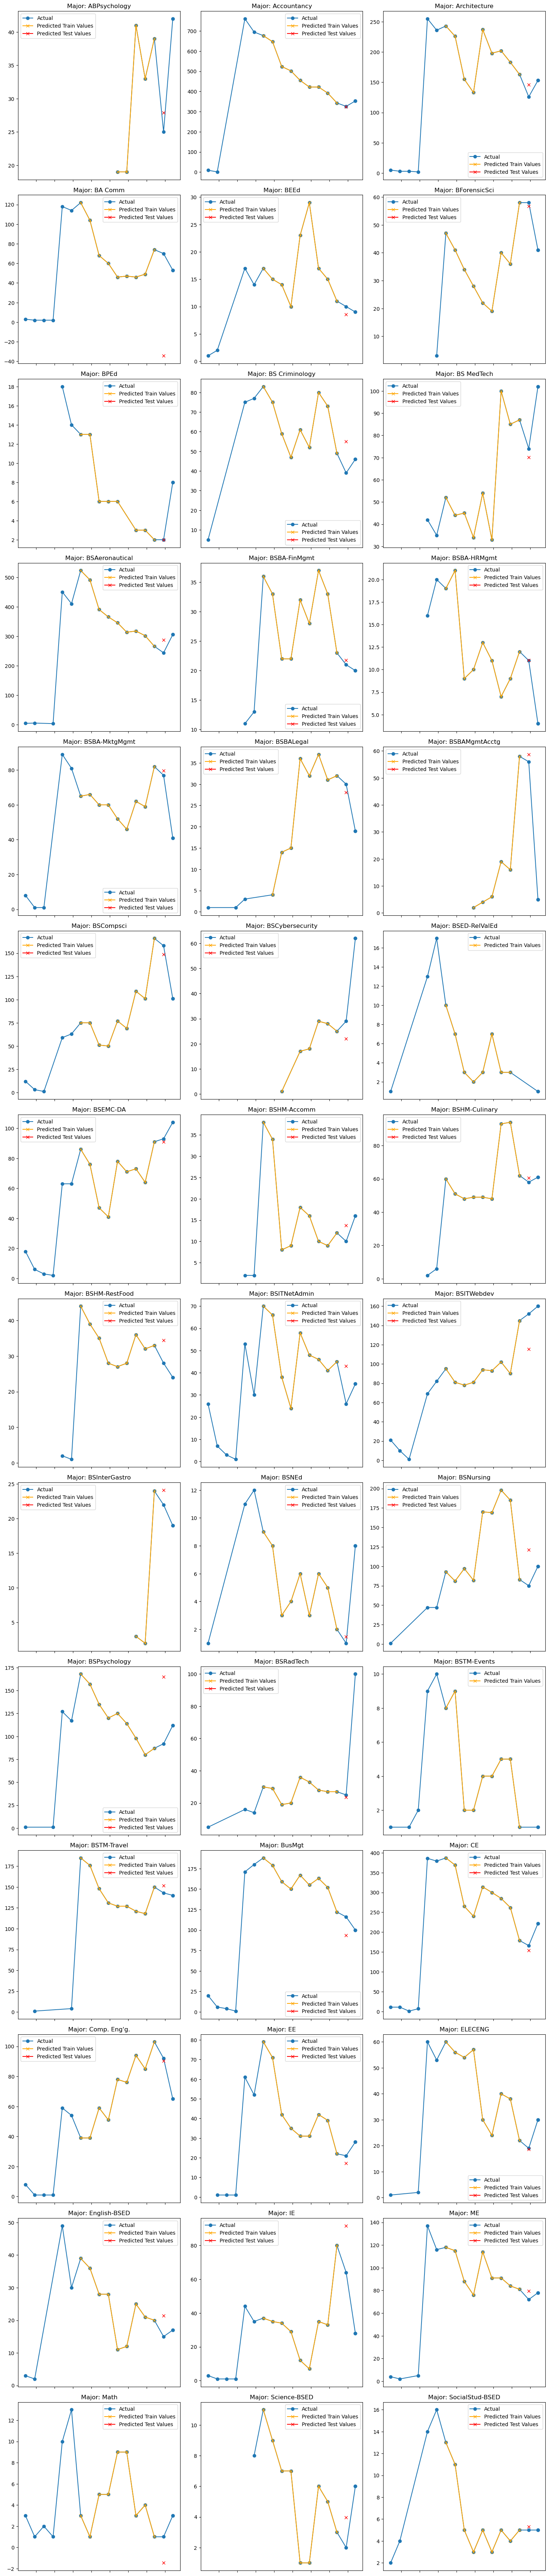

In [116]:
import matplotlib.pyplot as plt
import math

# X_train_plot = X_train.copy()
# X_test_plot = X_test.copy()
retained_majors_sorted = sorted(retained_majors)

# Create a new column for fractional year
X_train_plot['Start_Year_Fractional'] = X_train_plot['Start_Year'] + (X_train_plot['Semester'] * 6 - 1) / 12
X_test_plot['Start_Year_Fractional'] = X_test_plot['Start_Year'] + (X_test_plot['Semester'] * 6 - 1) / 12
finalDf_copy['Start_Year_Fractional'] = finalDf_copy['Start_Year'] + (finalDf_copy['Semester'] * 6 - 1) / 12

# Create a figure and a set of subplots with 3 columns
num_majors = len(finalDf_copy['Major'].unique())
num_cols = 3
num_rows = math.ceil(num_majors / num_cols)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), sharex=True)

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Iterate over each unique major and plot the true and predicted values
for i, major in enumerate(retained_majors_sorted):
    ax = axes[i]
    major_data = finalDf_copy[finalDf_copy['Major'] == major]
    # Get the training and test sets for the current major
    X_major_train = X_train_plot[X_train_plot['Major'] == major].reset_index(drop=True)
    y_major_train = y_train[X_train_plot['Major'] == major].reset_index(drop=True)
    
    X_major_test = X_test_plot[X_test_plot['Major'] == major].reset_index(drop=True)
    y_major_test = y_test[X_test_plot['Major'] == major].reset_index(drop=True)
    
        
    # Plot the actual values
    axes[i].plot(major_data['Start_Year_Fractional'], major_data['1st_Year'], label='Actual', marker='o')


    # Plot true values and predictions
    ax.plot(X_major_train['Start_Year_Fractional'], train_preds[major], label='Predicted Train Values', color='orange', marker='x')
    
    if major in test_preds:
        ax.plot(X_major_test['Start_Year_Fractional'], test_preds[major], label='Predicted Test Values', color='red', marker='x')
    
    ax.set_title(f'Major: {major}')
    ax.legend()

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.show()

KeyError: 'ABPsychology'

Error in callback <function _draw_all_if_interactive at 0x000002743A915E40> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

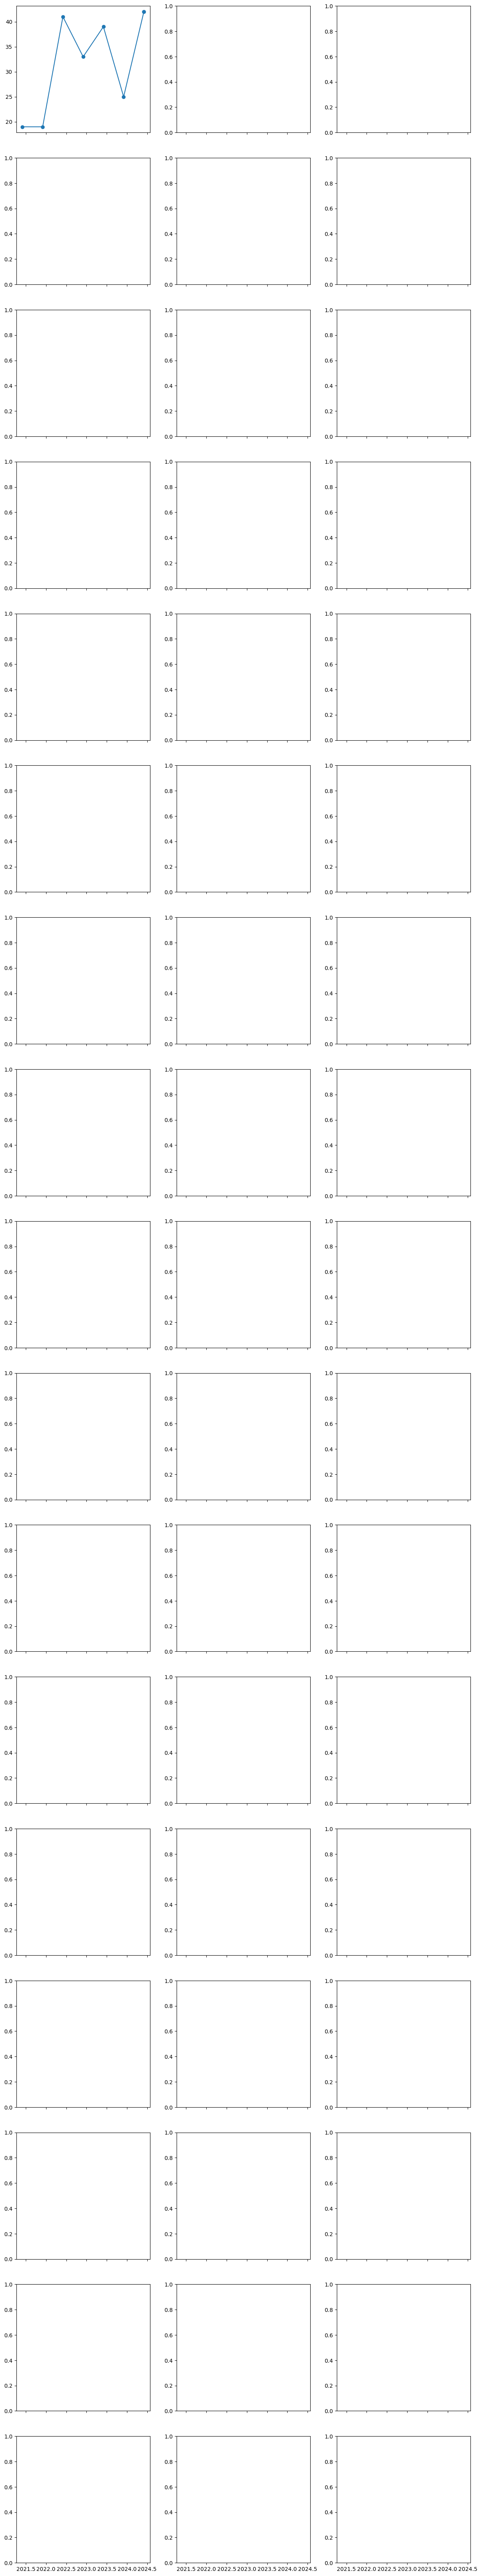

In [61]:
import matplotlib.pyplot as plt
import math

# X_train_plot = X_train.copy()
# X_test_plot = X_test.copy()
retained_majors_sorted = sorted(retained_majors)

# Create a new column for fractional year
X_train_plot['Start_Year_Fractional'] = X_train_plot['Start_Year'] + (X_train_plot['Semester'] * 6 - 1) / 12
X_test_plot['Start_Year_Fractional'] = X_test_plot['Start_Year'] + (X_test_plot['Semester'] * 6 - 1) / 12
finalDf_copy['Start_Year_Fractional'] = finalDf_copy['Start_Year'] + (finalDf_copy['Semester'] * 6 - 1) / 12

# Create a figure and a set of subplots with 3 columns
num_majors = len(finalDf_copy['Major'].unique())
num_cols = 3
num_rows = math.ceil(num_majors / num_cols)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), sharex=True)

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Iterate over each unique major and plot the true and predicted values
for i, major in enumerate(retained_majors_sorted):
    ax = axes[i]
    major_data = finalDf_copy[finalDf_copy['Major'] == major]
    # Get the training and test sets for the current major
    X_major_train = X_train_plot[X_train_plot['Major'] == major].reset_index(drop=True)
    y_major_train = y_train[X_train_plot['Major'] == major].reset_index(drop=True)
    
    X_major_test = X_test_plot[X_test_plot['Major'] == major].reset_index(drop=True)
    y_major_test = y_test[X_test_plot['Major'] == major].reset_index(drop=True)
    
        
    # Plot the actual values
    axes[i].plot(major_data['Start_Year_Fractional'], major_data['1st_Year'], label='Actual', marker='o')


    # Plot true values and predictions
    ax.plot(X_major_train['Start_Year_Fractional'], train_preds[major], label='Predicted Train Values', color='orange', marker='x')
    
    if major in test_preds:
        ax.plot(X_major_test['Start_Year_Fractional'], test_preds[major], label='Predicted Test Values', color='red', marker='x')
    
    ax.set_title(f'Major: {major}')
    ax.legend()

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.show()

In [54]:
import matplotlib.pyplot as plt
import math

X_train_plot = X_train.copy()
X_test_plot = X_test.copy()
retained_majors_sorted = sorted(retained_majors)

# Create a new column for fractional year
X_train_plot['Start_Year_Fractional'] = X_train_plot['Start_Year'] + (X_train_plot['Semester'] * 6 - 1) / 12
X_test_plot['Start_Year_Fractional'] = X_test_plot['Start_Year'] + (X_test_plot['Semester'] * 6 - 1) / 12
finalDf_copy['Start_Year_Fractional'] = finalDf_copy['Start_Year'] + (finalDf_copy['Semester'] * 6 - 1) / 12

# Create a figure and a set of subplots with 3 columns
num_majors = len(finalDf_copy['Major'].unique())
num_cols = 3
num_rows = math.ceil(num_majors / num_cols)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), sharex=True)

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Iterate over each unique major and plot the true and predicted values
for i, major in enumerate(retained_majors_sorted):
    ax = axes[i]
    major_data = finalDf_copy[finalDf_copy['Major'] == major]
    
    # Get the training and test sets for the current major
    X_major_train = X_train_plot[X_train_plot['Major'] == major].reset_index(drop=True)
    y_major_train = y_train[X_train_plot['Major'] == major].reset_index(drop=True)
    
    X_major_test = X_test_plot[X_test_plot['Major'] == major].reset_index(drop=True)
    y_major_test = y_test[X_test_plot['Major'] == major].reset_index(drop=True)
    
        
    # Plot the actual values
    axes[i].plot(major_data['Start_Year_Fractional'], major_data['1st_Year'], label='Actual', marker='o')


    # Plot true values and predictions
    ax.plot(X_major_train['Start_Year_Fractional'], train_preds[major], label='Predicted Train Values', color='orange', marker='x')
    
    if major in test_preds:
        ax.plot(X_major_test['Start_Year_Fractional'], test_preds[major], label='Predicted Test Values', color='red', marker='x')
    
    ax.set_title(f'Major: {major}')
    ax.legend()

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

Error in callback <function flush_figures at 0x00000274535D8360> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

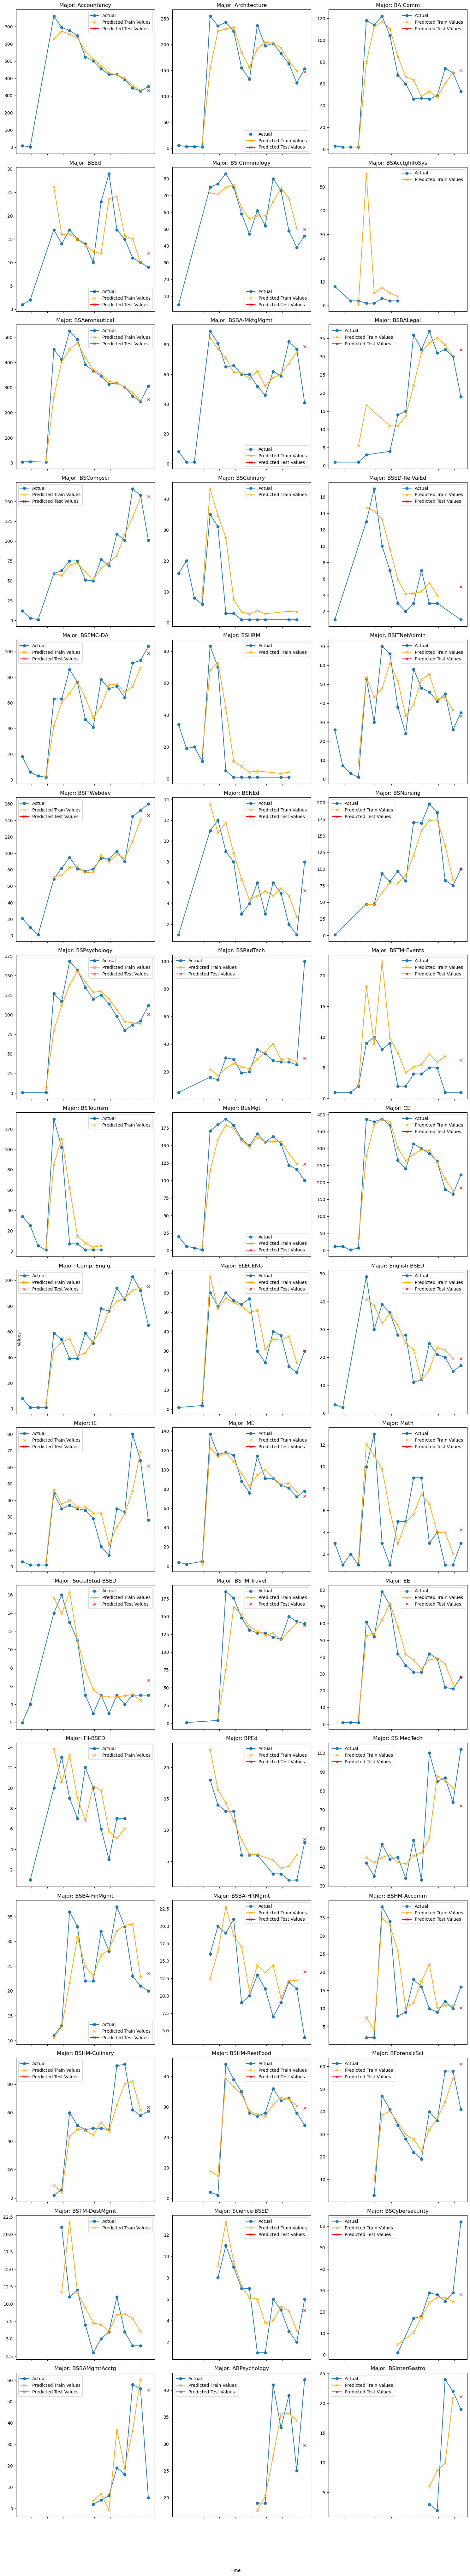

In [ ]:
import matplotlib.pyplot as plt
import math

X_train_plot = X_train.copy()
X_test_plot = X_test.copy()

# Create a new column for fractional year
X_train_plot['Start_Year_Fractional'] = X_train_plot['Start_Year'] + (X_train_plot['Semester'] * 6 - 1) / 12
X_test_plot['Start_Year_Fractional'] = X_test_plot['Start_Year'] + (X_test_plot['Semester'] * 6 - 1) / 12
finalDf_copy['Start_Year_Fractional'] = finalDf_copy['Start_Year'] + (finalDf_copy['Semester'] * 6 - 1) / 12

# Create a figure and a set of subplots with 3 columns
num_majors = len(finalDf_copy['Major'].unique())
num_cols = 3
num_rows = math.ceil(num_majors / num_cols)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), sharex=True)

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Iterate over each unique major and plot the true and predicted values
for i, major in enumerate(retained_majors):
    ax = axes[i]
    major_data = finalDf_copy[finalDf_copy['Major'] == major]
    
    # Get the training and test sets for the current major
    X_major_train = X_train_plot[X_train_plot['Major'] == major].reset_index(drop=True)
    y_major_train = y_train[X_train_plot['Major'] == major].reset_index(drop=True)
    
    X_major_test = X_test_plot[X_test_plot['Major'] == major].reset_index(drop=True)
    y_major_test = y_test[X_test_plot['Major'] == major].reset_index(drop=True)
    
        
    # Plot the actual values
    axes[i].plot(major_data['Start_Year_Fractional'], major_data['1st_Year'], label='Actual', marker='o')


    # Plot true values and predictions
    ax.plot(X_major_train['Start_Year_Fractional'], train_preds[major], label='Predicted Train Values', color='orange', marker='x')
    
    if major in test_preds:
        ax.plot(X_major_test['Start_Year_Fractional'], test_preds[major], label='Predicted Test Values', color='red', marker='x')
    
    ax.set_title(f'Major: {major}')
    ax.legend()

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Set common labels
fig.text(0.5, 0.04, 'Time', ha='center')
fig.text(0.04, 0.5, 'Values', va='center', rotation='vertical')

plt.tight_layout()
plt.show()

## KNN

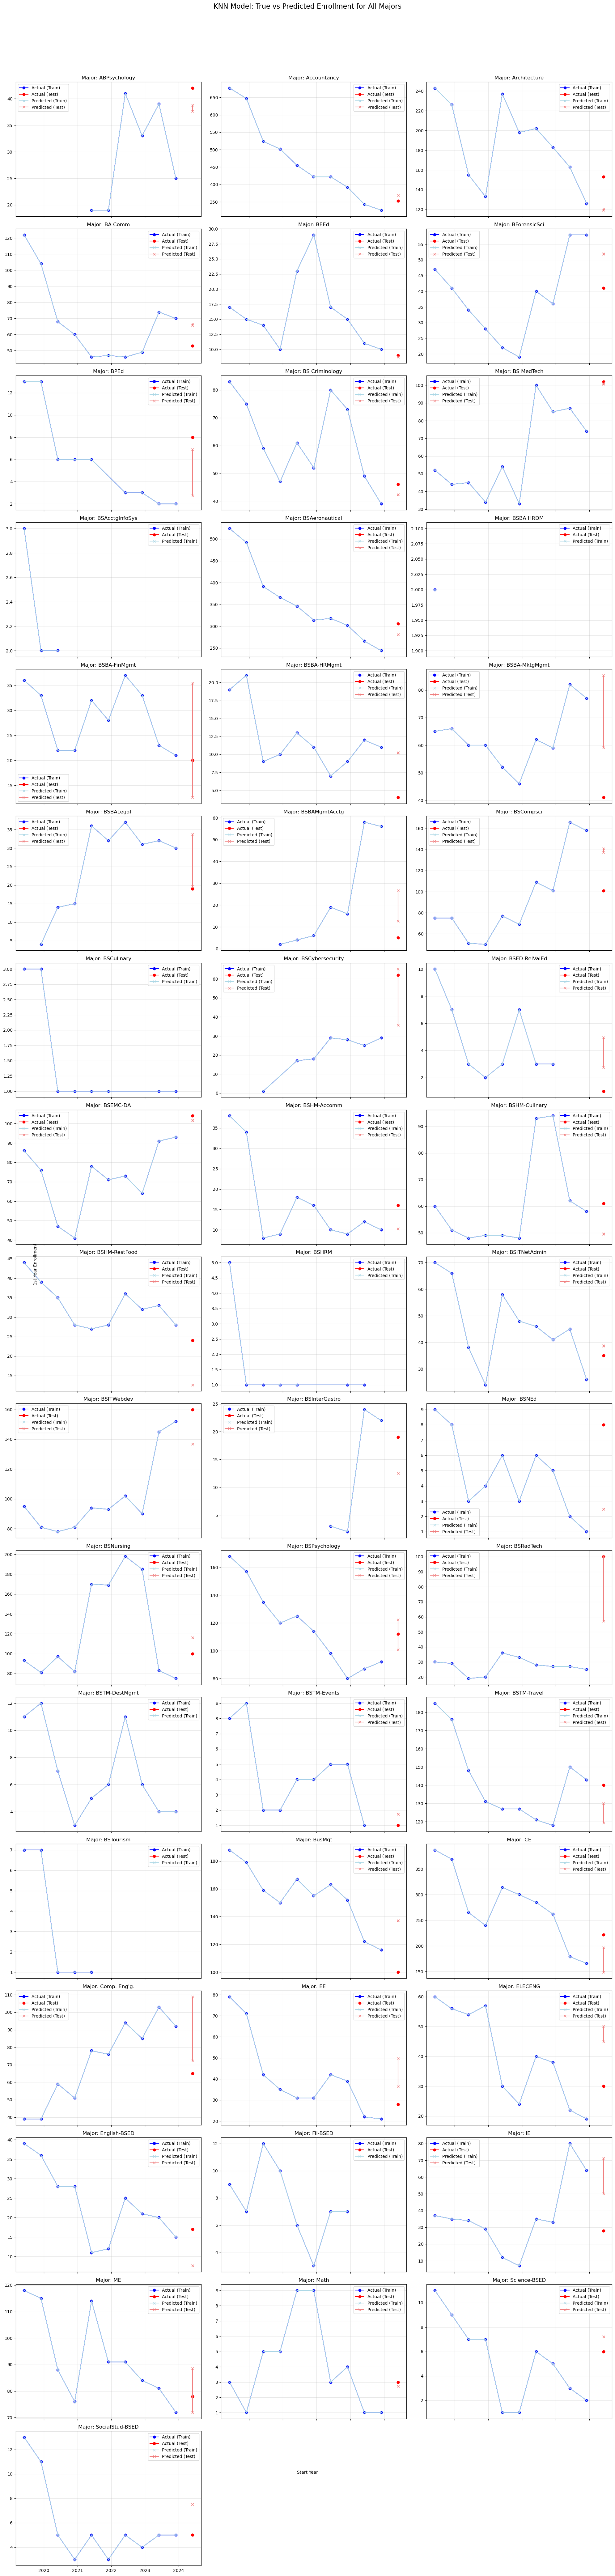

In [274]:
import matplotlib.pyplot as plt
import math
import numpy as np

# Assuming you have already trained the KNN model and made predictions

# Create dictionaries to store predictions for each major
train_preds = {}
test_preds = {}

# Group predictions by major for training data
for major in X_train_plot['Major'].unique():
    major_mask = X_train_plot['Major'] == major
    train_preds[major] = train_predictions[major_mask]

# Group predictions by major for test data
for major in X_test_plot['Major'].unique():
    major_mask = X_test_plot['Major'] == major
    test_preds[major] = test_predictions[major_mask]

# Create a new column for fractional year
X_train_plot['Start_Year_Fractional'] = X_train_plot['Start_Year'] + (X_train_plot['Semester'] * 6 - 1) / 12
X_test_plot['Start_Year_Fractional'] = X_test_plot['Start_Year'] + (X_test_plot['Semester'] * 6 - 1) / 12

# Create a figure and a set of subplots with 3 columns
num_majors = len(X_train_plot['Major'].unique())
num_cols = 3
num_rows = math.ceil(num_majors / num_cols)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows), sharex=True)

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Iterate over each unique major and plot the true and predicted values
for i, major in enumerate(sorted(X_train_plot['Major'].unique())):
    ax = axes[i]
    
    # Get the training and test sets for the current major
    X_major_train = X_train_plot[X_train_plot['Major'] == major].reset_index(drop=True)
    y_major_train = y_train[X_train_plot['Major'] == major].reset_index(drop=True)
    
    X_major_test = X_test_plot[X_test_plot['Major'] == major].reset_index(drop=True)
    y_major_test = y_test[X_test_plot['Major'] == major].reset_index(drop=True)
    
    # Plot the actual values
    ax.plot(X_major_train['Start_Year_Fractional'], y_major_train, label='Actual (Train)', marker='o', color='blue')
    ax.plot(X_major_test['Start_Year_Fractional'], y_major_test, label='Actual (Test)', marker='o', color='red')

    # Plot predicted values
    ax.plot(X_major_train['Start_Year_Fractional'], train_preds[major], label='Predicted (Train)', color='lightblue', marker='x')
    
    if major in test_preds:
        ax.plot(X_major_test['Start_Year_Fractional'], test_preds[major], label='Predicted (Test)', color='lightcoral', marker='x')
    
    ax.set_title(f'Major: {major}')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Set common labels
fig.text(0.5, 0.04, 'Start Year', ha='center', va='center')
fig.text(0.06, 0.5, '1st Year Enrollment', ha='center', va='center', rotation='vertical')
fig.suptitle('KNN Model: True vs Predicted Enrollment for All Majors', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

# Feature Importance
Permutation Importance

In [68]:
from sklearn.inspection import permutation_importance
import numpy as np

def calculate_permutation_importance(model, X, y, n_repeats=10, random_state=42):
    perm_importance = permutation_importance(model, X, y, n_repeats=n_repeats, random_state=random_state)
    
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': perm_importance.importances_mean,
        'std': perm_importance.importances_std
    }).sort_values('importance', ascending=False)
    
    return feature_importance


In [96]:
import xgboost as xgb
from sklearn.inspection import permutation_importance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_and_plot_permutation_importance(model, X, y, n_repeats=10, random_state=42, top_n=20, model_name=None):
    match model_name.lower():
        case "xgboost dart":
            # For XGBoost DART, we need to use the feature importances from the model directly
            feature_importance = pd.DataFrame({
                'feature': X.columns,
                'importance': model.feature_importances_,
                'std': np.zeros_like(model.feature_importances_)  # XGBoost doesn't provide std, so we use zeros
            }).sort_values('importance', ascending=False)

            print(feature_importance)
            
            # Select top N features
            top_features = feature_importance.head(top_n)
        # case "linear regression":
        #     # Dictionary to store feature importances for each major
        #     major_feature_importances = {}

        #     # Iterate over each unique major
        #     for major in X['Major'].unique():
        #         # Filter the data for the current major
        #         X_major = X[X['Major'] == major].drop(columns=['Major', 'Start_Month']).reset_index(drop=True)
        #         y_major = y[X['Major'] == major].reset_index(drop=True)
                
        #         # Ensure the major has a trained model
        #         if major not in lr_models:
        #             print(f"Skipping major {major} due to missing model.")
        #             continue
                
        #         # Get the pre-trained model for this major
        #         model = lr_models[major]
                
        #         # Calculate permutation importance for this major
        #         feature_importance = calculate_permutation_importance(model, X_major, y_major, n_repeats, random_state)
        #         major_feature_importances[major] = feature_importance

        #     # Calculate average feature importance across all majors
        #     all_features = list(set().union(*[set(df['feature']) for df in major_feature_importances.values()]))
        #     avg_importance = pd.DataFrame(index=all_features, columns=['importance', 'std'])

        #     for feature in all_features:
        #         importances = [df.loc[df['feature'] == feature, 'importance'].values[0] 
        #                     for df in major_feature_importances.values() 
        #                     if feature in df['feature'].values]
        #         stds = [df.loc[df['feature'] == feature, 'std'].values[0] 
        #                 for df in major_feature_importances.values() 
        #                 if feature in df['feature'].values]
                
        #         avg_importance.loc[feature, 'importance'] = np.mean(importances)
        #         avg_importance.loc[feature, 'std'] = np.mean(stds)

        #     avg_importance = avg_importance.sort_values('importance', ascending=False).reset_index()
        #     avg_importance.columns = ['feature', 'importance', 'std']
        #     top_features = avg_importance.head(top_n)

        case _:
            feature_importance = calculate_permutation_importance(model, X, y, n_repeats, random_state)

            print(feature_importance)
            
            # Select top N features
            top_features = feature_importance.head(top_n)
            
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Create the barplot without error bars
    ax = sns.barplot(x='importance', y='feature', data=top_features)
        
    
    # Add error bars manually
    for i, feature in enumerate(top_features['feature']):
        importance = top_features.loc[top_features['feature'] == feature, 'importance'].values[0]
        std = top_features.loc[top_features['feature'] == feature, 'std'].values[0]
        ax.errorbar(x=importance, y=i, xerr=std, fmt='none', ecolor='0.3', capsize=4)
    
    plt.title(f'Top {top_n} Features - Permutation Importance ({model_name}) - Year Level: {year_level}')
    plt.xlabel('Permutation Importance')
    plt.ylabel('Features')
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    
    return feature_importance

# Assuming you have your XGBoost model trained and your test data prepared
# xgb_model = your trained XGBoost model
# X_test = your test features
# y_test = your test target



## XGBoost DART

In [ ]:
XGBoost DART

## Random Forest

                                   feature  importance       std
24           Percentage_Distribution_lag_1    0.208528  0.008947
10                       Previous_Semester    0.203402  0.009506
12                             TOTAL_lag_1    0.098763  0.005720
11              1st_Year_rolling_std_lag_1    0.031529  0.003097
4               Number_of_Applicants_lag_1    0.015067  0.001999
15                               Major_PC1    0.013110  0.001701
5         Number_of_Applicants_rolling_std    0.006968  0.001100
16                               Major_PC2    0.006362  0.001605
13                          Department_PC1    0.003398  0.000845
14                          Department_PC2    0.002237  0.000653
18                       SHS-GenAcad_lag_1    0.001763  0.000192
0                               Start_Year    0.001326  0.000197
23  Total_Previous_Semester_Students_lag_1    0.001311  0.000222
2                  CPI_Region3_rolling_std    0.001179  0.000232
21                       

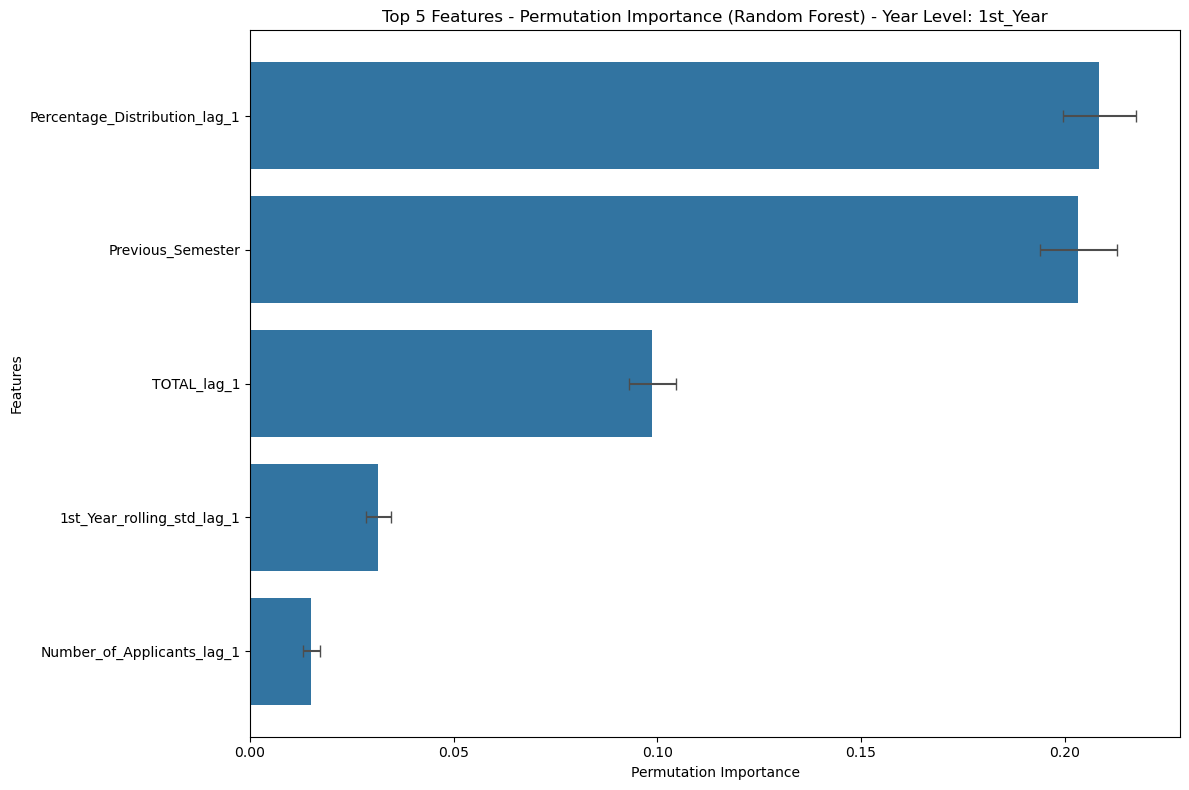

                                   feature  importance       std
24           Percentage_Distribution_lag_1    0.208528  0.008947
10                       Previous_Semester    0.203402  0.009506
12                             TOTAL_lag_1    0.098763  0.005720
11              1st_Year_rolling_std_lag_1    0.031529  0.003097
4               Number_of_Applicants_lag_1    0.015067  0.001999
15                               Major_PC1    0.013110  0.001701
5         Number_of_Applicants_rolling_std    0.006968  0.001100
16                               Major_PC2    0.006362  0.001605
13                          Department_PC1    0.003398  0.000845
14                          Department_PC2    0.002237  0.000653
18                       SHS-GenAcad_lag_1    0.001763  0.000192
0                               Start_Year    0.001326  0.000197
23  Total_Previous_Semester_Students_lag_1    0.001311  0.000222
2                  CPI_Region3_rolling_std    0.001179  0.000232
21                       

In [103]:
# Calculate and plot permutation importance
importance_df = calculate_and_plot_permutation_importance(rf_model, X_train.drop(columns=["Major", "Start_Month"]), y_train, top_n=5, model_name="Random Forest")

# Print the full importance DataFrame
print(importance_df)

## KNN

                                   feature  importance       std
12                             TOTAL_lag_1    0.877403  0.039052
4               Number_of_Applicants_lag_1    0.334323  0.030936
8                               HFCE_lag_1    0.220923  0.024342
5         Number_of_Applicants_rolling_std    0.182412  0.012137
9                         HFCE_rolling_std    0.145409  0.014126
10                       Previous_Semester    0.145241  0.013746
6                     HFCE_Education_lag_1    0.124662  0.016037
7               HFCE_Education_rolling_std    0.115913  0.011005
23  Total_Previous_Semester_Students_lag_1    0.075130  0.005449
11              1st_Year_rolling_std_lag_1    0.051970  0.004533
18                       SHS-GenAcad_lag_1    0.029240  0.002424
21                        SHS-TVL-HE_lag_1    0.016120  0.001226
17                           SHS-ABM_lag_1    0.015866  0.000905
20                          SHS-STEM_lag_1    0.013226  0.001396
22                       

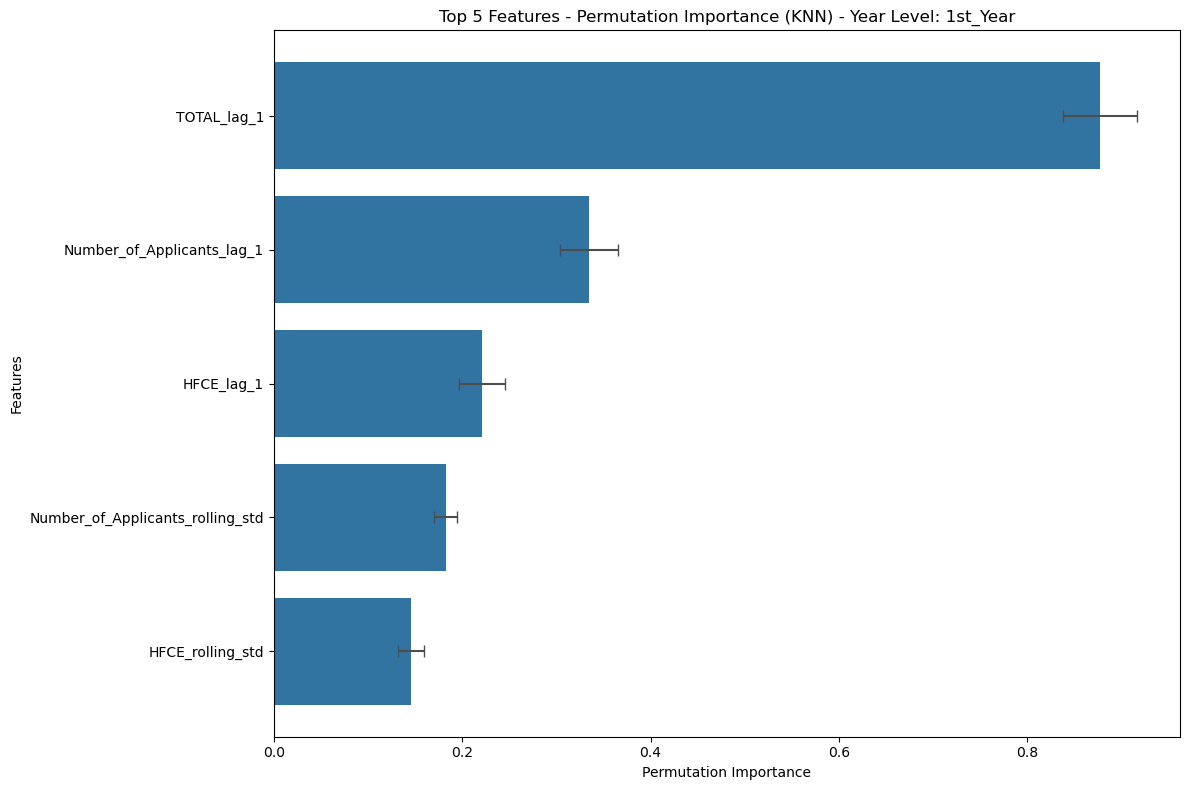

In [107]:
importance_df = calculate_and_plot_permutation_importance(knn_model, X_train.drop(columns=["Major", "Start_Month"]), y_train, top_n=5, model_name="KNN")


## Linear Regression

                                   feature  importance       std
10                       Previous_Semester    1.026484  0.149378
24           Percentage_Distribution_lag_1    0.130638  0.024872
16                               Major_PC2    0.005078  0.003053
13                          Department_PC1    0.003278  0.003830
4               Number_of_Applicants_lag_1    0.000600  0.000742
23  Total_Previous_Semester_Students_lag_1    0.000000  0.000000
22                       SHS-TVL-ICT_lag_1    0.000000  0.000000
21                        SHS-TVL-HE_lag_1    0.000000  0.000000
20                          SHS-STEM_lag_1    0.000000  0.000000
19                         SHS-HUMSS_lag_1    0.000000  0.000000
18                       SHS-GenAcad_lag_1    0.000000  0.000000
17                           SHS-ABM_lag_1    0.000000  0.000000
0                               Start_Year    0.000000  0.000000
1                                 Semester    0.000000  0.000000
9                        

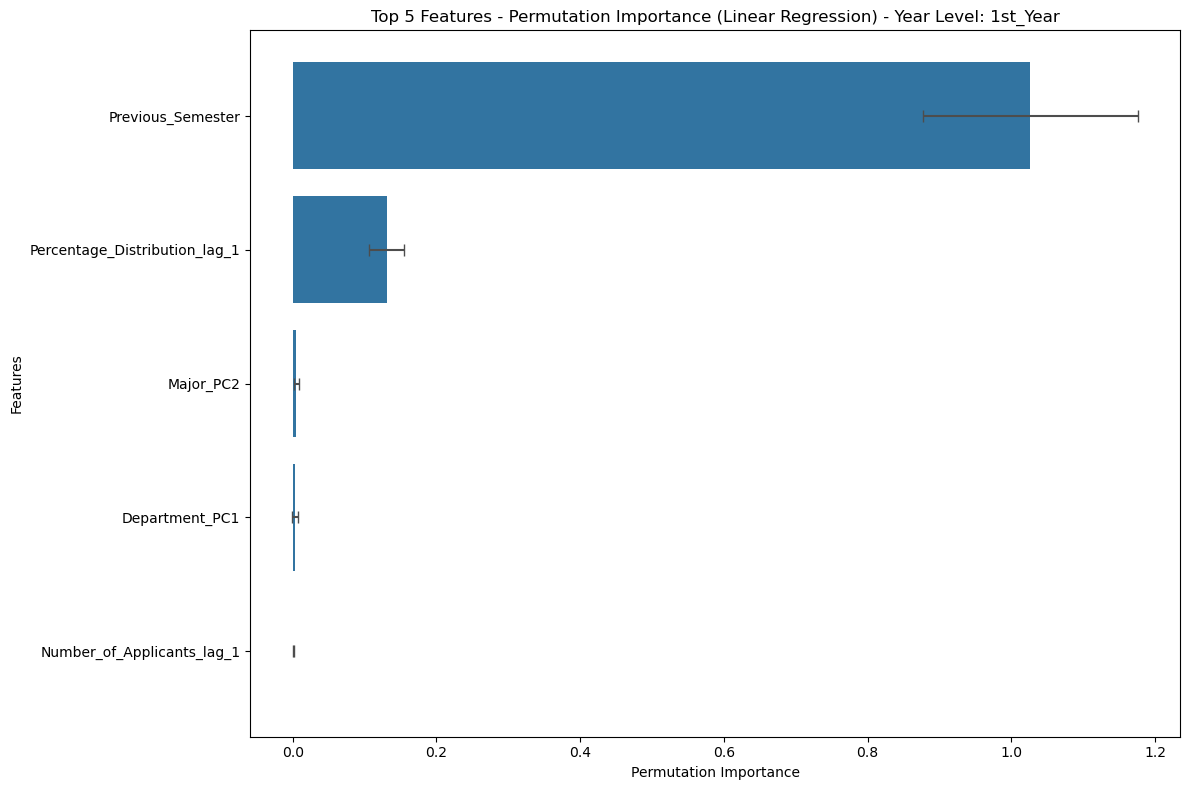

In [102]:
importance_df = calculate_and_plot_permutation_importance(lr_model, X_test.drop(columns=["Major", "Start_Month"]), y_test, top_n=5, model_name="Linear Regression")


# Database

In [ ]:
%pip install psycopg2


   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 1.2/1.2 MB 7.2 MB/s eta 0:00:00


In [6]:
import psycopg2
import pandas as pd
from sqlalchemy import create_engine

def connect_to_database(username, password, host='localhost', port=5432, db_name='angeliteforecast'):
    """Create a database connection."""
    connection_string = f'postgresql://{username}:{password}@{host}:{port}/{db_name}'
    engine = create_engine(connection_string)
    return engine
engine = connect_to_database("postgres", "thesis")



In [216]:
def clean_data(df):
    

    # Step 2: Correct departments

    for major, department in incorrect_department_dict.items():
        df.loc[df["Major"]== major, 'Department'] = department
        
    # Step 3: Rename departments
    df['Department'] = df['Department'].replace(department_dict)

    # Step 4: Drop unwanted majors
    # df = df[~df['Major'].isin(drop_majors)]

    # df = df[~df['Department'].isin(['GS', 'JHS', 'HAUSPELL', 'HAU', 'MA'])]
    df = df.reset_index(drop=True)
    df =df.sort_values(by=["Start_Year", "Semester", "Department", "Major"])
    return df


In [48]:
df = pd.read_csv("data/Enrollment_Data.csv").sort_values(by=["Start_Year", "Semester", "Department", "Major"])
cpi_df = pd.read_csv("data/CPI_Education.csv").sort_values(by=["Year", "Month"])
inflation_df = pd.read_csv("data/Inflation_Rate.csv").sort_values(by="Start_Year")
admission_df = pd.read_csv("data/Admission_Data.csv").sort_values(by=["Start_Year", "Department"])
hfce_df = pd.read_csv("data/HFCE.csv").sort_values(by=["Start_Year", "Quarter"])

df = clean_data(df)

# Upload data to database
df.to_sql('enrollment', engine, if_exists='replace', index=False)
cpi_df.to_sql('cpi_education', engine, if_exists='replace', index=False)
inflation_df.to_sql('inflation_rate', engine, if_exists='replace', index=False)
admission_df.to_sql('admission', engine, if_exists='replace', index=False)
hfce_df.to_sql('hfce', engine, if_exists='replace', index=False)


54

In [36]:
df

Major Department  Semester  Start_Year  End_Year  1st_Year  \
0     BS Criminology      CCJEF         1        2016      2017       NaN   
1     BS Criminology      CCJEF         1        2016      2017       5.0   
2          BSCompsci        SOC         1        2016      2017       NaN   
3         BSITWebdev        SOC         1        2016      2017       1.0   
4                 GS         GS         1        2016      2017       NaN   
..               ...        ...       ...         ...       ...       ...   
983  BSCybersecurity        SOC         1        2024      2025      17.0   
984  BSCybersecurity        SOC         1        2024      2025      45.0   
985         BSEMC-DA        SOC         1        2024      2025     104.0   
986     BSITNetAdmin        SOC         1        2024      2025      35.0   
987       BSITWebdev        SOC         1        2024      2025     160.0   

     2nd_Year  3rd_Year  4th_Year  5th_Year  ...  Grade_4  Grade_5  Grade_6  \
0         1.0      12.0      85.0       NaN  ...      NaN      NaN      NaN   
1       126.0      91.0       NaN       NaN  ...      NaN      NaN      NaN   
2         NaN       NaN       1.0       NaN  ...      NaN      NaN      NaN   
3         NaN       NaN       NaN       NaN  ...      NaN      NaN      NaN   
4         NaN       NaN       NaN       NaN  ...     94.0    131.0    103.0   
..        ...       ...       ...       ...  ...      ...      ...      ...   
983      10.0       4.0       NaN       NaN  ...      NaN      NaN      NaN   
984      29.0      21.0      17.0       NaN  ...      NaN      NaN      NaN   
985      96.0      67.0      64.0       NaN  ...      NaN      NaN      NaN   
986      19.0      27.0      25.0       NaN  ...      NaN      NaN      NaN   
987     145.0      85.0      97.0       NaN  ...      NaN      NaN      NaN   

     Grade_7  Grade_8  Grade_9  Grade_10  Grade_11  Grade_12  TOTAL  
0        NaN      NaN      NaN       NaN       NaN       NaN     98  
1        NaN      NaN      NaN       NaN       NaN       NaN    222  
2        NaN      NaN      NaN       NaN       NaN       NaN      1  
3        NaN      NaN      NaN       NaN       NaN       NaN      1  
4        NaN      NaN      NaN       NaN       NaN       NaN    579  
..       ...      ...      ...       ...       ...       ...    ...  
983      NaN      NaN      NaN       NaN       NaN       NaN     31  
984      NaN      NaN      NaN       NaN       NaN       NaN    112  
985      NaN      NaN      NaN       NaN       NaN       NaN    331  
986      NaN      NaN      NaN       NaN       NaN       NaN    106  
987      NaN      NaN      NaN       NaN       NaN       NaN    487  

[988 rows x 23 columns]

In [ ]:
df.columns

Index(['Major', 'Department', 'Semester', 'Start_Year', 'End_Year', '1st_Year',
       '2nd_Year', '3rd_Year', '4th_Year', '5th_Year', 'Grade_1', 'Grade_2',
       'Grade_3', 'Grade_4', 'Grade_5', 'Grade_6', 'Grade_7', 'Grade_8',
       'Grade_9', 'Grade_10', 'Grade_11', 'Grade_12', 'TOTAL'],
      dtype='object')